In [64]:
'''
load original df
'''

import pandas as pd
import os
import numpy as np
from functions import *
from scipy.stats import mannwhitneyu
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
import re
import warnings
warnings.filterwarnings('ignore') #supresses warnings for now
#warnings.filterwarnings(action='once') #shows warnings once
from statannotations.Annotator import Annotator

dataFilePath = os.path.join(os.getcwd(),'Data')

kicsTEdf = pd.read_csv(os.path.join(dataFilePath,'kics_transposable_elements.txt'), sep = '\t', header = 0)
lfsTEdf = pd.read_csv(os.path.join(dataFilePath,'lfs_transposable_elements.txt'), sep = '\t', header = 0)
lfsClinicdf = pd.read_csv(os.path.join(dataFilePath,'lfs_clinical_main.tsv'), sep = '\t', header = 0)
kicsClinicdf = pd.read_csv(os.path.join(dataFilePath,'kics_clinical_edited.csv'), encoding='latin-1')

In [65]:
#setting the font of the graphs
sns.set(font_scale=1.5)

In [66]:
"""
Kics clinic df cleaning
"""
#removal of these Kics ID
listValSearch = ['63', '83', '156', '171', '219', '120', '141', '232']

kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].astype(str)
kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].str.replace(" ", "")

for i in listValSearch:
    kicsClinicdf.drop(kicsClinicdf[kicsClinicdf['KiCS ID']==i].index, inplace = True)

#these two lines are causing us to go from 140->90 ish samples
#drop columns with '?' and na cancer types
kicsClinicdf.drop(kicsClinicdf.loc[kicsClinicdf['tissue_type']=='?'].index, inplace=True)
kicsClinicdf.drop(kicsClinicdf.loc[pd.isna(kicsClinicdf['lfs_cancer_type_diagnosis'])].index, inplace=True)


In [67]:
"""
lfs clinic df cleaning
"""
#sample id cleaning
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].str.replace(" ", "")

for i in listValSearch:
    lfsClinicdf.drop(lfsClinicdf[lfsClinicdf['sample']==i].index, inplace = True)

#tissue type and cancer diagnosis cleaning
lfsClinicdf.drop(lfsClinicdf.loc[lfsClinicdf['tissue_type']=='?'].index, inplace=True)
lfsClinicdf.drop(lfsClinicdf.loc[pd.isna(lfsClinicdf['cancer_diagnosis'])].index, inplace=True)

In [68]:
"""
'ALT' column clean up
"""

kicsTEdf['ALT'] = kicsTEdf['ALT'].str.replace("<INS:ME:","")
kicsTEdf['ALT'] = kicsTEdf['ALT'].str.replace(">","")

lfsTEdf['ALT'] = lfsTEdf['ALT'].str.replace("<INS:ME:","")
lfsTEdf['ALT'] = lfsTEdf['ALT'].str.replace(">","")
print(lfsTEdf['ALT'].value_counts())

ALU      90163
LINE1     4342
SVA       2712
Name: ALT, dtype: int64


In [69]:
"""
Filtering and cleaning Samples_ID
"""
kicsTEF = kicsTEdf.loc[(kicsTEdf['Annotation_mode'] == 'full')]
lfsTEF = lfsTEdf.loc[(lfsTEdf['Annotation_mode'] == 'full')]

kicsTEF['SV_chrom'] = kicsTEF['SV_chrom'].astype(str)
lfsTEF['SV_chrom'] = lfsTEF['SV_chrom'].astype(str)

kicsTEF['Samples_ID'] = kicsTEF['Samples_ID'].astype(str).str.replace(".realigned-recalibrated","")
lfsTEF['Samples_ID'] = lfsTEdf['Samples_ID'].astype(str).str.replace('.realigned-recalibrated', '')

kicsTEF.drop(kicsTEF.loc[pd.isna(kicsTEF['Samples_ID'])].index, inplace=True)
lfsTEF.drop(lfsTEF.loc[pd.isna(lfsTEF['Samples_ID'])].index, inplace=True)

kicsTEnum = kicsTEF['Samples_ID'].count()
lfsTEnum = lfsTEF['Samples_ID'].count()

listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
# searched for kID of 63, 83, 156, 171, 219 > lynch ids
# kID 120 141 and 232 do not have any matches...
for i in listValSearch: 
    kicsTEF.drop(kicsTEF[kicsTEF['Samples_ID'].str.contains(i)==True].index, inplace = True)
    

mergedTEdf = pd.DataFrame(data = {'kics':kicsTEF['SV_type'], 'kChrom':kicsTEF['SV_chrom'], 
                                  'kAlt':kicsTEF['ALT'], 'lAlt':lfsTEF['ALT'],
                                  'kID':kicsTEF['Samples_ID'], 'lID': lfsTEF['Samples_ID'],
                                  'lfs':lfsTEF['SV_type'], 'lChrom':lfsTEF['SV_chrom']})

In [71]:

print(kicsTEdf['Samples_ID'].nunique())



80


In [7]:
"""
Make big k df
"""

UberbigKdf = kIdAbbv(kicsClinicdf, kicsTEF, 'CCP germline', 'Samples_ID')

bigKdf = UberbigKdf[['CCP germline', 'Samples_ID', 'tumour_class','tissue_type',
                    'lfs_cancer_type_diagnosis', 'abbv_id','diagnosis_age (days)', 'SV_type','abbv_id','ALT']]

79


In [8]:
"""
Make a big lfs df
"""
UberbigLdf = pd.merge(lfsTEF[['Samples_ID','SV_type','ALT']],
                 lfsClinicdf,
                 left_on = 'Samples_ID',
                 right_on = 'sample',
                 how='inner')

bigLdf = UberbigLdf[['Samples_ID','SV_type','ALT','sample','tissue_type','cancer_diagnosis','ageofonset']]
             
bigKdf = bigKdf.rename(columns={'diagnosis_age (days)': 'ageofonset', 'CCP germline':'sample',
                                'lfs_cancer_type_diagnosis':'cancer_diagnosis'})

In [73]:
print(UberbigKdf['Samples_ID'].nunique())
print(UberbigLdf['Samples_ID'].nunique())


42
63


# RMS and Soft Tissue

In [9]:
#RMS and Soft tissue breakdown
kDf = UberbigKdf[['Samples_ID', 'ALT', 'abbv_id', 'KiCS ID', 'ICDO-diagnosis',
       'tissue_type', 'lfs_cancer_type_diagnosis','Previous cancers', 'Germline Sample from',
       'Germline sample type', 'CCP germline.1', 'WGS DNA germline',
       'WGS germline', 'pathology_id', 'Sample type', 'CCP tumor', 'CCP PPID',
       'CCP', 'WGS tumor ID', 'WGS Tumor', 'RNA ID', 'RNA',
       'single_somatic_specimen', 'disease_state', 'sample_type',
       'post_treatment', 'sample site', 'tumour_class', 'Sex',
       'diagnosis_age (days)', 'no_chemo_or_xrt']]

#use ICDO-diagnosis
lDf = UberbigLdf[['Samples_ID','ALT', 'sample',
       'tm_donor', 'tissue_type', 'cancer_diagnosis', 'active_cancer',
       'gender', 'systemic_treatment_atdraw', 'ageofonset', 'agesamplecollection',
       'cancer_num', 'cancer1_age_diff', 'cancer1', 'cancer1_ageofonset',
       'cancer2', 'cancer2_ageofonset', 'cancer3', 'cancer3_ageofonset',
       'cancer4', 'cancer4_ageofonset', 'cancer5', 'cancer5_ageofonset',
       'cancer6', 'cancer6_ageofonset', 'cancer7', 'cancer7_ageofonset',
       'cancer8', 'cancer8_ageofonset']]
#use Cancer 1 as detailed cancer diagnsosis

#overall diagnosis -> RMS and overall Soft Tissue tissue type <-
kST = kDf.loc[kDf['tissue_type']=='Soft Tissue']
kST = kST[['Samples_ID', 'ALT', 'ICDO-diagnosis', 'lfs_cancer_type_diagnosis']]
lST = lDf.loc[lDf['tissue_type']=='Soft Tissue']
lST = lST[['Samples_ID', 'ALT', 'cancer1', 'cancer_diagnosis']]

group = kST.drop(['ALT'],axis=1).groupby(['Samples_ID','ICDO-diagnosis']).value_counts().to_frame()
print('Overall KiCS Soft Tissue Mappings')
print(group)
print()

group1 = lST.drop(['ALT'],axis=1).groupby(['Samples_ID','cancer1']).value_counts().to_frame()
print('Overall LFS Soft Tissue Mappings')
print(group1)
print()

krms = kDf.loc[kDf['lfs_cancer_type_diagnosis']=='RMS']
krms = krms[['Samples_ID', 'ALT', 'ICDO-diagnosis', 'tissue_type']]
lrms = lDf.loc[lDf['cancer_diagnosis']=='RMS']
lrms = lrms[['Samples_ID', 'ALT', 'cancer1', 'tissue_type']]

group2 = krms.drop(['ALT'],axis=1).groupby(['Samples_ID','ICDO-diagnosis']).value_counts().to_frame()
print('Overall KiCS RMS Mappings')
print(group2)
print()

group2 = lrms.drop(['ALT'],axis=1).groupby(['Samples_ID','cancer1']).value_counts().to_frame()
print('Overall LFS RMS Mappings')
print(group2)
print()

Overall KiCS Soft Tissue Mappings
                                                                                  0
Samples_ID ICDO-diagnosis                           lfs_cancer_type_diagnosis      
273308     8920/3 - Alveolar rhabdomyosarcoma       RMS                        1948
284386     8910/3 - Embryonal Rhabdomyosarcoma, NOS RMS                        4516
297043     8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        1073
298866     8910/3 - Embryonal Rhabdomyosarcoma, NOS RMS                        1096
305082     8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        2178

Overall LFS Soft Tissue Mappings
                                                                 0
Samples_ID cancer1                        cancer_diagnosis        
1092       Malignant fibrous histiocytoma MFH                 1079
1355       Anaplastic ERMS                RMS                 1058
1843       High Grade Sarcoma             High Grade Sarcoma  1080
2085     

In [10]:
titles = ['lfs','kics']
columns = titles

In [11]:
"""

1. Graph for frequency of SV types
2. Graphs for frequency of SV types specific to chromosomes

Function to graph bar graphs

"""
    
xLabels = ['DEL','DUP','INV']
uniqueLabels = ['1','2','3','4','5','6','7','8','9','10',
                '11','12','13','14','15','16','17','18','19','20','21','22','X','Y']


In [12]:
"""
Creating variables and df used to make the SV specific graphs
"""
#probably a better way to do this

kicsSVTypedf = pd.DataFrame(data = {'kics':kicsTEF['SV_type'], 
                                  'kId':kicsTEF['Samples_ID']})
lfsSVTypedf = pd.DataFrame(data = {'lId':lfsTEF['Samples_ID'],
                                  'lfs':lfsTEF['SV_type']})

##kics
ktemp = kicsSVTypedf.groupby(['kId']).value_counts()

##lfs
ltemp = lfsSVTypedf.groupby(['lId']).value_counts()

#get unique identifiers
uniqueK = kicsSVTypedf['kId'].unique()
uniqueL = lfsSVTypedf['lId'].unique()

# SV Type

In [13]:
kINSData = makeDataSet(uniqueK, ktemp, 'INS')
lINSData = makeDataSet(uniqueL, ltemp, 'INS')
tempINSDF = makeUnequalDF(kINSData, lINSData)

## INS

79
63
MannwhitneyuResult(statistic=1542.5, pvalue=0.00010322632415350713)


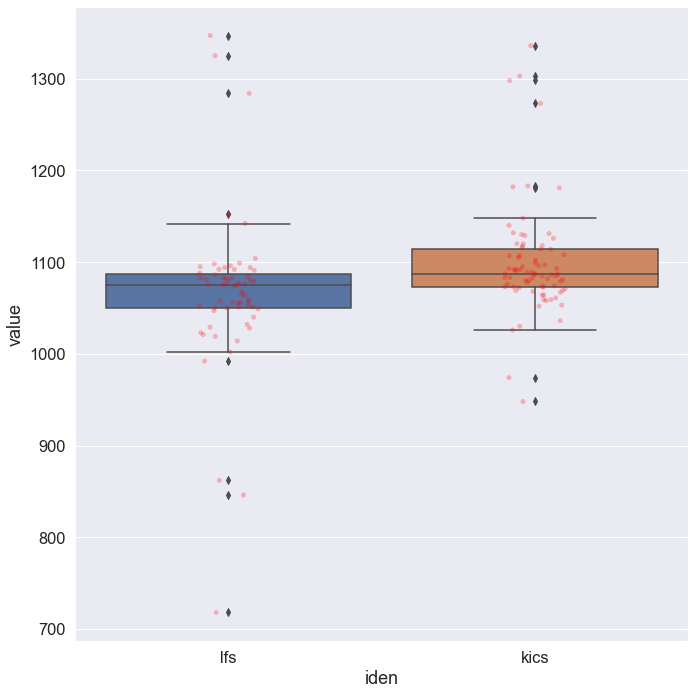

Index(['kics', 'lfs'], dtype='object')
Empty DataFrame
Columns: [kics, lfs]
Index: []


In [76]:
print(tempINSDF['kics'].count())
print(tempINSDF['lfs'].count())

boxplotPoints(titles, columns, tempINSDF, 10, 10)

print(tempINSDF.columns)
print(tempINSDF.loc[tempINSDF['lfs']<200])

In [15]:
"""
Chromosome Specific
Cleaned up
"""
orderList = ['1','2','3','4','5','6','7','8','9','10',
                 '11','12','13','14','15','16','17','18','19','20','21','22','X','Y']

kicsMore = pd.DataFrame(data = {'SV':kicsTEF['SV_type'], 'chrom':kicsTEF['SV_chrom'], 
                                  'id':kicsTEF['Samples_ID']})
lfsMore = pd.DataFrame(data = {'id':lfsTEF['Samples_ID'], 'chrom':lfsTEF['SV_chrom'],
                                  'SV':lfsTEF['SV_type']})

numBPChrom = [249250621, 243199373, 198022430, 191154276, 180915260, 
              171115067, 159138663, 146364022, 141213431, 135534747,
              135006516, 133851895, 115169878, 107349540, 102531392,
              90354753, 81195210, 78077248, 59128983, 63025520,
              48129895, 51304566, 155270560, 59373566]

grouping = ['id', 'SV', 'chrom']

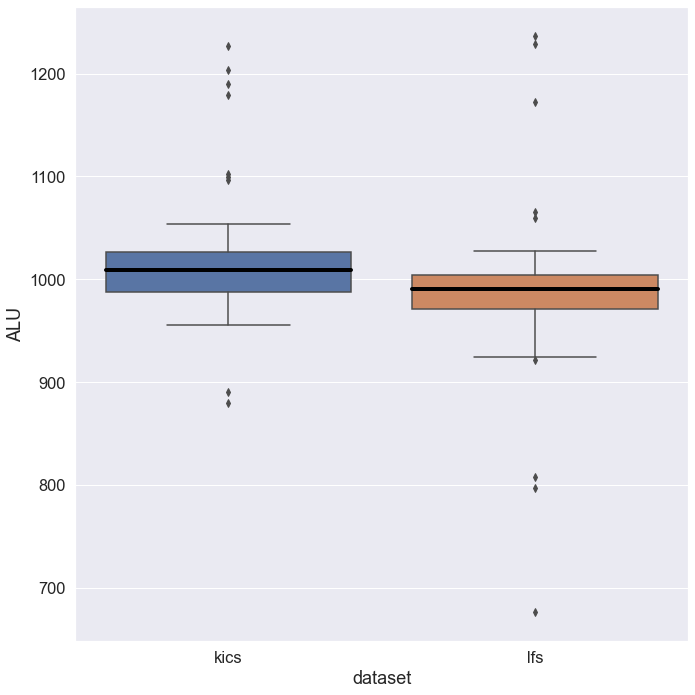

MannwhitneyuResult(statistic=3405.5, pvalue=0.00016735464124410167)


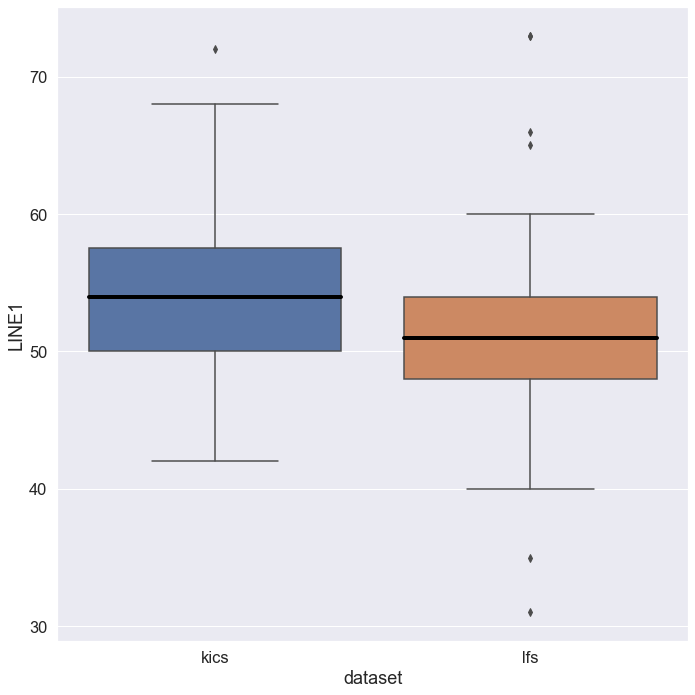

MannwhitneyuResult(statistic=3296.0, pvalue=0.0008982191122282993)


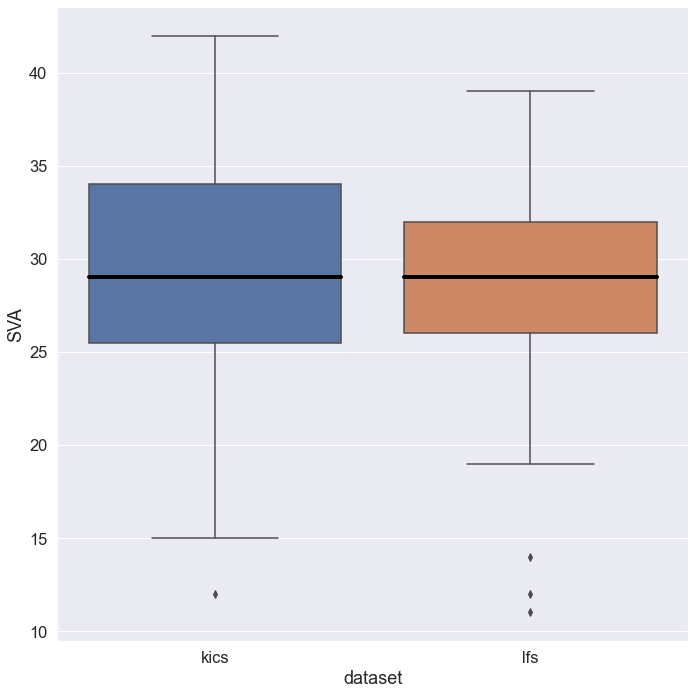

MannwhitneyuResult(statistic=2608.0, pvalue=0.6244689679773743)


In [16]:
"""
ALU, LINE1, SVA
"""

kicsALT = pd.DataFrame(data={'ALT':kicsTEF['ALT'], 'id':kicsTEF['Samples_ID']})
lfsALT = pd.DataFrame(data={'ALT':lfsTEF['ALT'],'id':lfsTEF['Samples_ID']})

kicsALT = kicsALT.groupby('id')
kicsALT = kicsALT.value_counts().to_frame()
kicsALT = kicsALT.unstack(1)
kicsALT.columns = kicsALT.columns.droplevel(0)
kicsALT['dataset'] = 'kics'

lfsALT = lfsALT.groupby('id')
lfsALT = lfsALT.value_counts().to_frame()
lfsALT = lfsALT.unstack(1)
lfsALT.columns = lfsALT.columns.droplevel(0)
lfsALT['dataset'] = 'lfs'

mergedAlt = pd.concat([kicsALT,lfsALT])
mergedAlt = mergedAlt.reset_index()

#plotting the "overall" TE class boxplots
sns.boxplot(data=mergedAlt, x='dataset', y='ALU', medianprops={"linewidth": 4, "color": 'black'})
plt.show()

print(mannwhitneyu(kicsALT['ALU'].dropna(),lfsALT['ALU'].dropna()))

sns.boxplot(data=mergedAlt, x='dataset', y='LINE1', medianprops={"linewidth": 4, "color": 'black'})
plt.show()

print(mannwhitneyu(kicsALT['LINE1'].dropna(),lfsALT['LINE1'].dropna()))

sns.boxplot(data=mergedAlt, x='dataset', y='SVA', medianprops={"linewidth": 4, "color": 'black'})
plt.show()

print(mannwhitneyu(kicsALT['SVA'].dropna(),lfsALT['SVA'].dropna()))

LFS
     chrom   occ dataset
1920     1  44.0     lfs
3000     1  43.0     lfs
3120     1  96.0     lfs
the outliers for 1 are:
None

Empty DataFrame
Columns: [chrom, occ, dataset]
Index: []
the outliers for 10 are:
None

     chrom   occ dataset
2666    11  66.0     lfs
3002    11  35.0     lfs
3122    11  73.0     lfs
the outliers for 11 are:
None

     chrom   occ dataset
2211    12  74.0     lfs
3003    12  34.0     lfs
the outliers for 12 are:
None

     chrom   occ dataset
1900    13  65.0     lfs
2212    13  74.0     lfs
2596    13  67.0     lfs
3004    13  40.0     lfs
the outliers for 13 are:
None

Empty DataFrame
Columns: [chrom, occ, dataset]
Index: []
the outliers for 14 are:
None

     chrom   occ dataset
2310    15  21.0     lfs
the outliers for 15 are:
None

Empty DataFrame
Columns: [chrom, occ, dataset]
Index: []
the outliers for 16 are:
None

Empty DataFrame
Columns: [chrom, occ, dataset]
Index: []
the outliers for 17 are:
None

Empty DataFrame
Columns: [chrom, occ, da

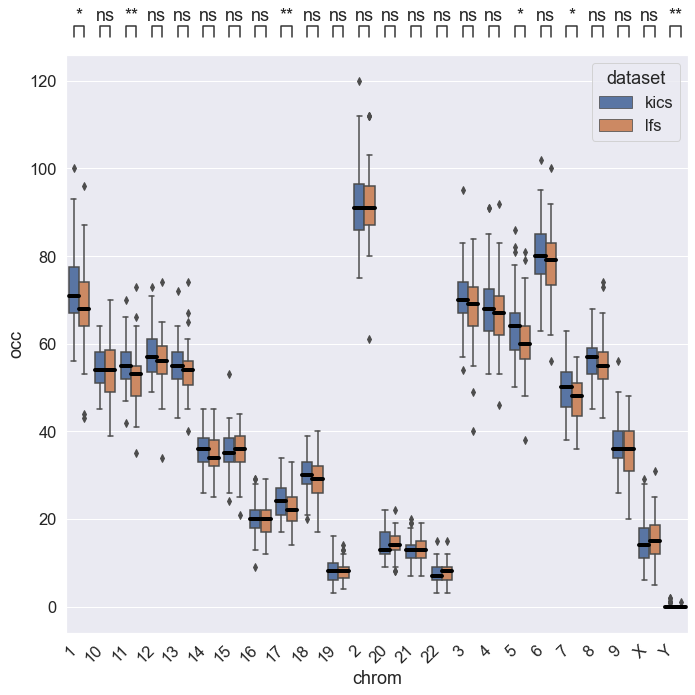

LFS
      index chrom    normalized dataset
1896      0     1  2.647937e-07     lfs
1920      0     1  1.765291e-07     lfs
1944      0     1  2.808418e-07     lfs
1968      0     1  2.968899e-07     lfs
1992      0     1  2.647937e-07     lfs
...     ...   ...           ...     ...
3288      0     1  2.567697e-07     lfs
3312      0     1  2.527576e-07     lfs
3336      0     1  2.326975e-07     lfs
3360      0     1  2.567697e-07     lfs
3384      0     1  2.928779e-07     lfs

[63 rows x 4 columns]
the outliers for 1 are:
None

      index chrom    normalized dataset
1897      1     2  3.659549e-07     lfs
1921      1     2  3.577312e-07     lfs
1945      1     2  3.659549e-07     lfs
1969      1     2  4.111853e-07     lfs
1993      1     2  4.070734e-07     lfs
...     ...   ...           ...     ...
3289      1     2  3.536193e-07     lfs
3313      1     2  3.536193e-07     lfs
3337      1     2  3.577312e-07     lfs
3361      1     2  3.906260e-07     lfs
3385      1     2  3.74

11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.566e-03 U_stat=3.258e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:3.154e-01 U_stat=2.733e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.001e-01 U_stat=2.888e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:3.403e-01 U_stat=2.720e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.107e-01 U_stat=2.398e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.817e-01 U_stat=2.588e+03
17_kics vs. 17_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.410e-03 U_stat=3.139e+03
18_kics vs. 18_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.045e-01 U_stat=2.883e+03
19_kics vs. 19_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:8.763e-01 U_stat=2.526e+03
20_kics vs. 20_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:5.716e-01 U_stat=2.351e+03
21_kics vs. 21_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.989e-01 U_stat=2.426e+03

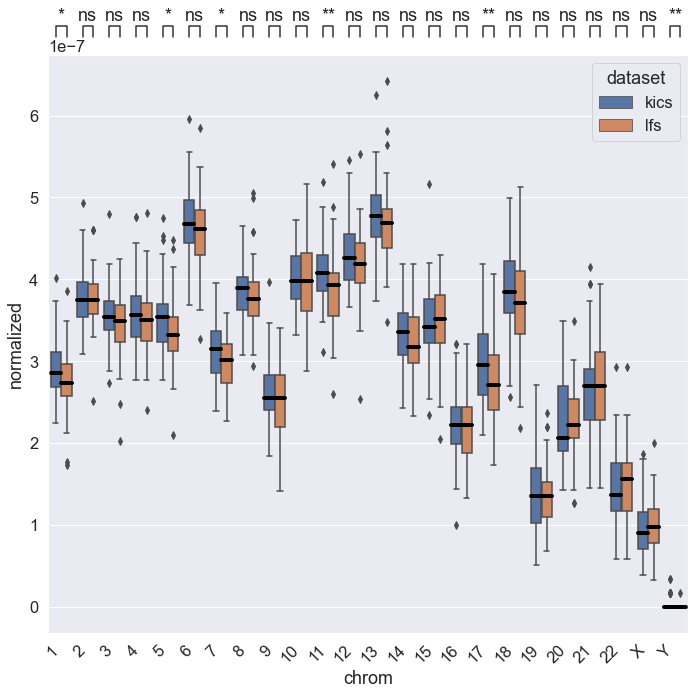

In [17]:
"""
For each TE class, create chromosome 2 specific boxplot (normalized by bp and not normalized)
ALU
"""

kicsChromAlt = pd.DataFrame(data={'ALT':kicsTEF['ALT'], 'id':kicsTEF['Samples_ID'], 'chrom':kicsTEF['SV_chrom']})
lfsChromAlt = pd.DataFrame(data={'ALT':lfsTEF['ALT'],'id':lfsTEF['Samples_ID'], 'chrom':lfsTEF['SV_chrom']})

AltKdf, normAltKdf = formatDataFrame(kicsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueK, uniqueLabels, 'ALU')
AltLdf, normAltLdf = formatDataFrame(lfsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueL, uniqueLabels, 'ALU')

AltKdf['dataset'] = 'kics'
AltLdf['dataset'] = 'lfs'
normAltKdf['dataset'] = 'kics'
normAltLdf['dataset'] = 'lfs'

AltMergedDf = pd.concat([AltKdf, AltLdf])
AltMergedDf.rename(columns = {0:'occ'}, inplace = True)
AltMergedDf.reset_index(inplace=True)
AltMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

##ALU

plt.rcParams["figure.figsize"] = [10, 10]
BoxGraphMulti(AltMergedDf, 'chrom', 'occ', 'dataset',orderList)

normAltDf = pd.concat([normAltKdf, normAltLdf])
normAltDf.reset_index(inplace=True)

BoxGraphMulti(normAltDf, 'chrom', 'normalized', 'dataset',orderList)
    

LFS
     chrom  occ dataset
3120     1  9.0     lfs
the outliers for 1 are:
None

Empty DataFrame
Columns: [chrom, occ, dataset]
Index: []
the outliers for 10 are:
None

     chrom  occ dataset
2378    11  1.0     lfs
3122    11  7.0     lfs
3170    11  1.0     lfs
the outliers for 11 are:
None

     chrom  occ dataset
1899    12  4.0     lfs
3123    12  4.0     lfs
3363    12  4.0     lfs
the outliers for 12 are:
None

Empty DataFrame
Columns: [chrom, occ, dataset]
Index: []
the outliers for 13 are:
None

     chrom  occ dataset
2597    14  0.0     lfs
3077    14  6.0     lfs
3101    14  0.0     lfs
the outliers for 14 are:
None

Empty DataFrame
Columns: [chrom, occ, dataset]
Index: []
the outliers for 15 are:
None

     chrom  occ dataset
2695    16  3.0     lfs
the outliers for 16 are:
None

Empty DataFrame
Columns: [chrom, occ, dataset]
Index: []
the outliers for 17 are:
None

     chrom  occ dataset
3225    18  5.0     lfs
the outliers for 18 are:
None

     chrom  occ dataset
231

14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.045e-01 U_stat=2.118e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:3.442e-01 U_stat=2.271e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.087e-01 U_stat=2.570e+03


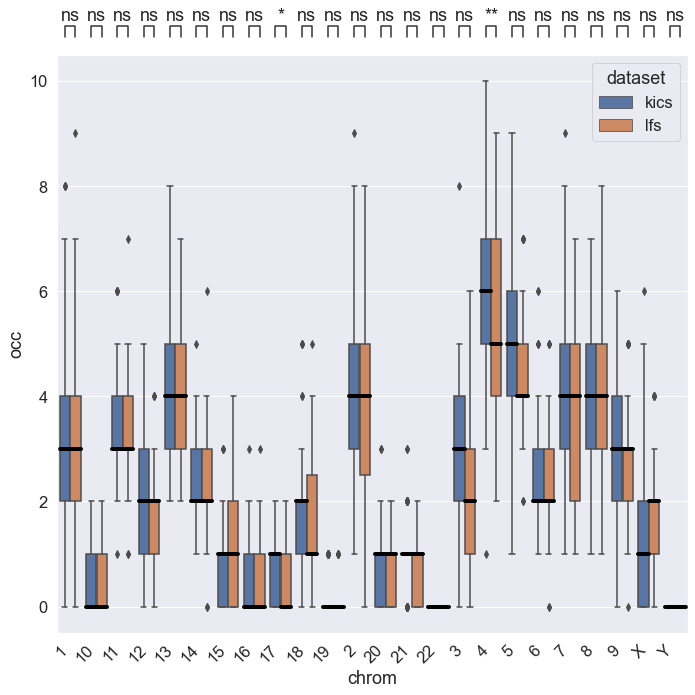

LFS
      index chrom    normalized dataset
1896      0     1  1.604810e-08     lfs
1920      0     1  4.012026e-09     lfs
1944      0     1  1.203608e-08     lfs
1968      0     1  2.006013e-08     lfs
1992      0     1  2.006013e-08     lfs
...     ...   ...           ...     ...
3264      0     1  1.604810e-08     lfs
3312      0     1  1.203608e-08     lfs
3336      0     1  2.006013e-08     lfs
3360      0     1  1.203608e-08     lfs
3384      0     1  1.604810e-08     lfs

[61 rows x 4 columns]
the outliers for 1 are:
None

      index chrom    normalized dataset
1897      1     2  1.644741e-08     lfs
1921      1     2  8.223705e-09     lfs
1945      1     2  2.055926e-08     lfs
1969      1     2  8.223705e-09     lfs
1993      1     2  1.233556e-08     lfs
...     ...   ...           ...     ...
3289      1     2  2.467112e-08     lfs
3313      1     2  2.055926e-08     lfs
3337      1     2  4.111853e-09     lfs
3361      1     2  8.223705e-09     lfs
3385      1     2  2.46

11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.081e-01 U_stat=2.609e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.856e-01 U_stat=2.798e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.968e-01 U_stat=2.581e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.045e-01 U_stat=2.118e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:3.442e-01 U_stat=2.271e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.087e-01 U_stat=2.570e+03
17_kics vs. 17_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.598e-02 U_stat=3.008e+03
18_kics vs. 18_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:4.856e-01 U_stat=2.654e+03
19_kics vs. 19_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.166e-01 U_stat=2.724e+03
20_kics vs. 20_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.836e-01 U_stat=2.549e+03
21_kics vs. 21_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.319e-02 U_stat=2.886e+03

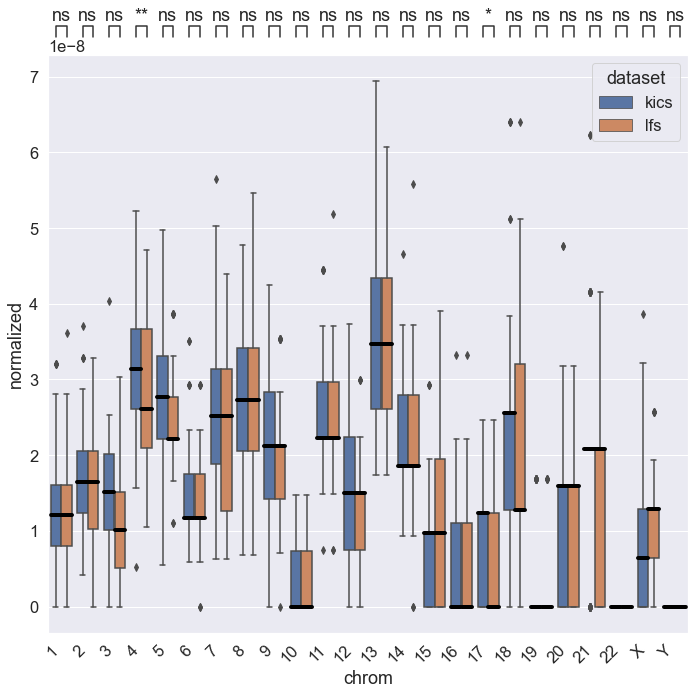

In [18]:
"""
Normalised and Regular box plot chrom specific for LINE1
"""

AltKdf, normAltKdf = formatDataFrame(kicsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueK, uniqueLabels, 'LINE1')
AltLdf, normAltLdf = formatDataFrame(lfsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueL, uniqueLabels, 'LINE1')

AltKdf['dataset'] = 'kics'
AltLdf['dataset'] = 'lfs'
normAltKdf['dataset'] = 'kics'
normAltLdf['dataset'] = 'lfs'

AltMergedDf = pd.concat([AltKdf, AltLdf])
AltMergedDf.rename(columns = {0:'occ'}, inplace = True)
AltMergedDf.reset_index(inplace=True)
AltMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

###LINE1

BoxGraphMulti(AltMergedDf, 'chrom', 'occ', 'dataset',orderList)

normAltDf = pd.concat([normAltKdf, normAltLdf])
normAltDf.reset_index(inplace=True)

BoxGraphMulti(normAltDf, 'chrom', 'normalized', 'dataset',orderList)

LFS
Empty DataFrame
Columns: [chrom, occ, dataset]
Index: []
the outliers for 1 are:
None

     chrom  occ dataset
2377    10  3.0     lfs
2761    10  3.0     lfs
3025    10  4.0     lfs
the outliers for 10 are:
None

Empty DataFrame
Columns: [chrom, occ, dataset]
Index: []
the outliers for 11 are:
None

Empty DataFrame
Columns: [chrom, occ, dataset]
Index: []
the outliers for 12 are:
None

Empty DataFrame
Columns: [chrom, occ, dataset]
Index: []
the outliers for 13 are:
None

     chrom  occ dataset
2165    14  5.0     lfs
3389    14  5.0     lfs
the outliers for 14 are:
None

     chrom  occ dataset
2478    15  3.0     lfs
the outliers for 15 are:
None

     chrom  occ dataset
2023    16  1.0     lfs
2071    16  1.0     lfs
2167    16  1.0     lfs
2311    16  1.0     lfs
2503    16  1.0     lfs
2527    16  1.0     lfs
2551    16  1.0     lfs
2599    16  2.0     lfs
2743    16  1.0     lfs
2983    16  1.0     lfs
3079    16  1.0     lfs
3127    16  1.0     lfs
3151    16  1.0     lfs


16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:4.303e-01 U_stat=2.638e+03


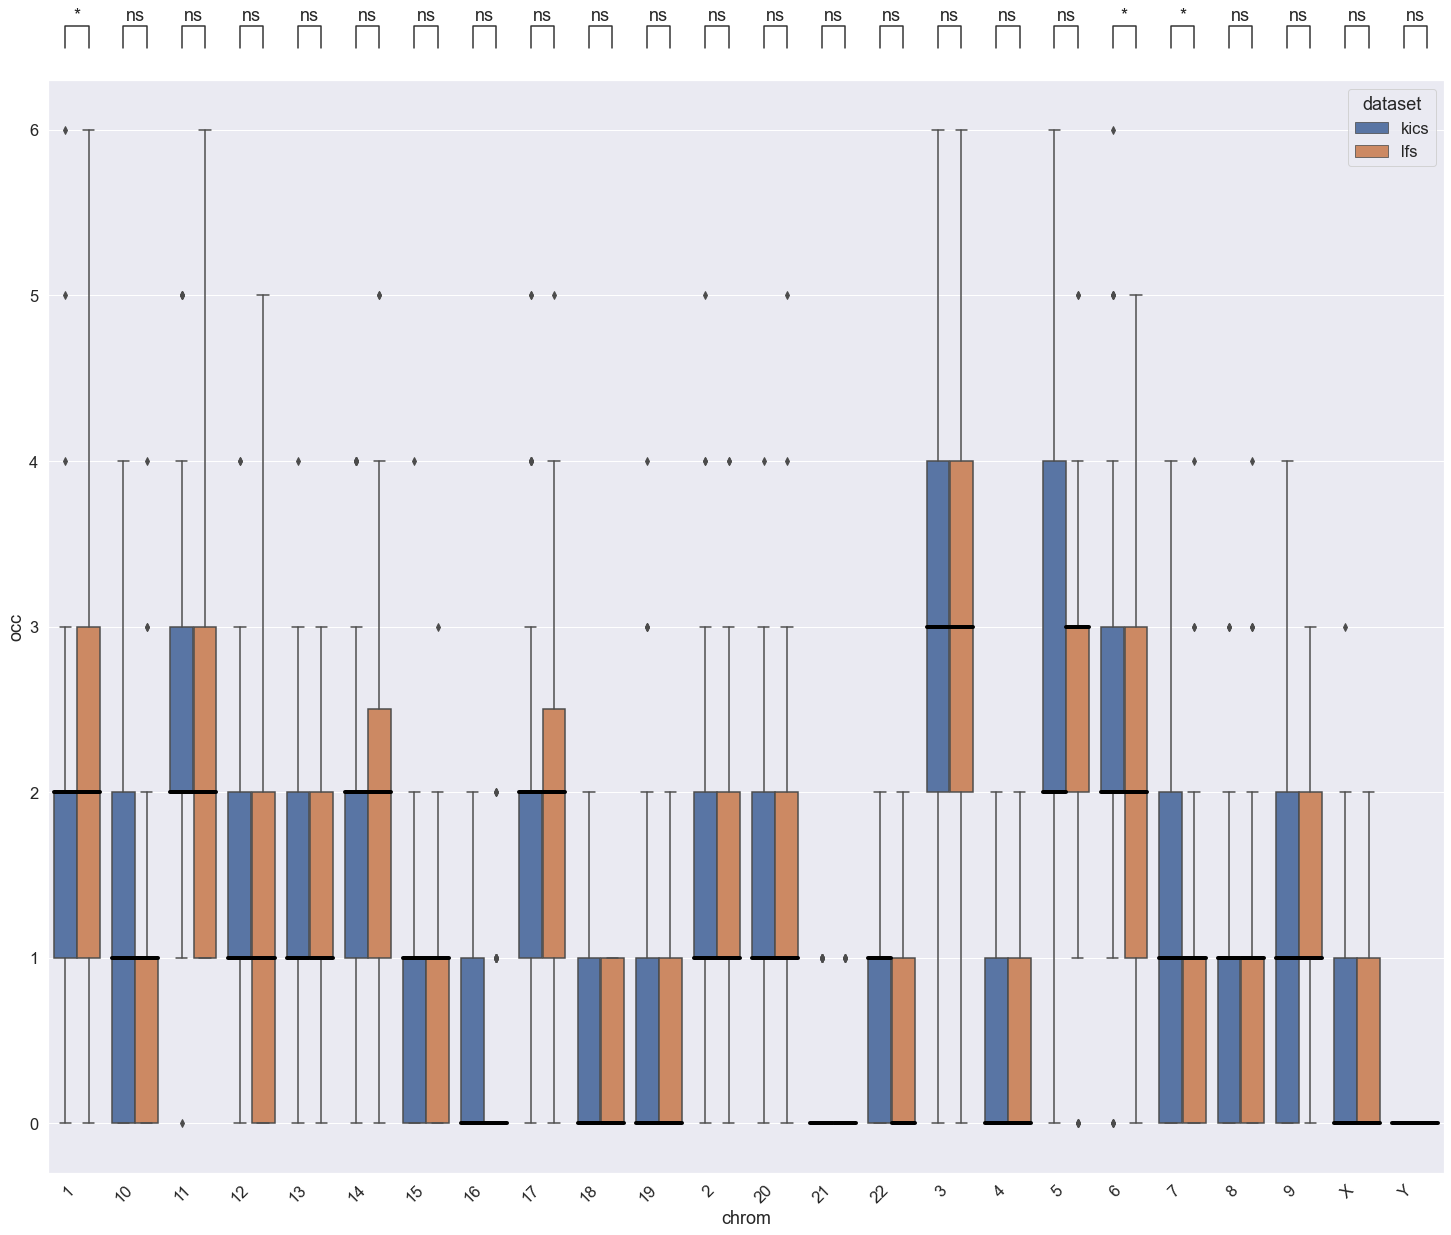

LFS
      index chrom    normalized dataset
1896      0     1  1.203608e-08     lfs
1920      0     1  8.024052e-09     lfs
1944      0     1  1.203608e-08     lfs
1968      0     1  8.024052e-09     lfs
1992      0     1  8.024052e-09     lfs
2016      0     1  1.203608e-08     lfs
2040      0     1  8.024052e-09     lfs
2064      0     1  1.203608e-08     lfs
2088      0     1  4.012026e-09     lfs
2112      0     1  1.203608e-08     lfs
2136      0     1  8.024052e-09     lfs
2160      0     1  1.203608e-08     lfs
2184      0     1  2.006013e-08     lfs
2208      0     1  4.012026e-09     lfs
2232      0     1  1.604810e-08     lfs
2280      0     1  8.024052e-09     lfs
2304      0     1  8.024052e-09     lfs
2328      0     1  1.203608e-08     lfs
2352      0     1  8.024052e-09     lfs
2376      0     1  4.012026e-09     lfs
2424      0     1  4.012026e-09     lfs
2448      0     1  1.604810e-08     lfs
2472      0     1  4.012026e-09     lfs
2496      0     1  1.604810e-08     

11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:9.847e-01 U_stat=2.494e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:5.928e-01 U_stat=2.614e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:2.842e-01 U_stat=2.244e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:3.131e-01 U_stat=2.256e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.268e-01 U_stat=2.411e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:4.303e-01 U_stat=2.638e+03
17_kics vs. 17_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.559e-01 U_stat=2.383e+03
18_kics vs. 18_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:4.533e-01 U_stat=2.648e+03
19_kics vs. 19_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:2.560e-01 U_stat=2.716e+03
20_kics vs. 20_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.196e-01 U_stat=2.404e+03
21_kics vs. 21_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.204e-01 U_stat=2.558e+03

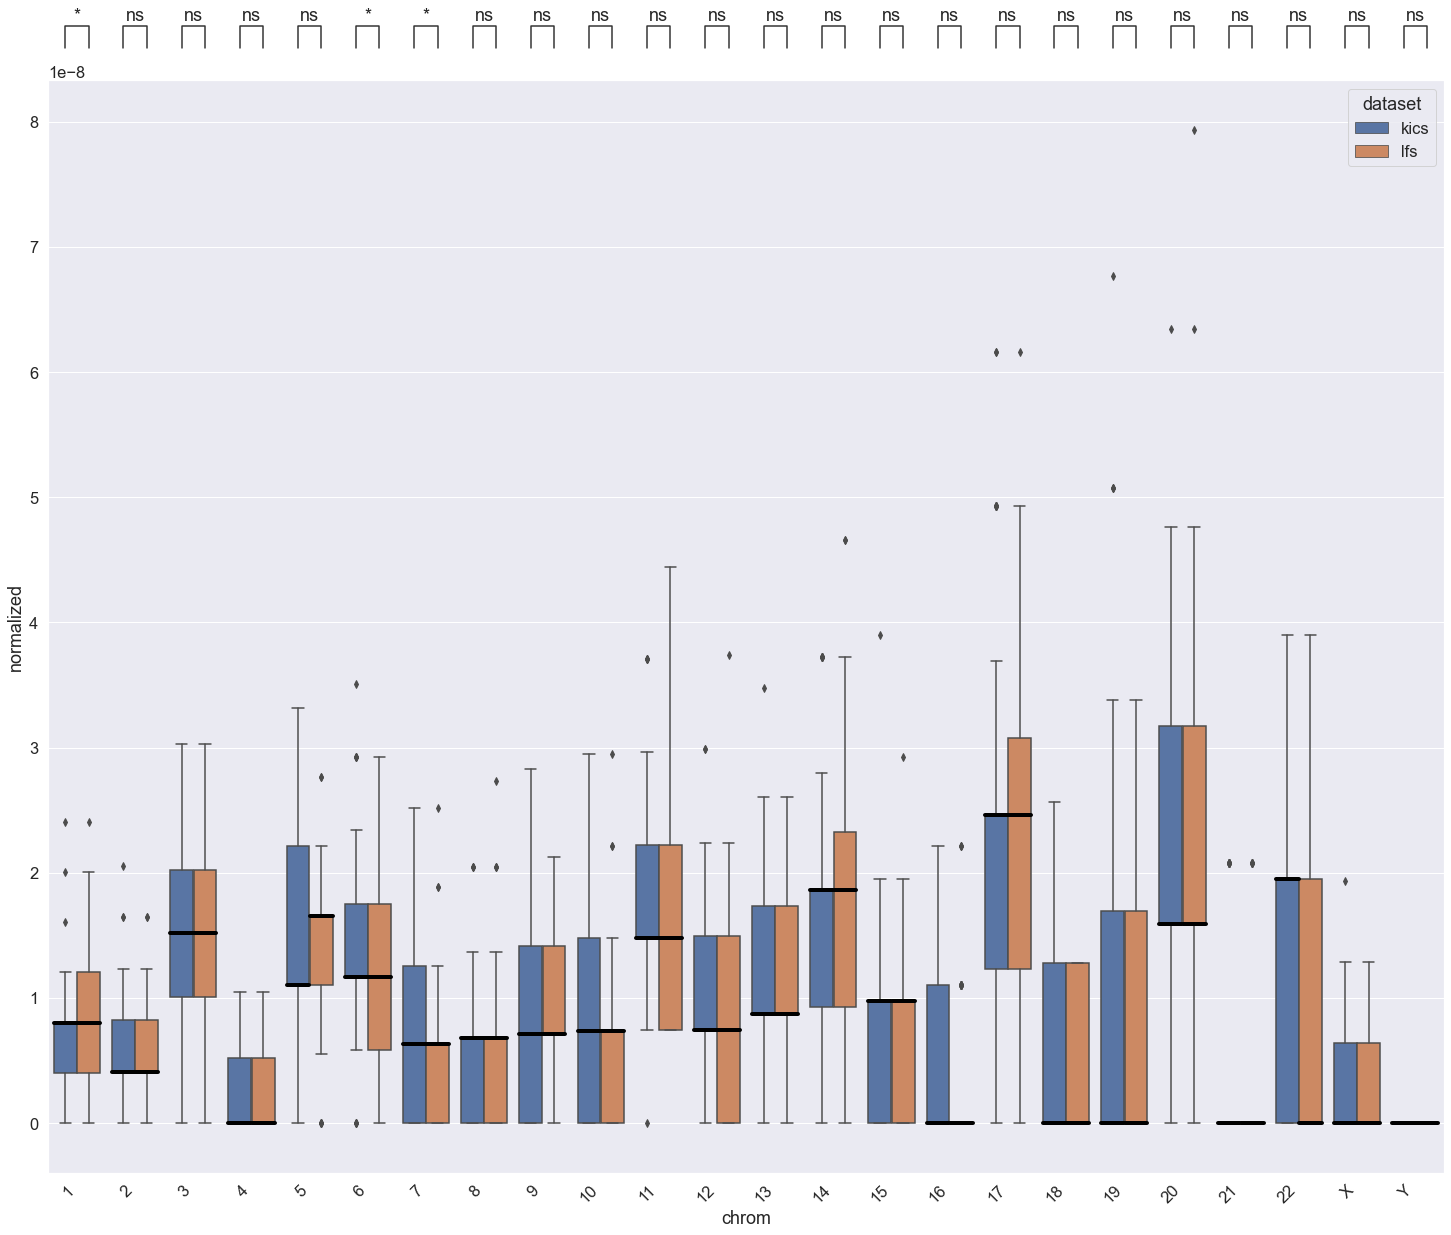

In [55]:
"""
Normalised and Regular box plot chrom specific for SVA
"""

AltKdf, normAltKdf = formatDataFrame(kicsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueK, uniqueLabels, 'SVA')
AltLdf, normAltLdf = formatDataFrame(lfsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueL, uniqueLabels, 'SVA')

AltKdf['dataset'] = 'kics'
AltLdf['dataset'] = 'lfs'
normAltKdf['dataset'] = 'kics'
normAltLdf['dataset'] = 'lfs'

AltMergedDf = pd.concat([AltKdf, AltLdf])
AltMergedDf.rename(columns = {0:'occ'}, inplace = True)
AltMergedDf.reset_index(inplace=True)
AltMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

BoxGraphMulti(AltMergedDf, 'chrom', 'occ', 'dataset',orderList)

normAltDf = pd.concat([normAltKdf, normAltLdf])
normAltDf.reset_index(inplace=True)

BoxGraphMulti(normAltDf, 'chrom', 'normalized', 'dataset',orderList)

LFS
     chrom    occ dataset
24       1   47.0     lfs
1104     1   46.0     lfs
1224     1  108.0     lfs
the outliers for 1 are:
None

Empty DataFrame
Columns: [chrom, occ, dataset]
Index: []
the outliers for 10 are:
None

     chrom   occ dataset
1106    11  39.0     lfs
1226    11  81.0     lfs
the outliers for 11 are:
None

     chrom   occ dataset
27      12  45.0     lfs
315     12  76.0     lfs
1107    12  35.0     lfs
the outliers for 12 are:
None

     chrom   occ dataset
316     13  80.0     lfs
700     13  75.0     lfs
1108    13  43.0     lfs
the outliers for 13 are:
None

Empty DataFrame
Columns: [chrom, occ, dataset]
Index: []
the outliers for 14 are:
None

    chrom   occ dataset
414    15  22.0     lfs
the outliers for 15 are:
None

Empty DataFrame
Columns: [chrom, occ, dataset]
Index: []
the outliers for 16 are:
None

     chrom   occ dataset
1160    17  37.0     lfs
1208    17  14.0     lfs
the outliers for 17 are:
None

     chrom   occ dataset
1113    18  18.0    

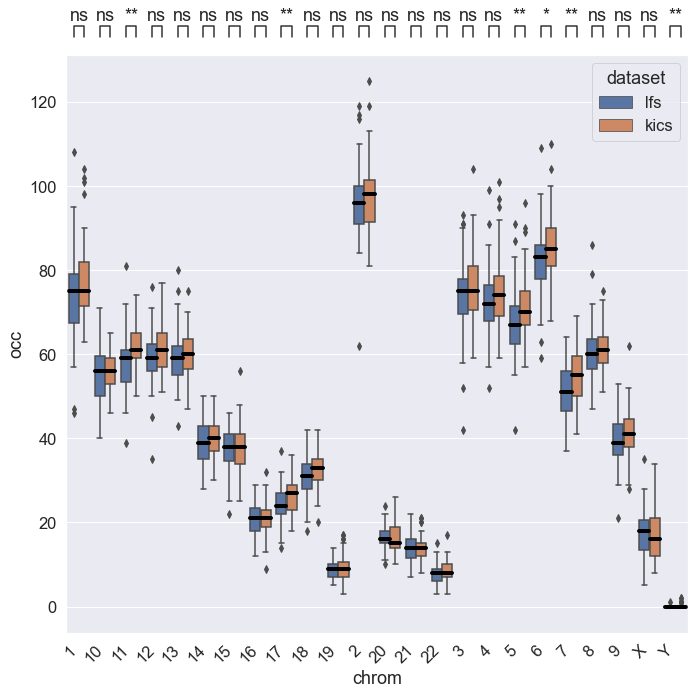

LFS
      index chrom    normalized dataset
0         0     1  2.928779e-07     lfs
24        0     1  1.885652e-07     lfs
48        0     1  3.049140e-07     lfs
72        0     1  3.249741e-07     lfs
96        0     1  2.928779e-07     lfs
...     ...   ...           ...     ...
1392      0     1  2.567697e-07     lfs
1416      0     1  2.688057e-07     lfs
1440      0     1  2.647937e-07     lfs
1464      0     1  2.848539e-07     lfs
1488      0     1  3.169501e-07     lfs

[63 rows x 4 columns]
the outliers for 1 are:
None

      index chrom    normalized dataset
1         1     2  3.824023e-07     lfs
25        1     2  3.659549e-07     lfs
49        1     2  3.947379e-07     lfs
73        1     2  4.235208e-07     lfs
97        1     2  4.276327e-07     lfs
...     ...   ...           ...     ...
1393      1     2  3.824023e-07     lfs
1417      1     2  3.741786e-07     lfs
1441      1     2  3.700667e-07     lfs
1465      1     2  4.111853e-07     lfs
1489      1     2  4.02

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_lfs vs. 10_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:5.278e-01 U_stat=2.334e+03
11_lfs vs. 11_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:2.340e-03 U_stat=1.750e+03
12_lfs vs. 12_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:8.964e-02 U_stat=2.076e+03
13_lfs vs. 13_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.282e-01 U_stat=2.118e+03
14_lfs vs. 14_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:6.655e-01 U_stat=2.383e+03
15_lfs vs. 15_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:5.727e-01 U_stat=2.626e+03
16_lfs vs. 16_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:6.369e-01 U_stat=2.374e+03
17_lfs vs. 17_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.659e-03 U_stat=1.801e+03
18_lfs vs. 18_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:6.746e-02 U_stat=2.044e+03


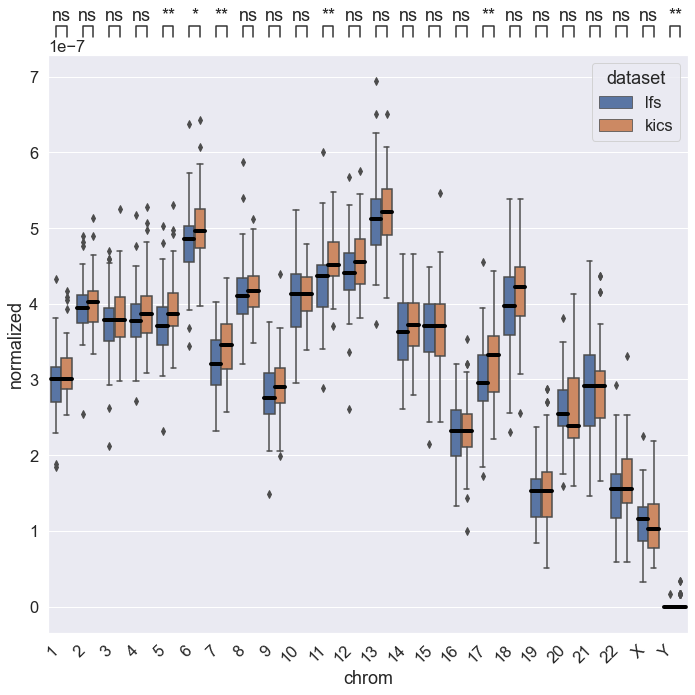

In [77]:
"""
Normalised and Regular box plot chrom specific for INS
"""

sns.set(font_scale=1.5)

newKdf, normKdf = formatDataFrame(kicsMore, grouping, numBPChrom, uniqueK, uniqueLabels, 'INS')
newLdf, normLdf = formatDataFrame(lfsMore, grouping, numBPChrom, uniqueL, uniqueLabels, 'INS')

newKdf['dataset'] = 'kics'
newLdf['dataset'] = 'lfs'
normKdf['dataset'] = 'kics'
normLdf['dataset'] = 'lfs'

newMergedDf = pd.concat([newLdf,newKdf])
newMergedDf.rename(columns = {0:'occ'}, inplace = True)
newMergedDf.reset_index(inplace=True)
newMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

BoxGraphMulti(newMergedDf, 'chrom', 'occ', 'dataset')

normMergedDf = pd.concat([normLdf, normKdf])
normMergedDf.reset_index(inplace=True)

BoxGraphMulti(normMergedDf, 'chrom', 'normalized', 'dataset')

# Copy and Pasted from Cancer Graphs

In [21]:
""" 
Sizing of boxplots/figures
"""
plt.rcParams["figure.figsize"] = [20, 15]


LFS
    Samples_ID age6  freq dataset
43        5567  >=6  1142     lfs
50  SJACT007_G  >=6   862     lfs
51  SJACT008_G  >=6   846     lfs
the outliers for >=6 are:
['5567', 'SJACT007_G', 'SJACT008_G']

    Samples_ID age6  freq dataset
6         2262   <6  1325     lfs
18        3356   <6  1347     lfs
19        3365   <6  1284     lfs
49  SJACT005_G   <6   718     lfs
the outliers for <6 are:
['2262', '3356', '3365', 'SJACT005_G']

Empty DataFrame
Columns: [Samples_ID, age6, freq, dataset]
Index: []
the outliers for Unaffected are:
[]

KICS
   Samples_ID age6  freq dataset
2      273308   <6  1948    kics
3      273309   <6  2164    kics
7      285045   <6  2142    kics
36     308436   <6  2262    kics
the outliers for <6 are:
['273308', '273309', '285045', '308436']

   Samples_ID age6  freq dataset
1      271116  >=6  3192    kics
6      284386  >=6  4516    kics
8      286909  >=6  2184    kics
20     297377  >=6  2166    kics
28     300683  >=6  2596    kics
34     305082  >=6  

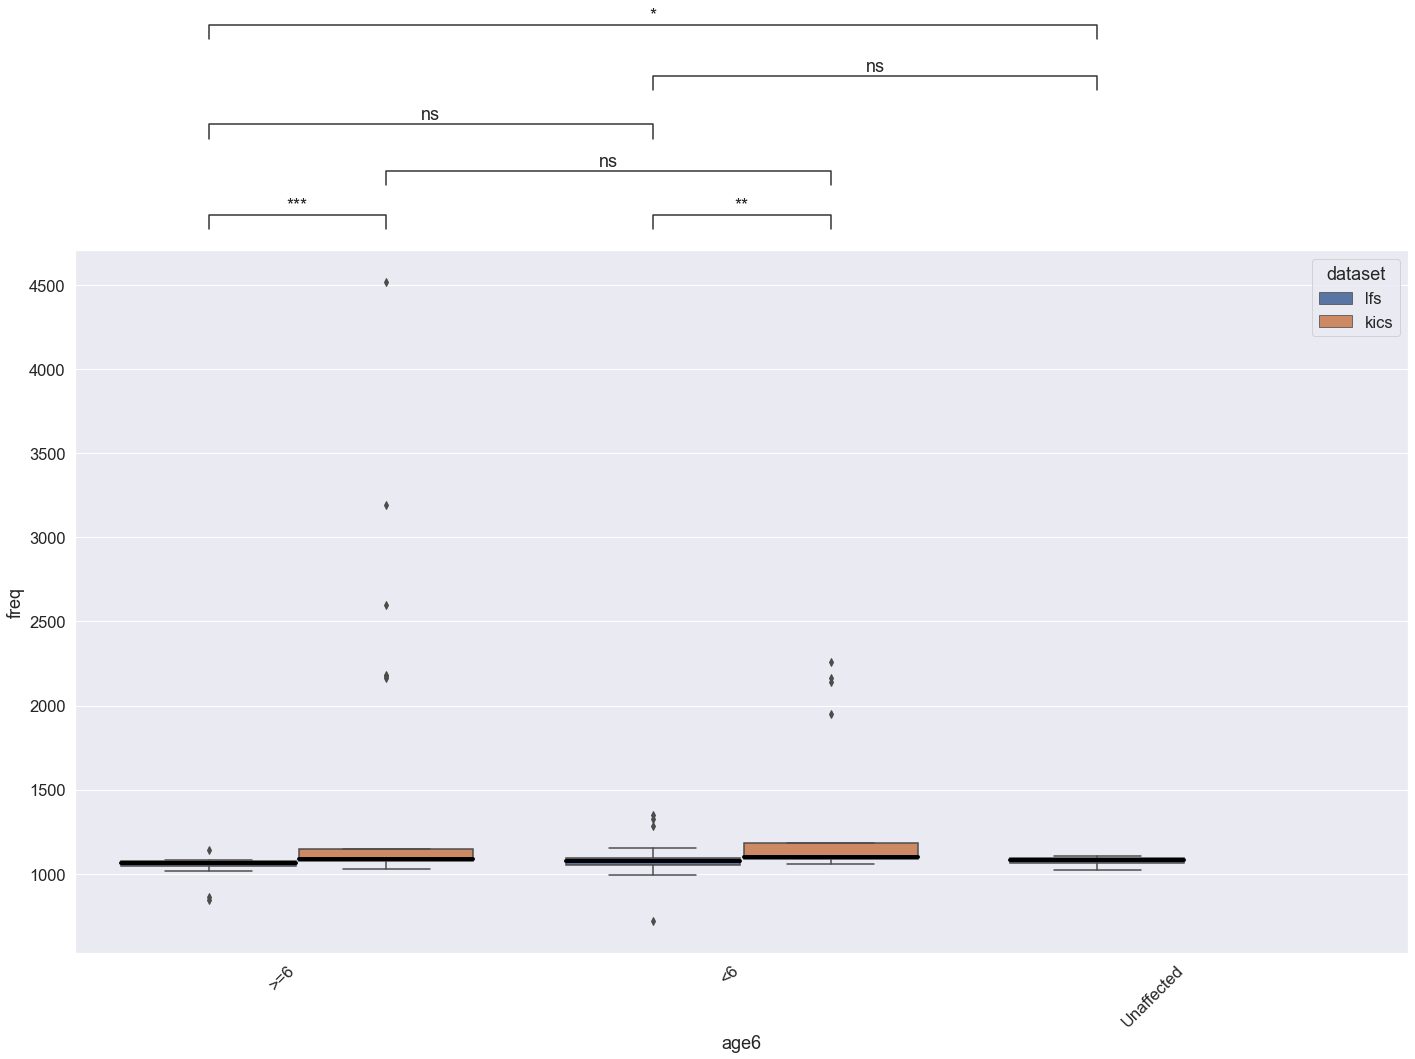

In [22]:
"""
Age of Onset graphs
"""
lfsCancer = bigLdf[bigLdf['tissue_type']!='Unaffected'].drop(['sample', 'tissue_type',
                                                             'cancer_diagnosis','SV_type'],axis=1)
lfsUnaffected = bigLdf[bigLdf['tissue_type']=='Unaffected'].drop(['sample', 'tissue_type',
                                                            'cancer_diagnosis','SV_type'],axis=1)

kicsCancer = bigKdf.drop(['abbv_id', 'SV_type', 'sample', 'tumour_class',
                          'tissue_type','cancer_diagnosis'],axis=1)

kicsCancer['ageofonset']=kicsCancer['ageofonset'].astype('float')

lfsCancer['age6'] = lfsCancer.apply(lambda row: ageOfOnsetLfs(row), axis=1)
kicsCancer['age6'] = kicsCancer.apply(lambda row: ageOfOnsetKics(row), axis=1)
lfsUnaffected['age6'] = 'Unaffected'

LCAlu = lfsCancer.loc[lfsCancer['ALT'] == 'ALU']
LUAlu = lfsUnaffected.loc[lfsUnaffected['ALT'] == 'ALU']
KCAlu = kicsCancer.loc[kicsCancer['ALT'] == 'ALU']

LCLine1 = lfsCancer.loc[lfsCancer['ALT'] == 'LINE1']
LULine1 = lfsUnaffected.loc[lfsUnaffected['ALT'] == 'LINE1']
KCLine1 = kicsCancer.loc[kicsCancer['ALT'] == 'LINE1']

LCSva = lfsCancer.loc[lfsCancer['ALT'] == 'SVA']
LUSva = lfsUnaffected.loc[lfsUnaffected['ALT'] == 'SVA']
KCSva = kicsCancer.loc[kicsCancer['ALT'] == 'SVA']

#create boxplot for "overall" cancer vs unaffected
mergeDFs(lfsCancer,lfsUnaffected, kicsCancer)

# Alu

LFS
    Samples_ID age6  freq dataset
43        5567  >=6  1065     lfs
50  SJACT007_G  >=6   808     lfs
51  SJACT008_G  >=6   797     lfs
the outliers for >=6 are:
['5567', 'SJACT007_G', 'SJACT008_G']

    Samples_ID age6  freq dataset
6         2262   <6  1229     lfs
18        3356   <6  1237     lfs
19        3365   <6  1172     lfs
49  SJACT005_G   <6   676     lfs
the outliers for <6 are:
['2262', '3356', '3365', 'SJACT005_G']

   Samples_ID        age6  freq dataset
4        2465  Unaffected  1027     lfs
8        3334  Unaffected   945     lfs
10       3806  Unaffected   950     lfs
the outliers for Unaffected are:
['2465', '3334', '3806']

KICS
   Samples_ID age6  freq dataset
2      273308   <6  1780    kics
3      273309   <6  1970    kics
7      285045   <6  1972    kics
36     308436   <6  2062    kics
the outliers for <6 are:
['273308', '273309', '285045', '308436']

   Samples_ID age6  freq dataset
1      271116  >=6  2961    kics
6      284386  >=6  4184    kics
8     

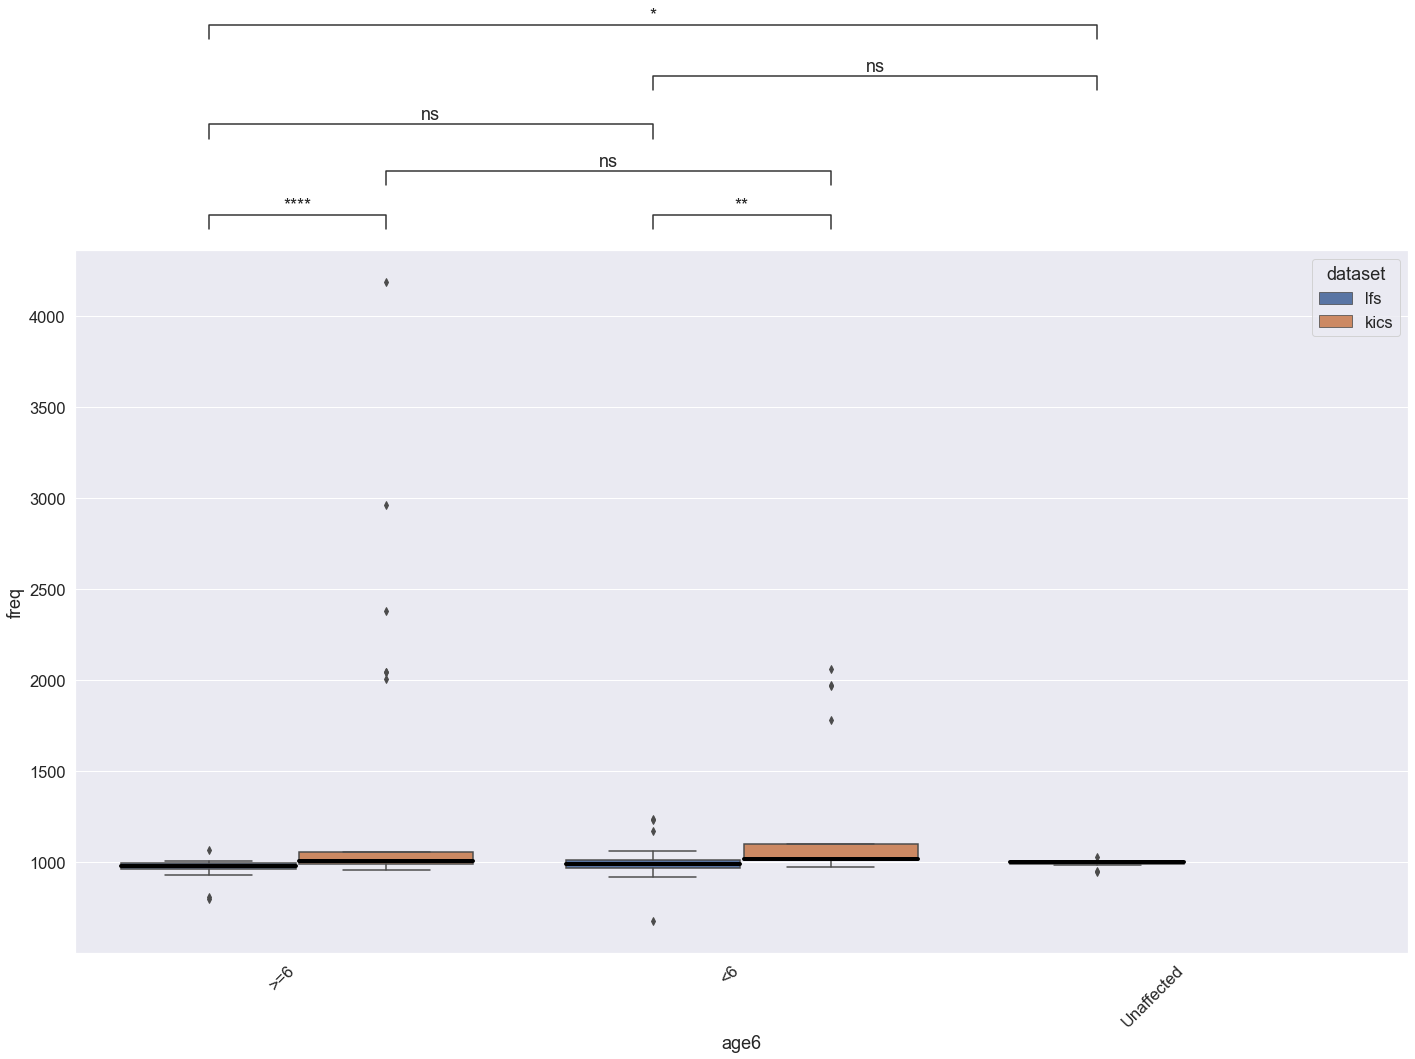

In [23]:
mergeDFs(LCAlu, LUAlu, KCAlu)

# Line1

LFS
Empty DataFrame
Columns: [Samples_ID, age6, freq, dataset]
Index: []
the outliers for >=6 are:
[]

    Samples_ID age6  freq dataset
6         2262   <6    66     lfs
18        3356   <6    73     lfs
19        3365   <6    73     lfs
49  SJACT005_G   <6    31     lfs
the outliers for <6 are:
['2262', '3356', '3365', 'SJACT005_G']

  Samples_ID        age6  freq dataset
7       3273  Unaffected    40     lfs
the outliers for Unaffected are:
['3273']

KICS
   Samples_ID age6  freq dataset
2      273308   <6   108    kics
3      273309   <6   124    kics
7      285045   <6   112    kics
36     308436   <6   126    kics
the outliers for <6 are:
['273308', '273309', '285045', '308436']

   Samples_ID age6  freq dataset
1      271116  >=6   150    kics
6      284386  >=6   212    kics
8      286909  >=6   104    kics
20     297377  >=6    96    kics
28     300683  >=6   132    kics
34     305082  >=6    94    kics
the outliers for >=6 are:
['271116', '284386', '286909', '297377', '30068

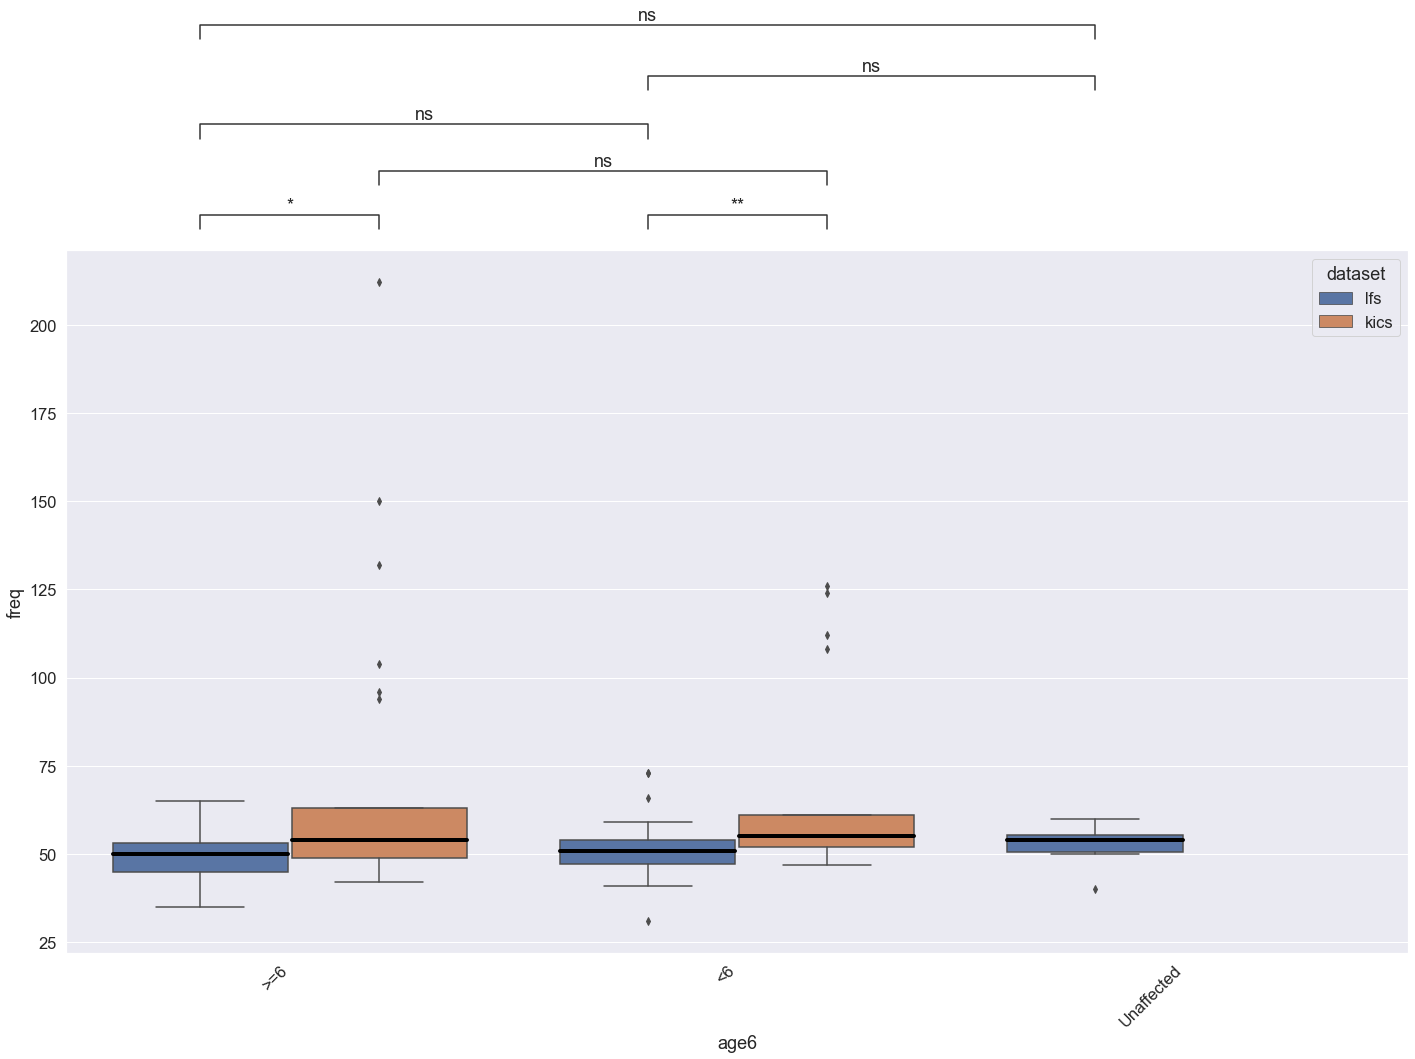

In [24]:
mergeDFs(LCLine1, LULine1, KCLine1)

# Sva

LFS
    Samples_ID age6  freq dataset
50  SJACT007_G  >=6    12     lfs
51  SJACT008_G  >=6    14     lfs
the outliers for >=6 are:
['SJACT007_G', 'SJACT008_G']

    Samples_ID age6  freq dataset
49  SJACT005_G   <6    11     lfs
the outliers for <6 are:
['SJACT005_G']

Empty DataFrame
Columns: [Samples_ID, age6, freq, dataset]
Index: []
the outliers for Unaffected are:
[]

KICS
   Samples_ID age6  freq dataset
2      273308   <6    60    kics
3      273309   <6    70    kics
7      285045   <6    58    kics
36     308436   <6    74    kics
the outliers for <6 are:
['273308', '273309', '285045', '308436']

   Samples_ID age6  freq dataset
1      271116  >=6    81    kics
6      284386  >=6   120    kics
20     297377  >=6    66    kics
28     300683  >=6    84    kics
the outliers for >=6 are:
['271116', '284386', '297377', '300683']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-

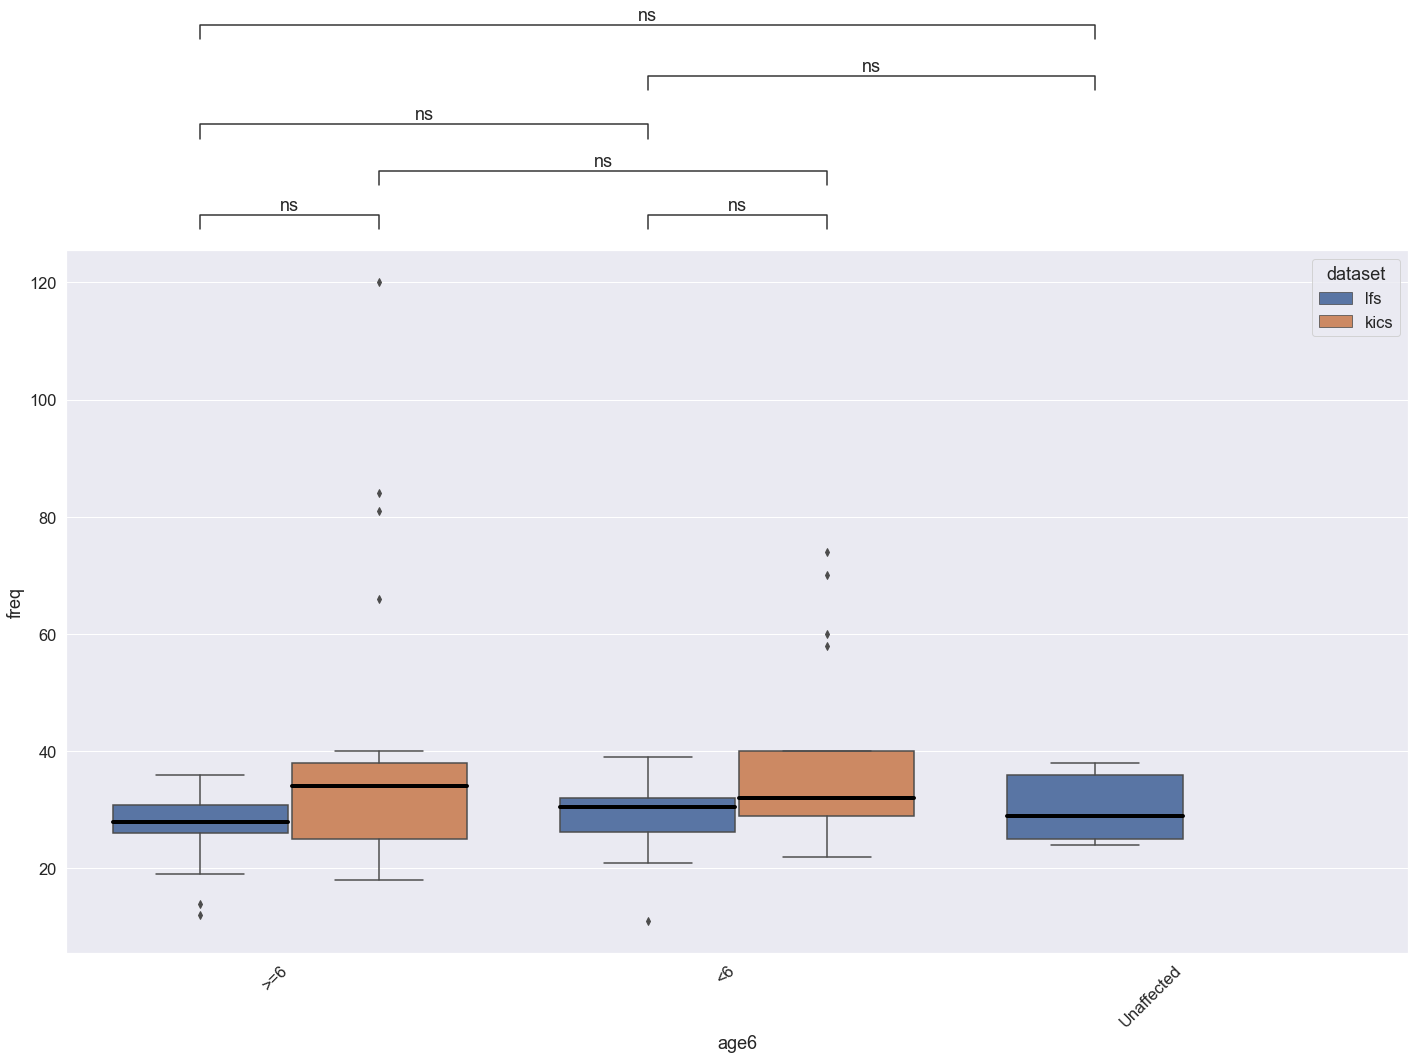

In [25]:
mergeDFs(LCSva, LUSva, KCSva)

  Samples_ID tissue_type     0
0       3356         CNS  1347
the outliers for CNS are:
['3356']

  Samples_ID  tissue_type     0
1       2262  Soft Tissue  1325
the outliers for Soft Tissue are:
['2262']

    Samples_ID tissue_type     0
2         3365     Adrenal  1284
60  SJACT007_G     Adrenal   862
61  SJACT008_G     Adrenal   846
62  SJACT005_G     Adrenal   718
the outliers for Adrenal are:
['3365', 'SJACT007_G', 'SJACT008_G', 'SJACT005_G']

Empty DataFrame
Columns: [Samples_ID, tissue_type, 0]
Index: []
the outliers for Unaffected are:
[]

Empty DataFrame
Columns: [Samples_ID, tissue_type, 0]
Index: []
the outliers for Bone are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:2.366e-01 U_stat=4.500e+01
Soft Tissue vs. Adrenal: Mann-Whitney-Wilcoxon test two-sided, P_val:6.695e-01

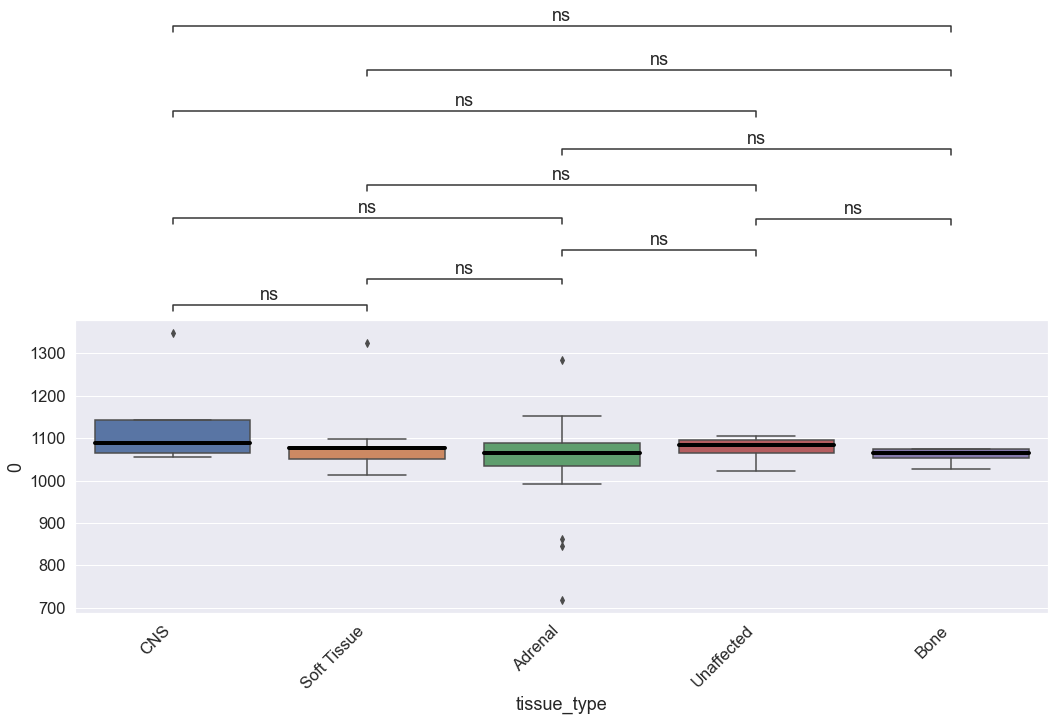

In [26]:
"""
Diagnosis and Tissue_Type comparisons intracohort
"""
#Overall
ldf = bigLdf.drop(['sample','SV_type', 'ageofonset'], axis=1)
kdf = bigKdf.drop(['sample','SV_type','abbv_id','ageofonset'],axis=1)

ldfGenTissue = ldf.drop(['ALT','cancer_diagnosis'],axis=1)
ldfGenTissue = ldfGenTissue.value_counts().to_frame().reset_index()

graphBoxGen('tissue_type', ldfGenTissue)

  Samples_ID cancer_diagnosis     0
1       2262              RMS  1325
the outliers for RMS are:
['2262']

    Samples_ID cancer_diagnosis     0
2         3365              ACC  1284
60  SJACT007_G              ACC   862
61  SJACT008_G              ACC   846
62  SJACT005_G              ACC   718
the outliers for ACC are:
['3365', 'SJACT007_G', 'SJACT008_G', 'SJACT005_G']

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, 0]
Index: []
the outliers for Unaffected are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS vs. ACC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.263e-01 U_stat=1.090e+02
ACC vs. Unaffected: Mann-Whitney-Wilcoxon test two-sided, P_val:1.709e-01 U_stat=8.050e+01
RMS vs. Unaffected: Mann-Whitney-Wilcoxon test two-sided, P_val:4.249e-01 U_stat=3.850e+01


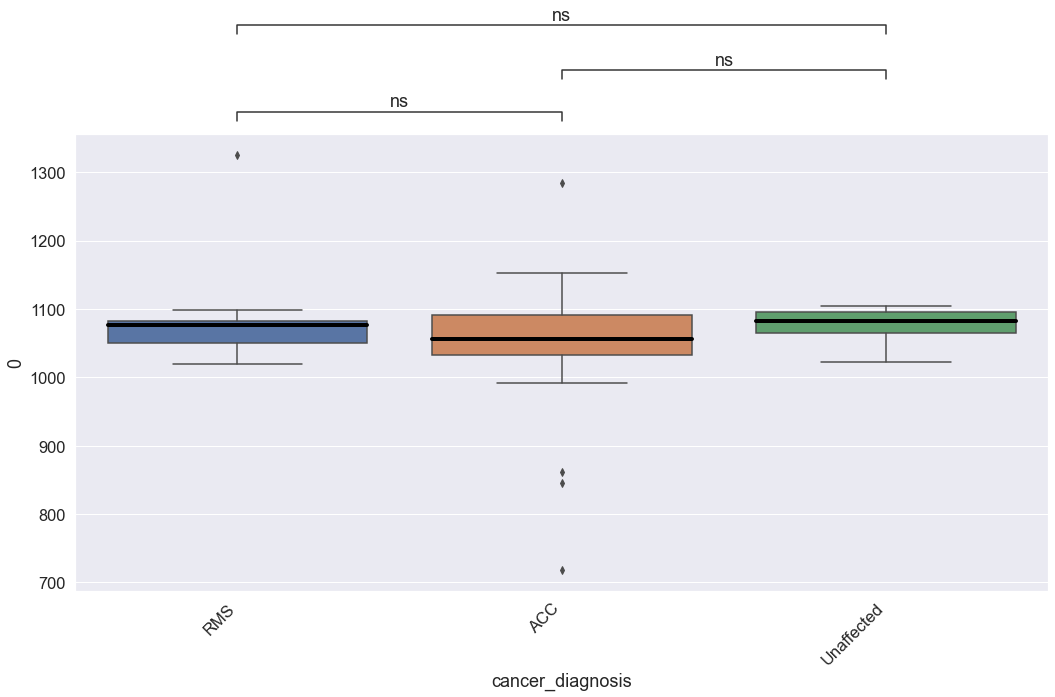

In [27]:
ldfGenDiag = ldf.drop(['ALT','tissue_type'],axis=1)
ldfGenDiag = ldfGenDiag.value_counts().to_frame().reset_index()

graphBoxGen('cancer_diagnosis', ldfGenDiag)

  Samples_ID  tumour_class  tissue_type     0
0     284386  SOLID TUMORS  Soft Tissue  4516
the outliers for Soft Tissue are:
['284386']

  Samples_ID  tumour_class tissue_type     0
1     271116    CNS TUMORS         CNS  3192
2     300683  SOLID TUMORS         CNS  2596
4     286909    CNS TUMORS         CNS  2184
the outliers for CNS are:
['271116', '300683', '286909']

  Samples_ID       tumour_class tissue_type     0
3     308436  LEUKEMIA/LYMPHOMA       Blood  2262
8     285045  LEUKEMIA/LYMPHOMA       Blood  2142
the outliers for Blood are:
['308436', '285045']

Empty DataFrame
Columns: [Samples_ID, tumour_class, tissue_type, 0]
Index: []
the outliers for US are:
[]

   Samples_ID  tumour_class tissue_type     0
10     299337  SOLID TUMORS       Other  1183
the outliers for Other are:
['299337']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Soft

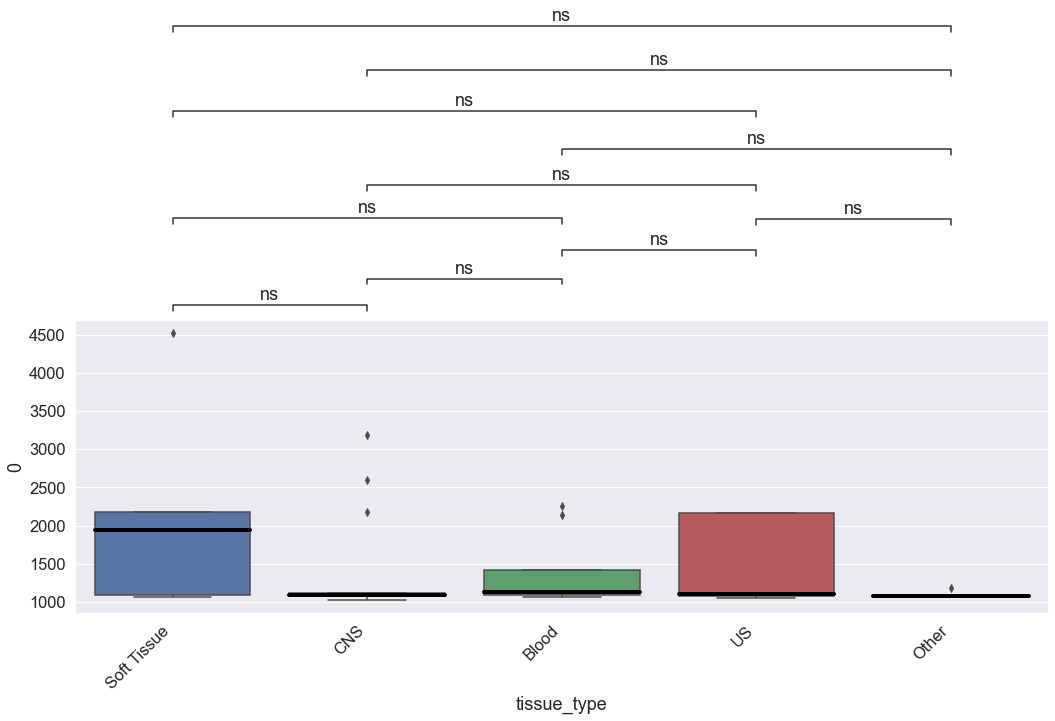

In [28]:
kdfGenTissue = kdf.drop(['ALT', 'cancer_diagnosis'], axis=1)
kdfGenTissue = kdfGenTissue.value_counts().to_frame().reset_index()
graphBoxGen('tissue_type', kdfGenTissue)

  Samples_ID  tumour_class cancer_diagnosis     0
0     284386  SOLID TUMORS              RMS  4516
the outliers for RMS are:
['284386']

  Samples_ID  tumour_class cancer_diagnosis     0
2     300683  SOLID TUMORS           Glioma  2596
4     286909    CNS TUMORS           Glioma  2184
the outliers for Glioma are:
['300683', '286909']

Empty DataFrame
Columns: [Samples_ID, tumour_class, cancer_diagnosis, 0]
Index: []
the outliers for Undifferentiated sarcoma are:
[]

   Samples_ID  tumour_class cancer_diagnosis     0
10     299337  SOLID TUMORS            Other  1183
the outliers for Other are:
['299337']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS vs. Glioma: Mann-Whitney-Wilcoxon test two-sided, P_val:1.996e-01 U_stat=4.600e+01
Glioma vs. Undifferentiated sarcoma: Mann-Whitney-Wilcoxon test two-sided, P_val:7.672e-01 U_stat=2.900e+01
Undiffere

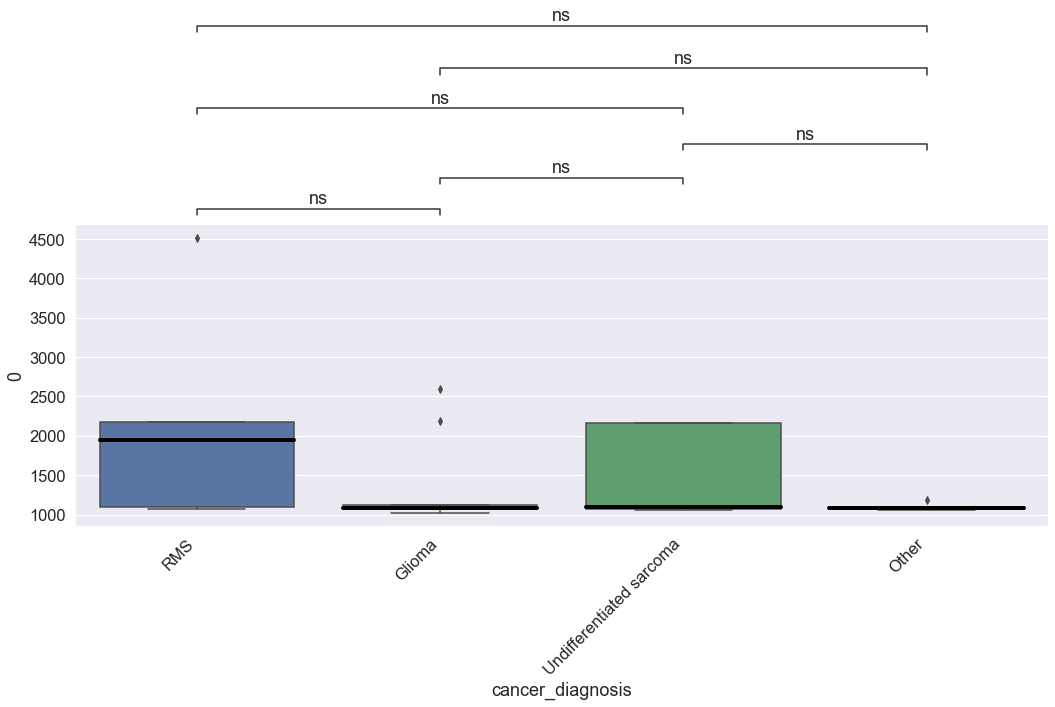

In [29]:
kdfGenDiag = kdf.drop(['ALT', 'tissue_type'], axis=1)
kdfGenDiag = kdfGenDiag.value_counts().to_frame().reset_index()
graphBoxGen('cancer_diagnosis', kdfGenDiag)

ALT Samples_ID tissue_type   ALU
1       271116         CNS  2961
8       286909         CNS  2044
28      300683         CNS  2380
the outliers for CNS are:
['271116', '286909', '300683']

ALT Samples_ID  tissue_type   ALU
6       284386  Soft Tissue  4184
the outliers for Soft Tissue are:
['284386']

Empty DataFrame
Columns: [Samples_ID, tissue_type, ALU]
Index: []
the outliers for US are:
[]

ALT Samples_ID tissue_type   ALU
7       285045       Blood  1972
36      308436       Blood  2062
the outliers for Blood are:
['285045', '308436']

ALT Samples_ID tissue_type   ALU
24      299337       Other  1099
the outliers for Other are:
['299337']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:3.153e-01 U_stat=2.550e+01
Soft Tissue vs. US: Mann-Whitney-Wilcoxon test two-sided, P_val:5.476e-01

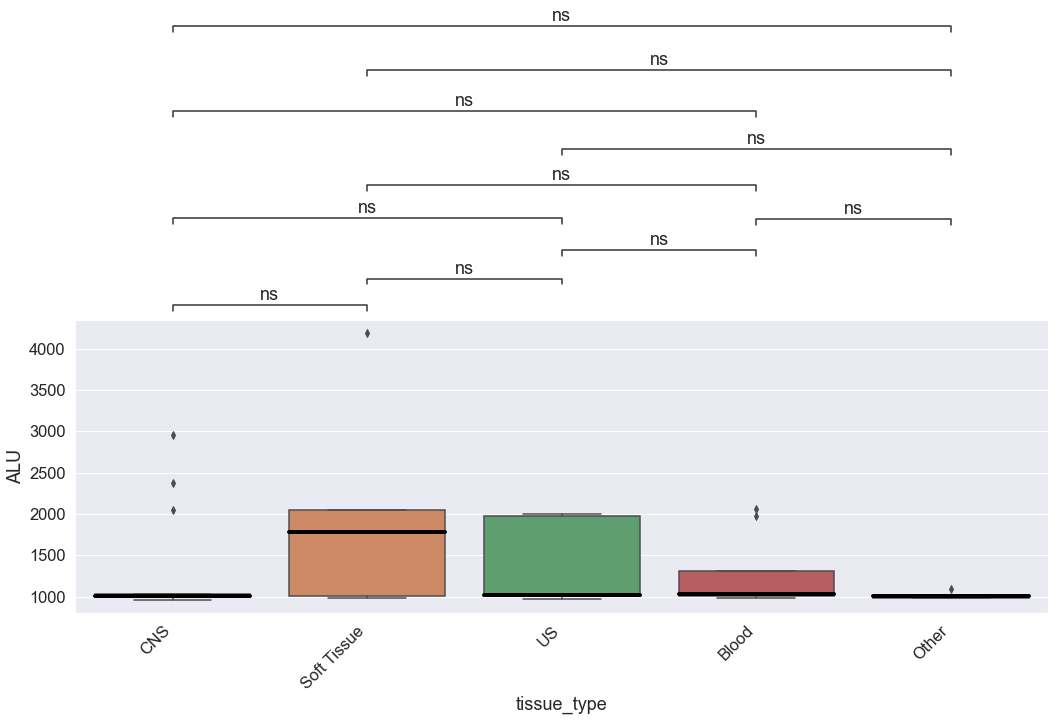

In [30]:
"""
TE class specific (ALU LINE1 SVA) Kics then Lfs
Tissue types graphed first
Diagnosis types graphed after
"""
kT = kdf.drop(['cancer_diagnosis'], axis=1).groupby(['Samples_ID', 'ALT','tissue_type']).size()
kT = kT.unstack(1)
lT = ldf.drop(['cancer_diagnosis'], axis=1).groupby(['Samples_ID', 'ALT', 'tissue_type']).size()
lT = lT.unstack(1)

kD = kdf.drop(['tissue_type'], axis=1).groupby(['Samples_ID', 'ALT','cancer_diagnosis']).size()
kD = kD.unstack(1)
lD = ldf.drop(['tissue_type'], axis=1).groupby(['Samples_ID', 'ALT','cancer_diagnosis']).size()
lD = lD.unstack(1)

graphBoxGen('tissue_type', kT.drop(['LINE1', 'SVA'], axis=1).reset_index(),'ALU')

ALT Samples_ID tissue_type  LINE1
1       271116         CNS    150
8       286909         CNS    104
28      300683         CNS    132
the outliers for CNS are:
['271116', '286909', '300683']

ALT Samples_ID  tissue_type  LINE1
6       284386  Soft Tissue    212
the outliers for Soft Tissue are:
['284386']

Empty DataFrame
Columns: [Samples_ID, tissue_type, LINE1]
Index: []
the outliers for US are:
[]

ALT Samples_ID tissue_type  LINE1
36      308436       Blood    126
the outliers for Blood are:
['308436']

Empty DataFrame
Columns: [Samples_ID, tissue_type, LINE1]
Index: []
the outliers for Other are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:4.885e-02 U_stat=1.450e+01
Soft Tissue vs. US: Mann-Whitney-Wilcoxon test two-sided, P_val:5.476e-01 U_stat=1.600e+01
US vs. Blood: Mann-Wh

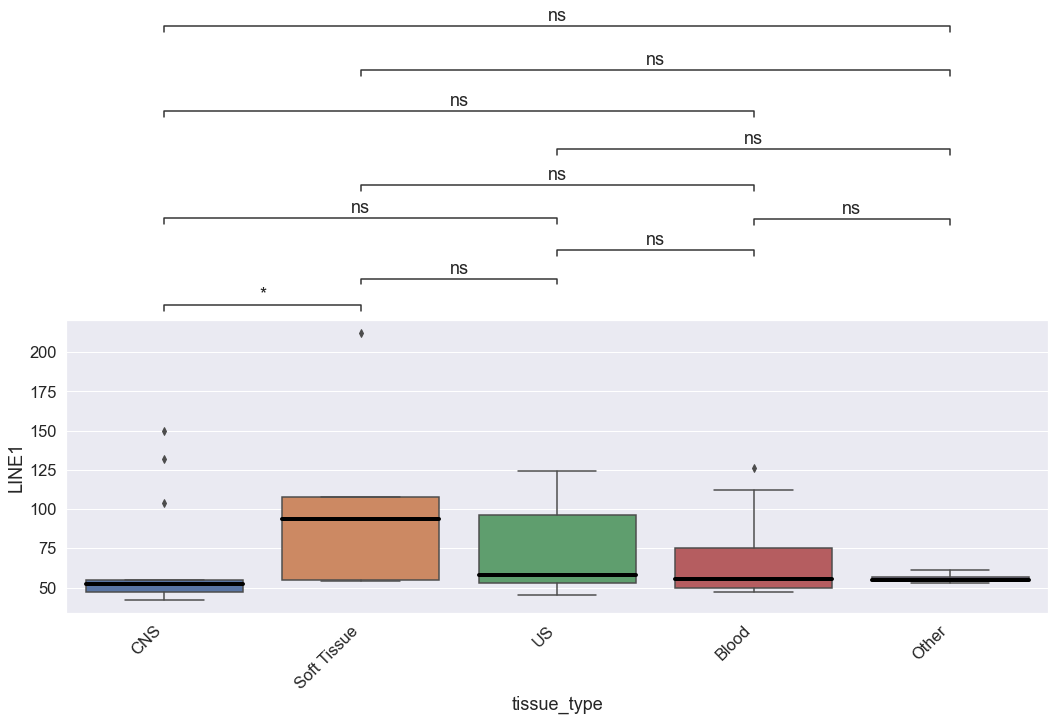

In [31]:
graphBoxGen('tissue_type', kT.drop(['ALU', 'SVA'], axis=1).reset_index(),'LINE1')

ALT Samples_ID tissue_type  SVA
1       271116         CNS   81
28      300683         CNS   84
the outliers for CNS are:
['271116', '300683']

ALT Samples_ID  tissue_type  SVA
6       284386  Soft Tissue  120
the outliers for Soft Tissue are:
['284386']

Empty DataFrame
Columns: [Samples_ID, tissue_type, SVA]
Index: []
the outliers for US are:
[]

ALT Samples_ID tissue_type  SVA
7       285045       Blood   58
36      308436       Blood   74
the outliers for Blood are:
['285045', '308436']

Empty DataFrame
Columns: [Samples_ID, tissue_type, SVA]
Index: []
the outliers for Other are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:2.554e-01 U_stat=2.400e+01
Soft Tissue vs. US: Mann-Whitney-Wilcoxon test two-sided, P_val:5.476e-01 U_stat=1.600e+01
US vs. Blood: Mann-Whitney-Wilcoxon test 

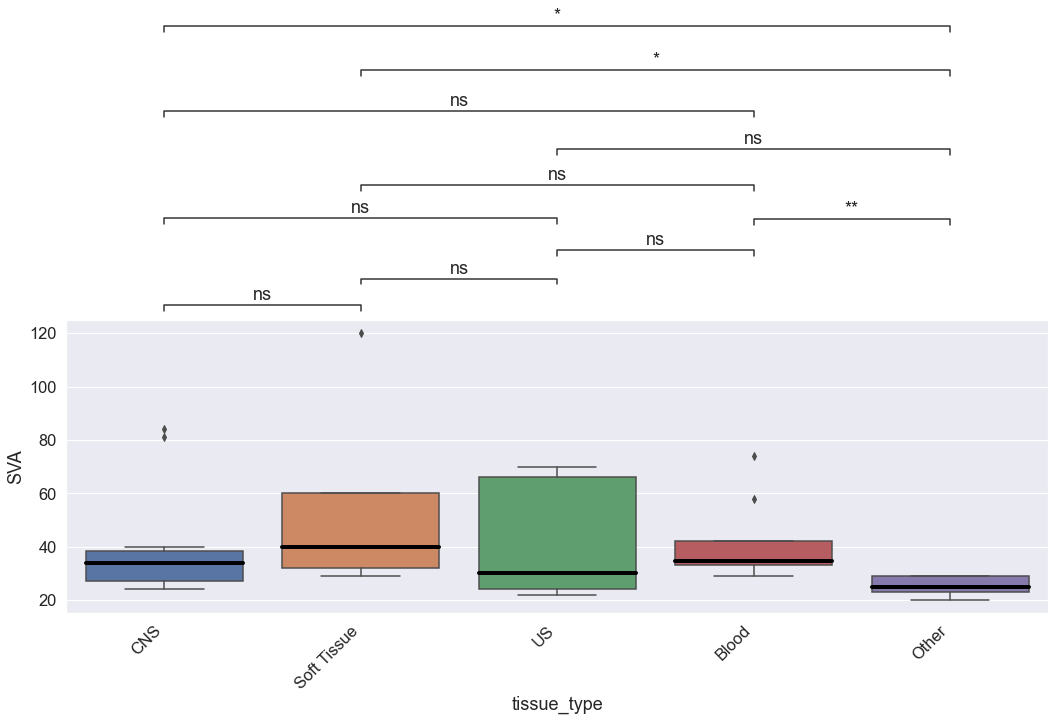

In [32]:
graphBoxGen('tissue_type', kT.drop(['LINE1', 'ALU'], axis=1).reset_index(),'SVA')

ALT  Samples_ID tissue_type   ALU
29         3365     Adrenal  1172
60   SJACT005_G     Adrenal   676
61   SJACT007_G     Adrenal   808
62   SJACT008_G     Adrenal   797
the outliers for Adrenal are:
['3365', 'SJACT005_G', 'SJACT007_G', 'SJACT008_G']

ALT Samples_ID  tissue_type   ALU
8         2262  Soft Tissue  1229
the outliers for Soft Tissue are:
['2262']

ALT Samples_ID tissue_type   ALU
14        2465  Unaffected  1027
26        3334  Unaffected   945
43        3806  Unaffected   950
the outliers for Unaffected are:
['2465', '3334', '3806']

ALT Samples_ID tissue_type   ALU
27        3356         CNS  1237
the outliers for CNS are:
['3356']

Empty DataFrame
Columns: [Samples_ID, tissue_type, ALU]
Index: []
the outliers for Bone are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Adrenal vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_

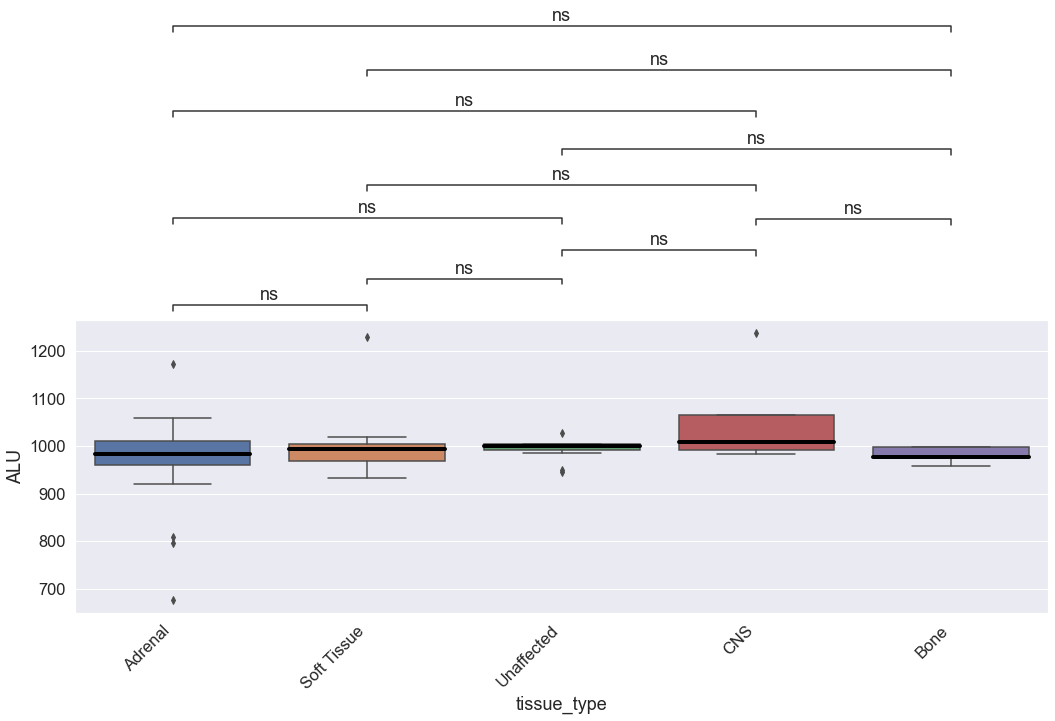

In [33]:
#lfs tissue
graphBoxGen('tissue_type', lT.drop(['LINE1', 'SVA'], axis=1).reset_index(),'ALU')

ALT  Samples_ID tissue_type  LINE1
29         3365     Adrenal     73
60   SJACT005_G     Adrenal     31
the outliers for Adrenal are:
['3365', 'SJACT005_G']

ALT Samples_ID  tissue_type  LINE1
8         2262  Soft Tissue     66
the outliers for Soft Tissue are:
['2262']

ALT Samples_ID tissue_type  LINE1
22        3273  Unaffected     40
the outliers for Unaffected are:
['3273']

ALT Samples_ID tissue_type  LINE1
27        3356         CNS     73
the outliers for CNS are:
['3356']

Empty DataFrame
Columns: [Samples_ID, tissue_type, LINE1]
Index: []
the outliers for Bone are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Adrenal vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:3.646e-01 U_stat=1.160e+02
Soft Tissue vs. Unaffected: Mann-Whitney-Wilcoxon test two-sided, P_val:4.324e-01 U_stat=5.750e+01
Unaffected vs. CNS: Mann-Whitney-Wilc

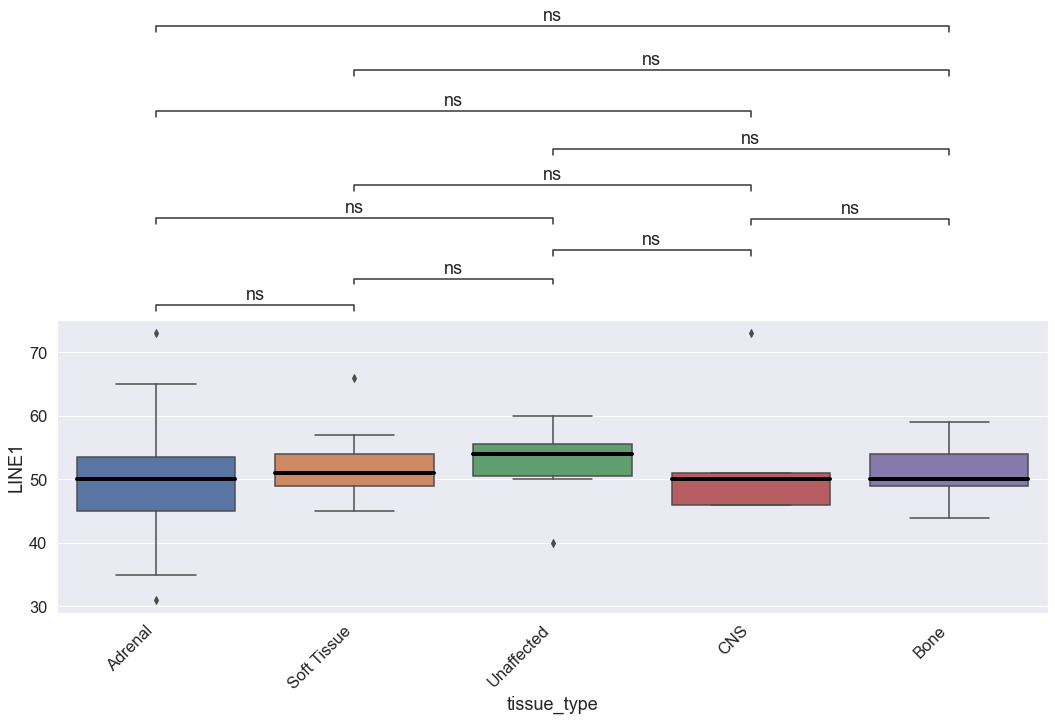

In [34]:
graphBoxGen('tissue_type', lT.drop(['SVA', 'ALU'], axis=1).reset_index(),'LINE1')

ALT  Samples_ID tissue_type  SVA
60   SJACT005_G     Adrenal   11
the outliers for Adrenal are:
['SJACT005_G']

ALT Samples_ID  tissue_type  SVA
1         1092  Soft Tissue   28
6         1843  Soft Tissue   28
9         2349  Soft Tissue   33
47        4227  Soft Tissue   35
49        4329  Soft Tissue   26
the outliers for Soft Tissue are:
['1092', '1843', '2349', '4227', '4329']

Empty DataFrame
Columns: [Samples_ID, tissue_type, SVA]
Index: []
the outliers for Unaffected are:
[]

ALT Samples_ID tissue_type  SVA
27        3356         CNS   37
the outliers for CNS are:
['3356']

ALT Samples_ID tissue_type  SVA
40        3688        Bone   33
57    PD13489b        Bone   19
the outliers for Bone are:
['3688', 'PD13489b']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Adrenal vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:3.017e-02 U_stat

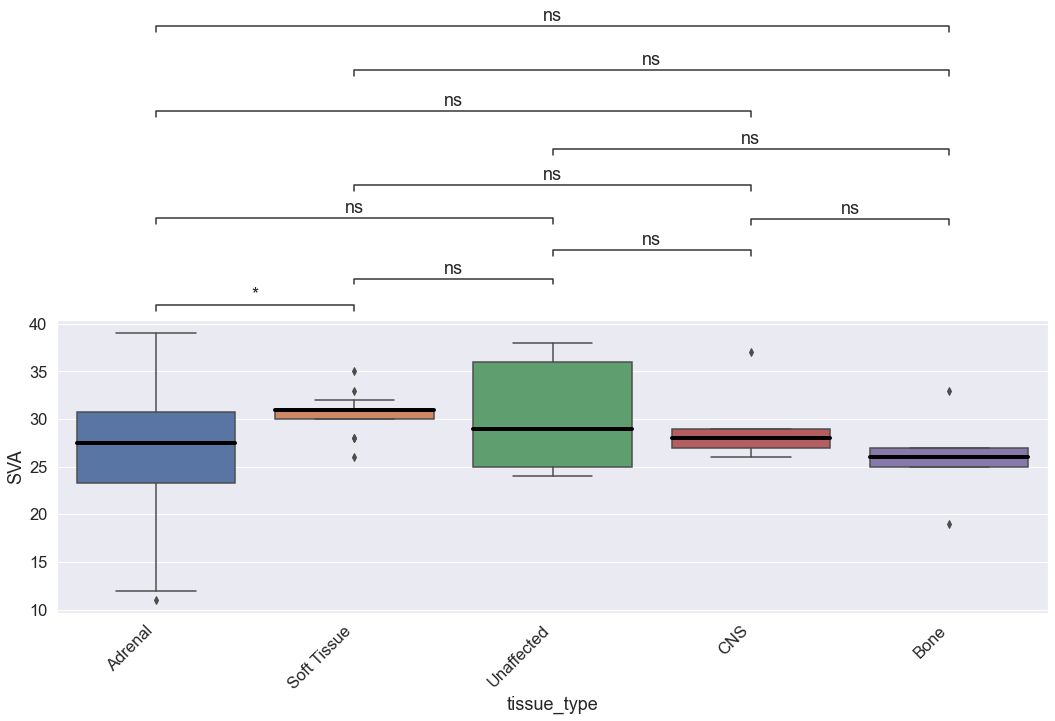

In [35]:
graphBoxGen('tissue_type', lT.drop(['LINE1', 'ALU'], axis=1).reset_index(),'SVA')

ALT Samples_ID cancer_diagnosis   ALU
8       286909           Glioma  2044
28      300683           Glioma  2380
the outliers for Glioma are:
['286909', '300683']

ALT Samples_ID cancer_diagnosis   ALU
6       284386              RMS  4184
the outliers for RMS are:
['284386']

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, ALU]
Index: []
the outliers for Undifferentiated sarcoma are:
[]

ALT Samples_ID cancer_diagnosis   ALU
24      299337            Other  1099
the outliers for Other are:
['299337']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma vs. RMS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.177e-01 U_stat=1.950e+01
RMS vs. Undifferentiated sarcoma: Mann-Whitney-Wilcoxon test two-sided, P_val:5.476e-01 U_stat=1.600e+01
Undifferentiated sarcoma vs. Other: Mann-Whitney-Wilcoxon test two-sided, P_val:5.476e-01 U_stat=1.600e+01
Gli

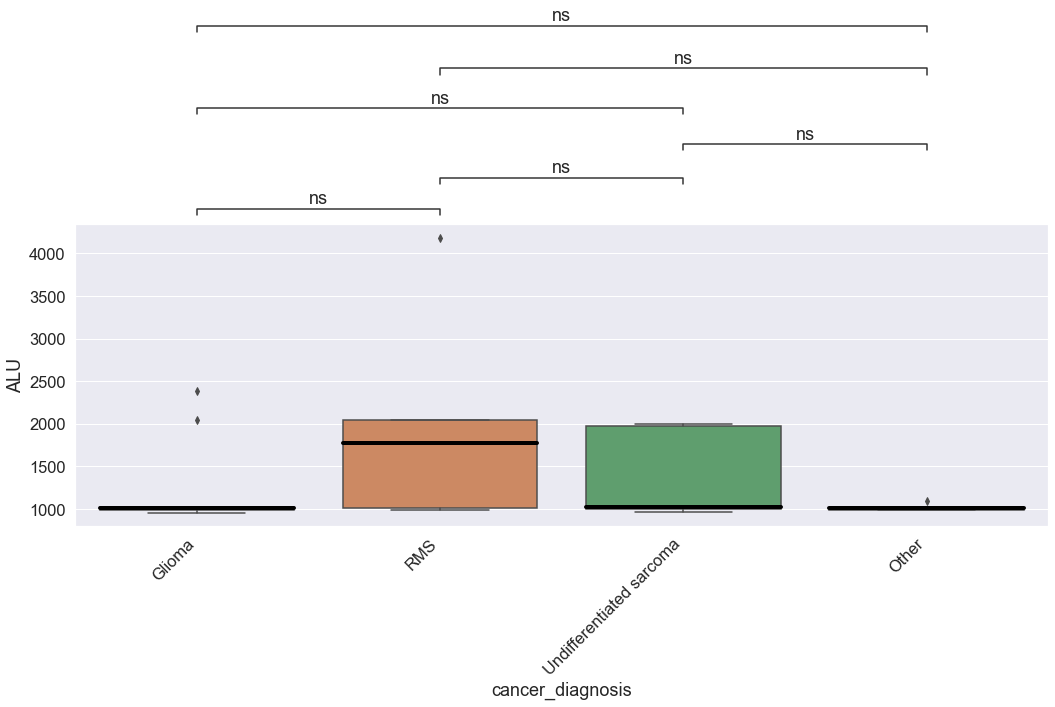

In [36]:
#kics Diagnosis
graphBoxGen('cancer_diagnosis', kD.drop(['LINE1', 'SVA'], axis=1).reset_index(),'ALU')

ALT Samples_ID cancer_diagnosis  LINE1
8       286909           Glioma    104
28      300683           Glioma    132
the outliers for Glioma are:
['286909', '300683']

ALT Samples_ID cancer_diagnosis  LINE1
6       284386              RMS    212
the outliers for RMS are:
['284386']

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, LINE1]
Index: []
the outliers for Undifferentiated sarcoma are:
[]

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, LINE1]
Index: []
the outliers for Other are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma vs. RMS: Mann-Whitney-Wilcoxon test two-sided, P_val:3.342e-02 U_stat=1.050e+01
RMS vs. Undifferentiated sarcoma: Mann-Whitney-Wilcoxon test two-sided, P_val:5.476e-01 U_stat=1.600e+01
Undifferentiated sarcoma vs. Other: Mann-Whitney-Wilcoxon test two-sided, P_val:7.533e-01 U_stat=1.450e+01
Glioma 

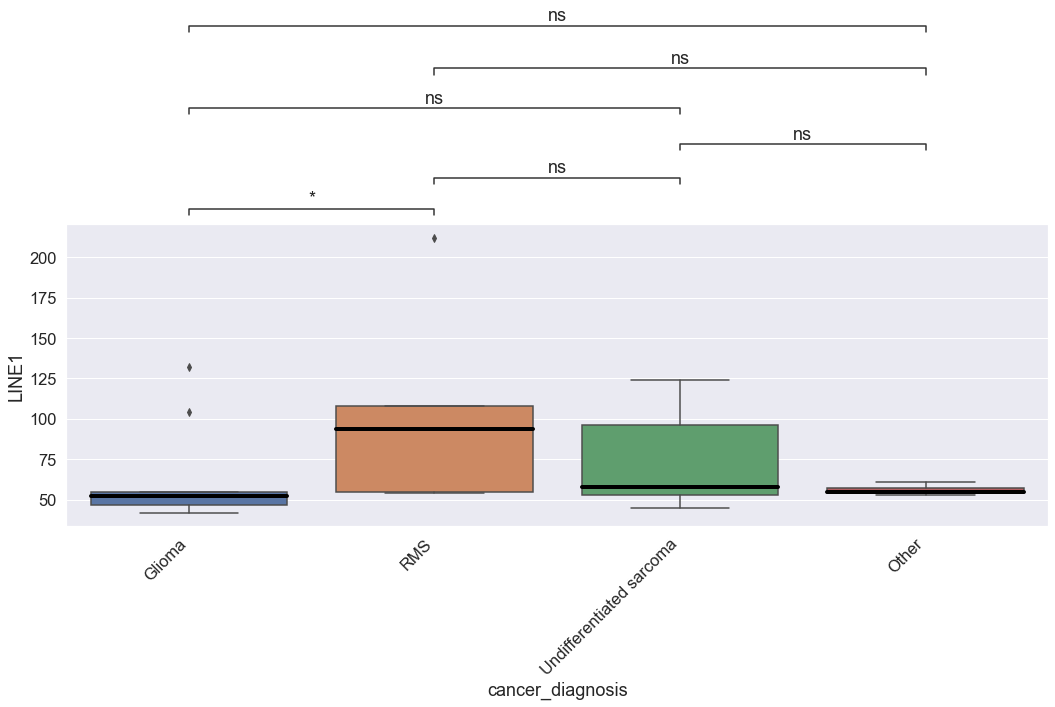

In [37]:
graphBoxGen('cancer_diagnosis', kD.drop(['ALU', 'SVA'], axis=1).reset_index(),'LINE1')

ALT Samples_ID cancer_diagnosis  SVA
28      300683           Glioma   84
the outliers for Glioma are:
['300683']

ALT Samples_ID cancer_diagnosis  SVA
6       284386              RMS  120
the outliers for RMS are:
['284386']

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, SVA]
Index: []
the outliers for Undifferentiated sarcoma are:
[]

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, SVA]
Index: []
the outliers for Other are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma vs. RMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.523e-01 U_stat=1.750e+01
RMS vs. Undifferentiated sarcoma: Mann-Whitney-Wilcoxon test two-sided, P_val:5.476e-01 U_stat=1.600e+01
Undifferentiated sarcoma vs. Other: Mann-Whitney-Wilcoxon test two-sided, P_val:2.948e-01 U_stat=1.800e+01
Glioma vs. Undifferentiated sarcoma: Mann-Whitney-Wilcoxon test two-

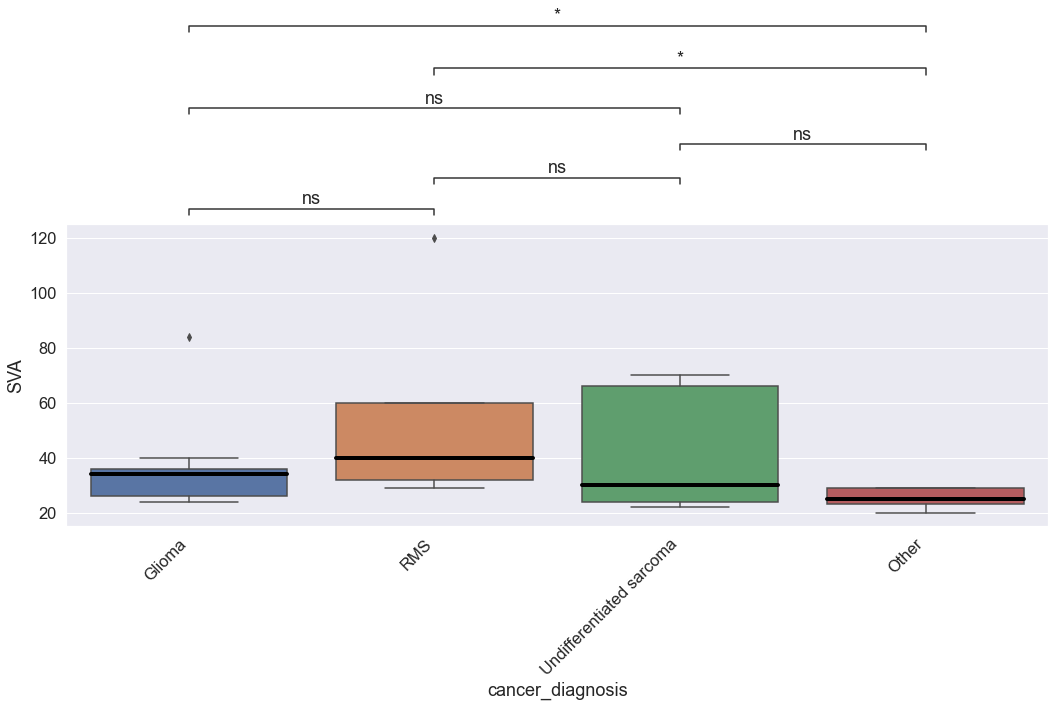

In [38]:
graphBoxGen('cancer_diagnosis', kD.drop(['LINE1', 'ALU'], axis=1).reset_index(),'SVA')

ALT Samples_ID cancer_diagnosis   ALU
8         2262              RMS  1229
the outliers for RMS are:
['2262']

ALT Samples_ID cancer_diagnosis   ALU
14        2465       Unaffected  1027
26        3334       Unaffected   945
43        3806       Unaffected   950
the outliers for Unaffected are:
['2465', '3334', '3806']

ALT  Samples_ID cancer_diagnosis   ALU
29         3365              ACC  1172
60   SJACT005_G              ACC   676
61   SJACT007_G              ACC   808
62   SJACT008_G              ACC   797
the outliers for ACC are:
['3365', 'SJACT005_G', 'SJACT007_G', 'SJACT008_G']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS vs. Unaffected: Mann-Whitney-Wilcoxon test two-sided, P_val:8.189e-01 U_stat=4.600e+01
Unaffected vs. ACC: Mann-Whitney-Wilcoxon test two-sided, P_val:3.826e-01 U_stat=1.380e+02
RMS vs. ACC: Mann-Whitney-Wilcoxon test t

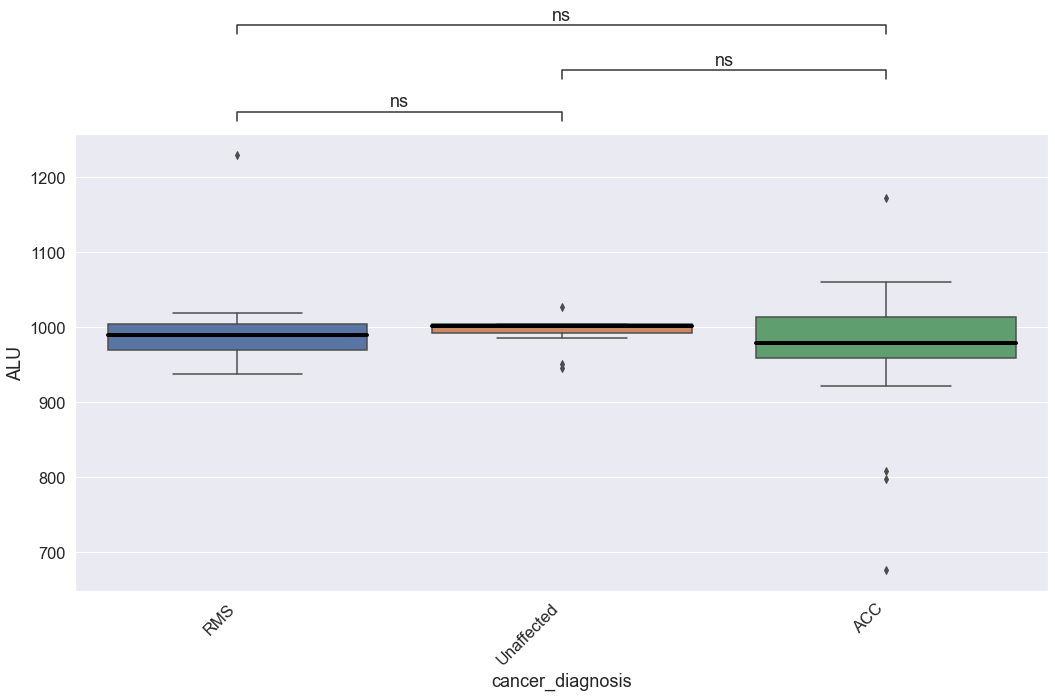

In [39]:
graphBoxGen('cancer_diagnosis', lD.drop(['LINE1', 'SVA'], axis=1).reset_index(),'ALU')

ALT Samples_ID cancer_diagnosis  LINE1
8         2262              RMS     66
the outliers for RMS are:
['2262']

ALT Samples_ID cancer_diagnosis  LINE1
22        3273       Unaffected     40
the outliers for Unaffected are:
['3273']

ALT Samples_ID cancer_diagnosis  LINE1
29        3365              ACC     73
the outliers for ACC are:
['3365']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS vs. Unaffected: Mann-Whitney-Wilcoxon test two-sided, P_val:5.417e-01 U_stat=4.100e+01
Unaffected vs. ACC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.575e-01 U_stat=1.515e+02
RMS vs. ACC: Mann-Whitney-Wilcoxon test two-sided, P_val:4.821e-01 U_stat=1.105e+02


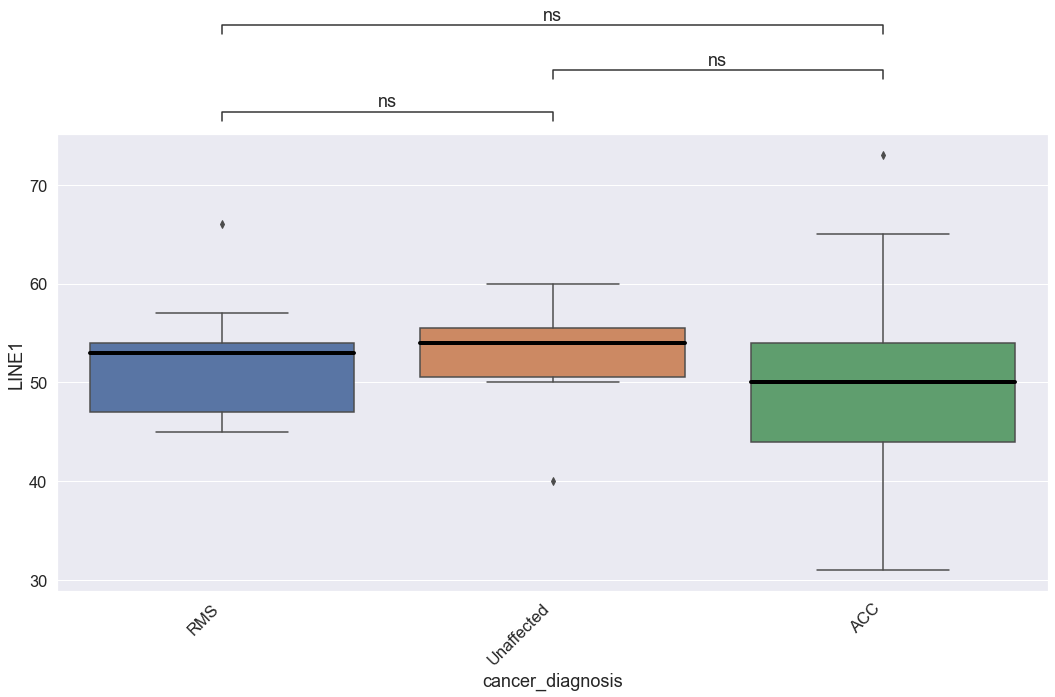

In [40]:
graphBoxGen('cancer_diagnosis', lD.drop(['ALU', 'SVA'], axis=1).reset_index(),'LINE1')

ALT Samples_ID cancer_diagnosis  SVA
47        4227              RMS   35
49        4329              RMS   26
the outliers for RMS are:
['4227', '4329']

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, SVA]
Index: []
the outliers for Unaffected are:
[]

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, SVA]
Index: []
the outliers for ACC are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS vs. Unaffected: Mann-Whitney-Wilcoxon test two-sided, P_val:4.219e-01 U_stat=6.050e+01
Unaffected vs. ACC: Mann-Whitney-Wilcoxon test two-sided, P_val:3.012e-01 U_stat=1.420e+02
RMS vs. ACC: Mann-Whitney-Wilcoxon test two-sided, P_val:3.238e-02 U_stat=1.420e+02


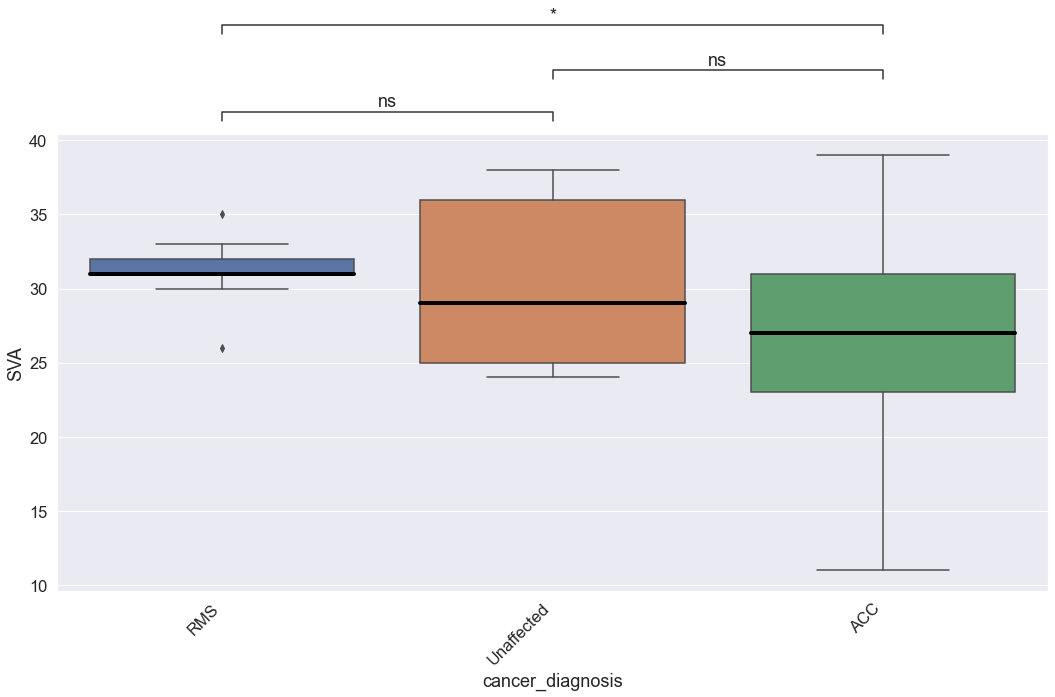

In [41]:
graphBoxGen('cancer_diagnosis', lD.drop(['LINE1', 'ALU'], axis=1).reset_index(),'SVA')

ALL
Empty DataFrame
Columns: [Samples_ID, freq, dataset]
Index: []
the outliers for unaffected are:
[]

    Samples_ID  freq dataset
0         3356  1347  cancer
1         2262  1325  cancer
2         3365  1284  cancer
3         3503  1152  cancer
4         5567  1142  cancer
48  SJACT002_G   992  cancer
49  SJACT007_G   862  cancer
50  SJACT008_G   846  cancer
51  SJACT005_G   718  cancer
the outliers for cancer are:
['3356', '2262', '3365', '3503', '5567', 'SJACT002_G', 'SJACT007_G', 'SJACT008_G', 'SJACT005_G']

ALU
   Samples_ID  ALT  freq     dataset
0        2465  ALU  1027  unaffected
9        3806  ALU   950  unaffected
10       3334  ALU   945  unaffected
the outliers for unaffected are:
['2465', '3806', '3334']

    Samples_ID  ALT  freq dataset
0         3356  ALU  1237  cancer
1         2262  ALU  1229  cancer
2         3365  ALU  1172  cancer
3         5567  ALU  1065  cancer
4         3503  ALU  1060  cancer
49  SJACT007_G  ALU   808  cancer
50  SJACT008_G  ALU   797  can

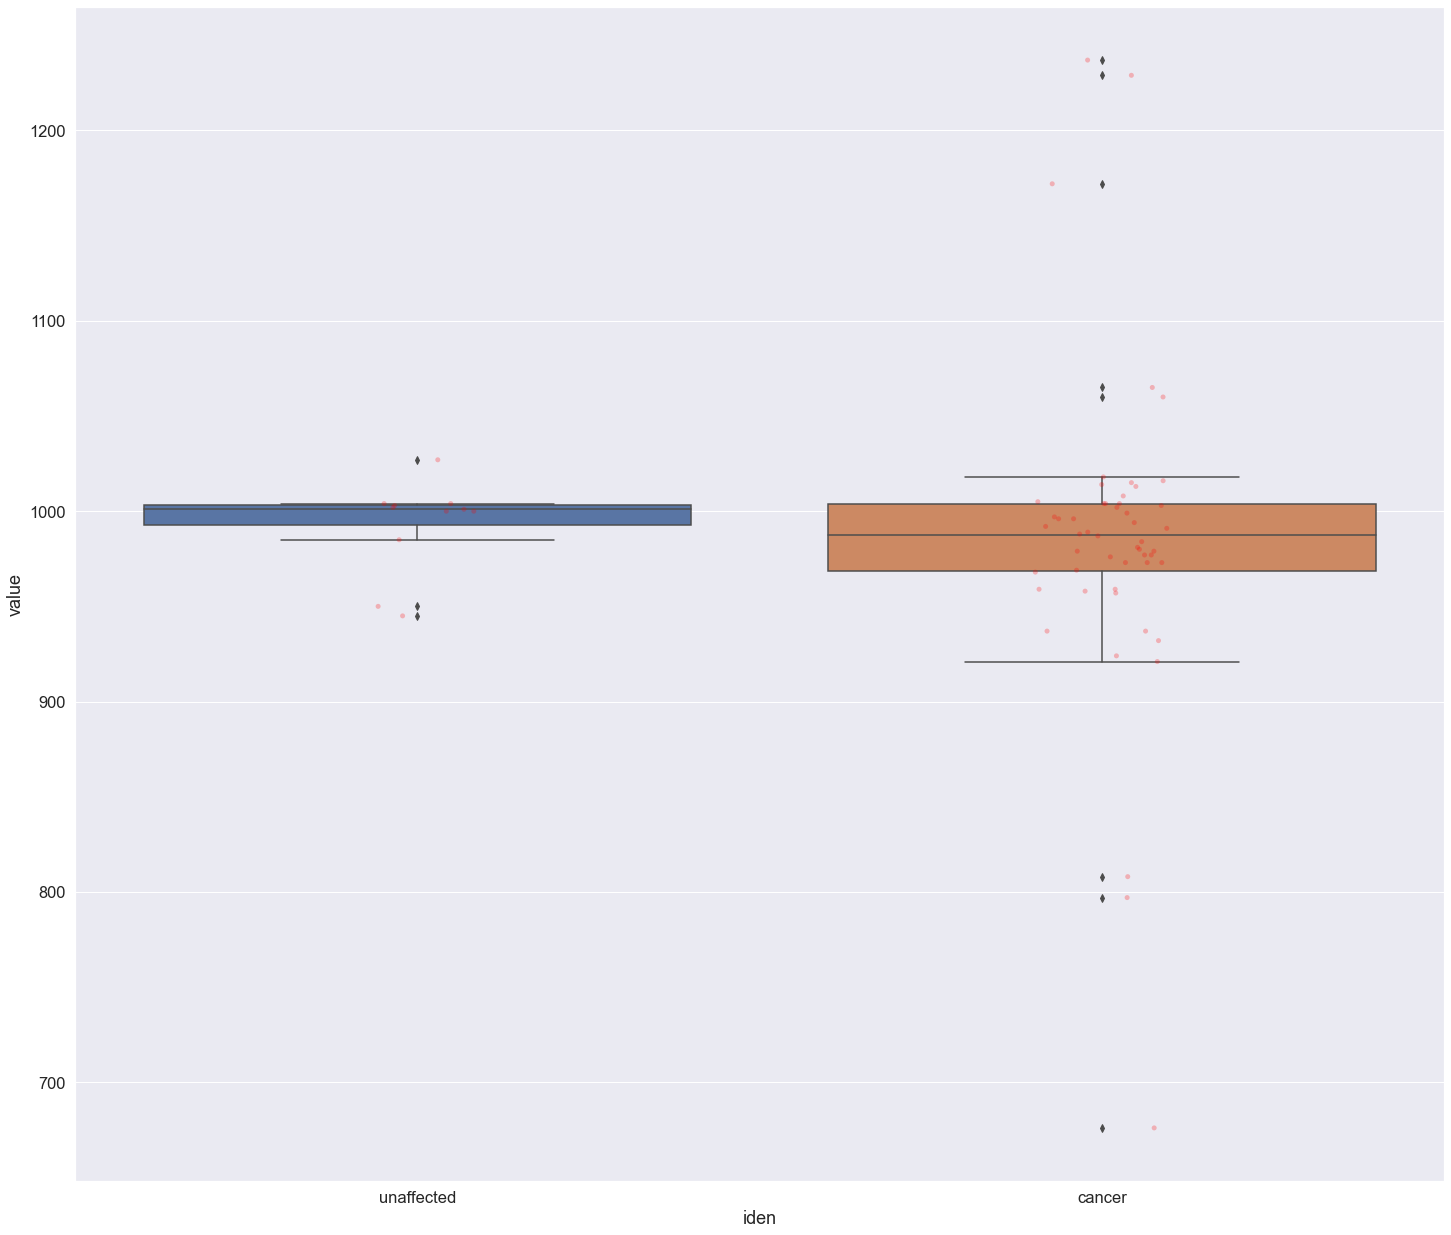

LINE1
MannwhitneyuResult(statistic=367.5, pvalue=0.1410915439773128)


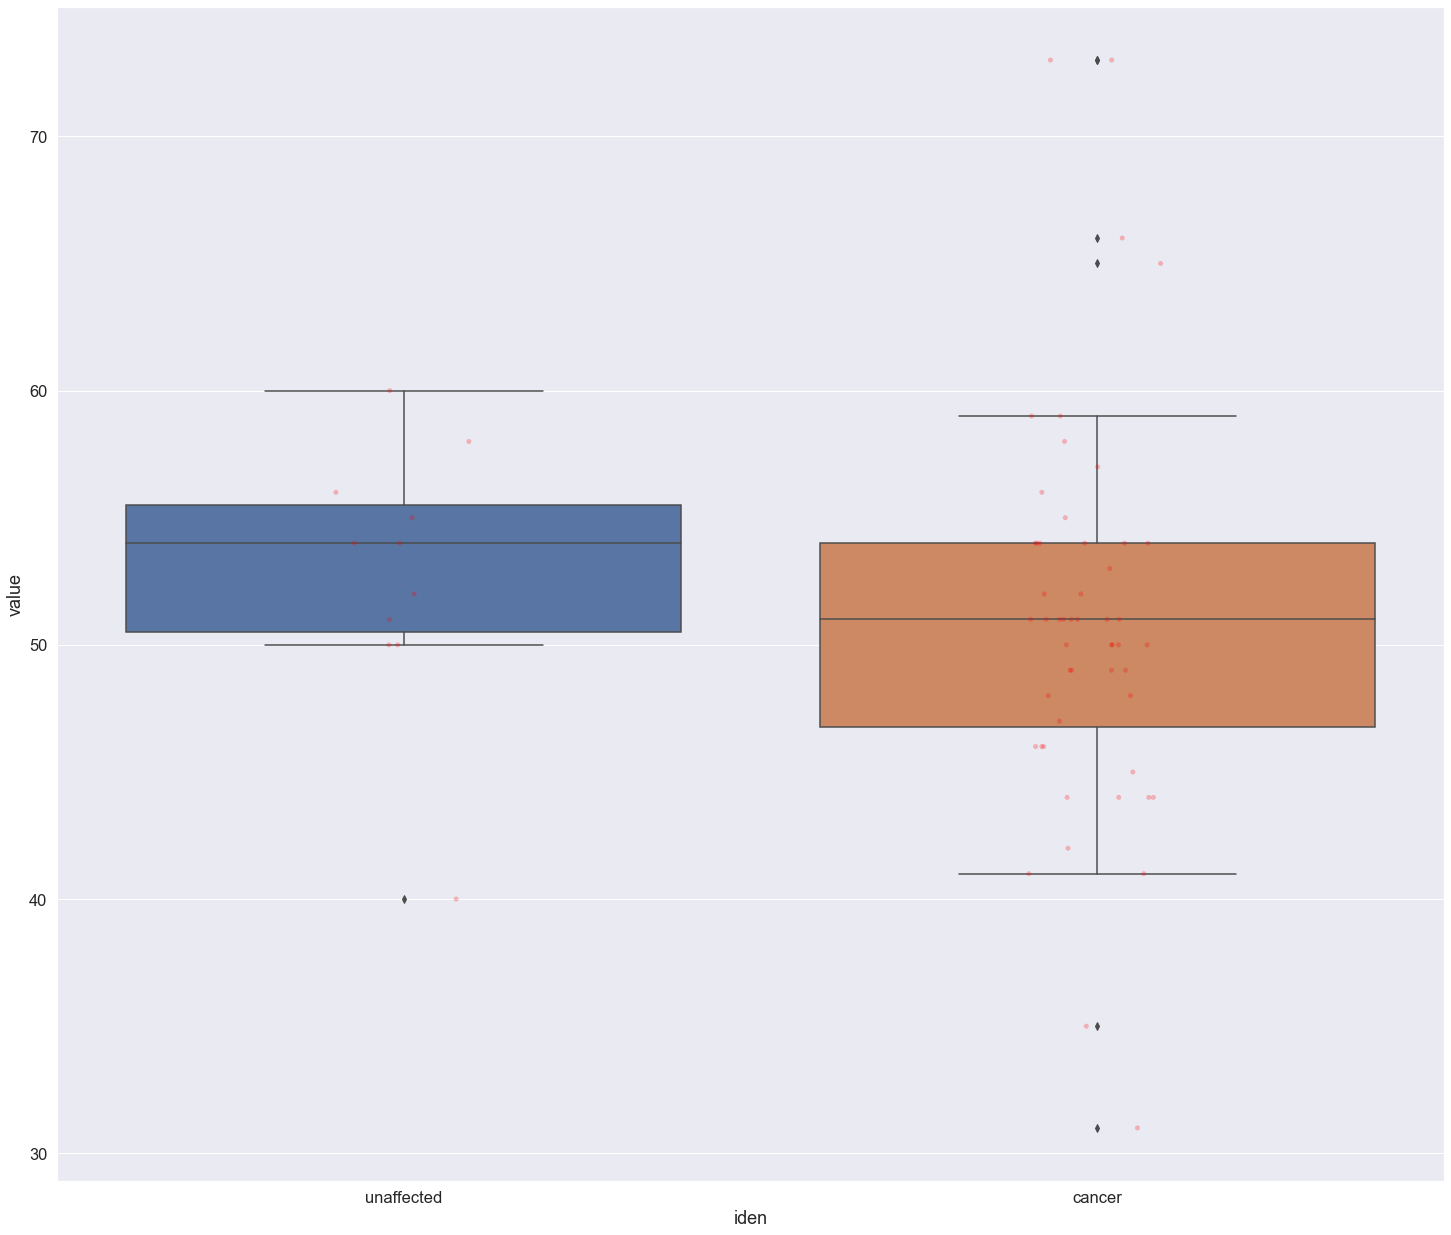

SVA
MannwhitneyuResult(statistic=298.5, pvalue=0.8274816180334266)


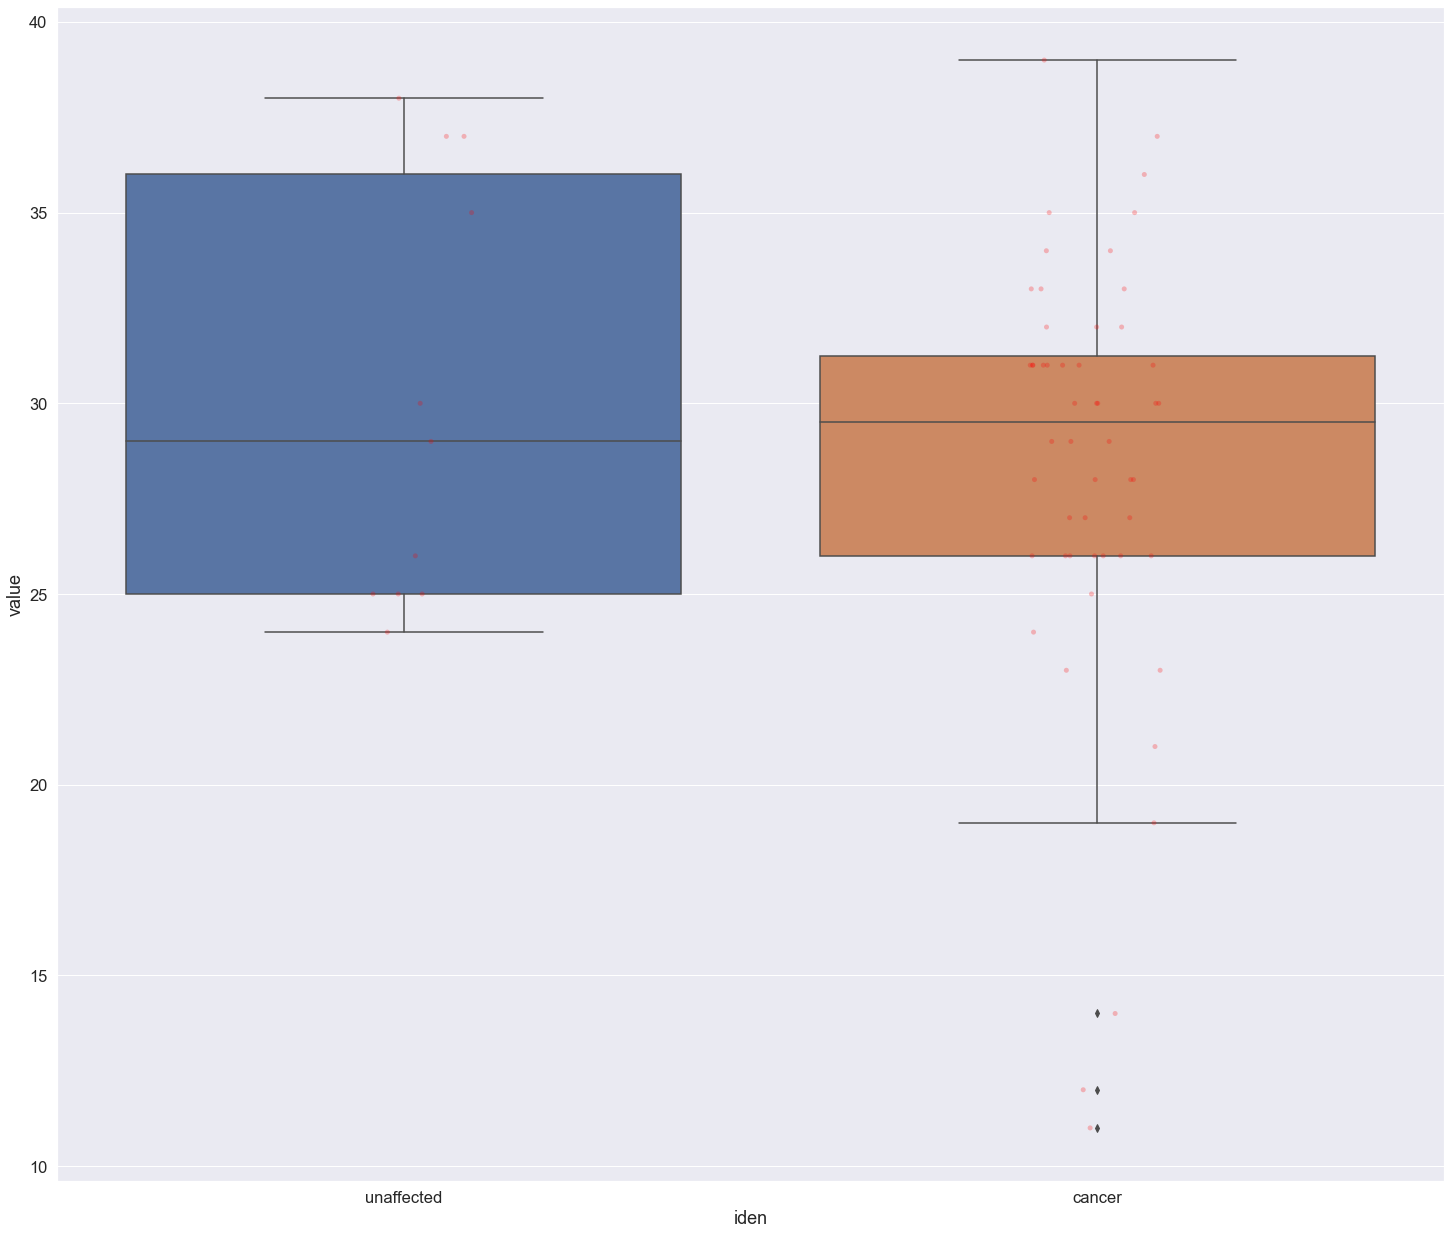

ALLL
MannwhitneyuResult(statistic=369.5, pvalue=0.13283911046991184)


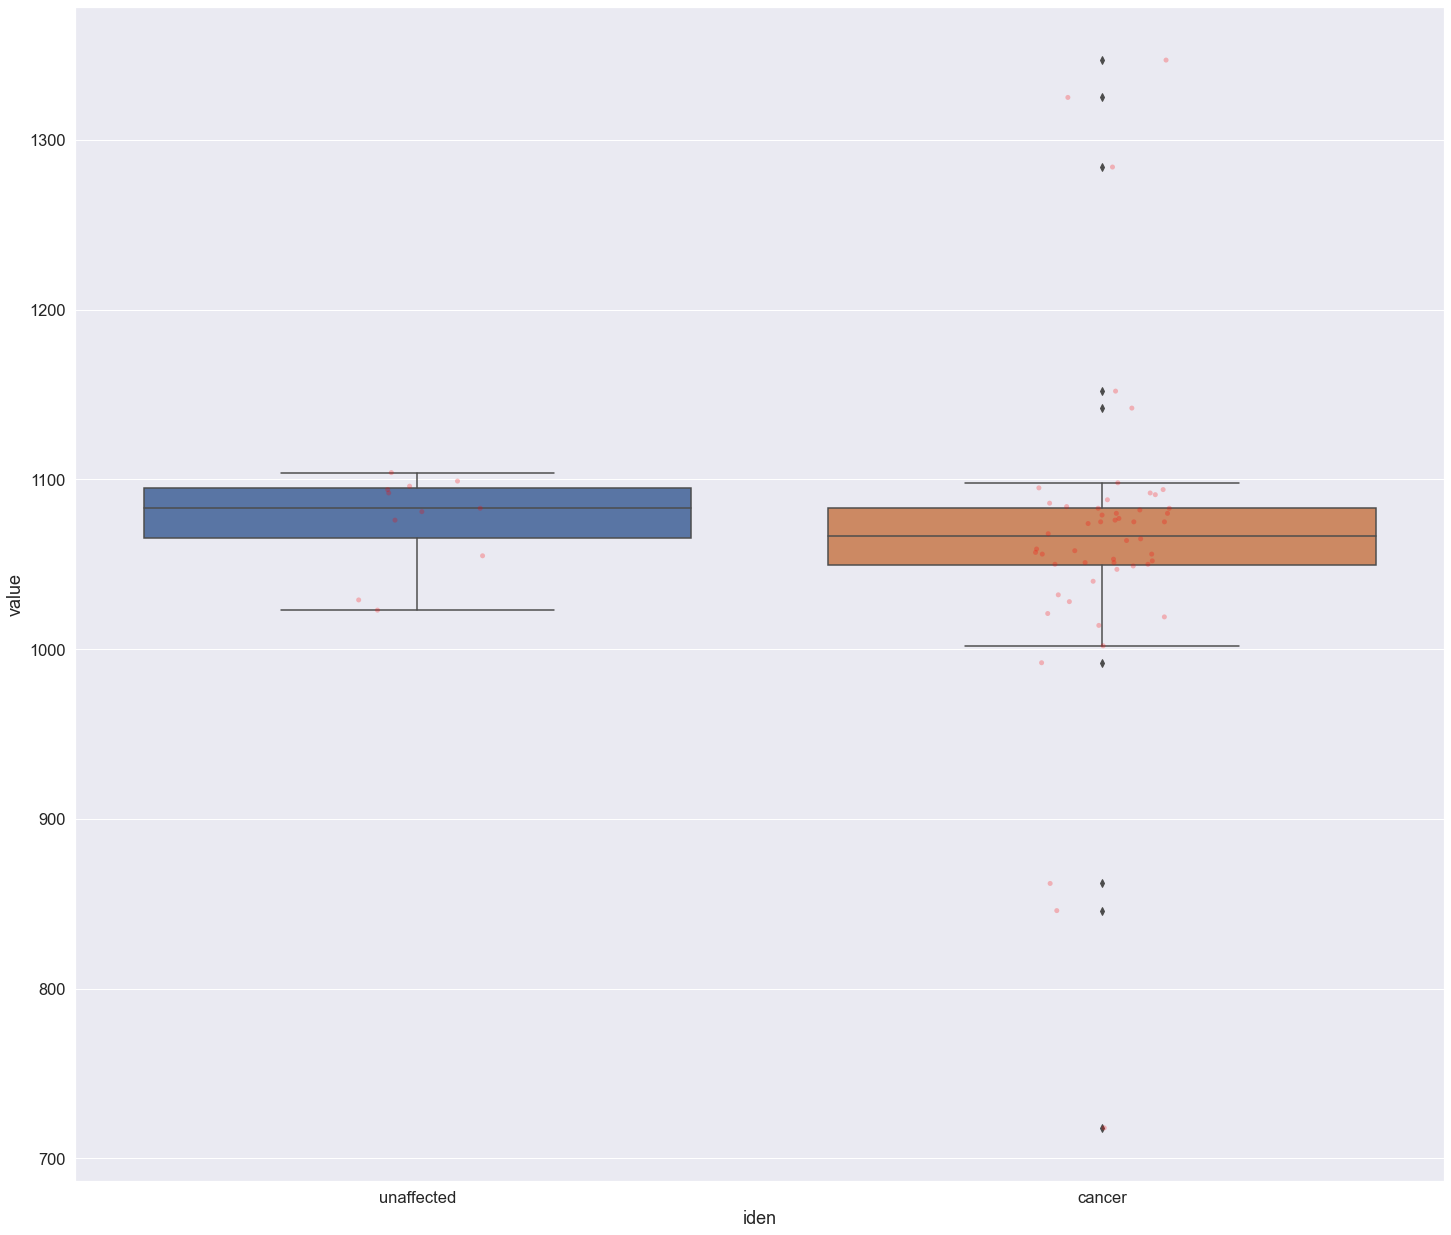

In [42]:
"""
LFS vs Unaffected
3 graphs for TE elements (ALU LINE1 SVA) showing "overall"
"""
#checked if unaffected tissue type is unaffected diag and vice versa -> they are
unaffectedDf = bigLdf[bigLdf['tissue_type']=='Unaffected'].drop(['sample', 'tissue_type',
                                                                 'cancer_diagnosis','SV_type','ageofonset'], axis=1)
cancerDf = bigLdf[bigLdf['tissue_type']!='Unaffected'].drop(['sample', 'tissue_type',
                                                                 'cancer_diagnosis','SV_type','ageofonset'], axis=1)
uAll = unaffectedDf.drop(['ALT'],axis=1).value_counts().to_frame().reset_index()
uAll = uAll.rename(columns={0:'freq'})
uAll['dataset'] = 'unaffected'
cAll = cancerDf.drop(['ALT'],axis=1).value_counts().to_frame().reset_index()
cAll = cAll.rename(columns={0:'freq'})
cAll['dataset'] = 'cancer'
mergedAll = pd.DataFrame(data={'unaffected':uAll['freq'], 'cancer':cAll['freq']})
print('ALL')
outliersInDf(pd.concat([uAll,cAll]),'dataset','freq')


uAlu = unaffectedDf[unaffectedDf['ALT'] == 'ALU'].value_counts().to_frame().reset_index()
uAlu = uAlu.rename(columns={0:'freq'})
uAlu['dataset'] = 'unaffected'

cAlu = cancerDf[cancerDf['ALT'] == 'ALU'].value_counts().to_frame().reset_index()
cAlu = cAlu.rename(columns={0:'freq'})
cAlu['dataset'] = 'cancer'
mergedAlu = pd.DataFrame(data = {'unaffected':uAlu['freq'],'cancer':cAlu['freq']})
print('ALU')
outliersInDf(pd.concat([uAlu,cAlu]),'dataset','freq')



uLine = unaffectedDf[unaffectedDf['ALT'] == 'LINE1'].value_counts().to_frame().reset_index()
uLine = uLine.rename(columns={0:'freq'})
uLine['dataset'] = 'unaffected'
cLine = cancerDf[cancerDf['ALT'] == 'LINE1'].value_counts().to_frame().reset_index()
cLine = cLine.rename(columns={0:'freq'})
cLine['dataset'] = 'cancer'
mergedLine = pd.DataFrame(data = {'unaffected':uLine['freq'],'cancer':cLine['freq']})
print('LINE1')
outliersInDf(pd.concat([uLine,cLine]),'dataset','freq')

uSva = unaffectedDf[unaffectedDf['ALT'] == 'SVA'].value_counts().to_frame().reset_index()
uSva = uSva.rename(columns={0:'freq'})
uSva['dataset'] = 'unaffected'
cSva = cancerDf[cancerDf['ALT'] == 'SVA'].value_counts().to_frame().reset_index()
cSva = cSva.rename(columns={0:'freq'})
cSva['dataset'] = 'cancer'
mergedSva = pd.DataFrame(data = {'unaffected':uSva['freq'],'cancer':cSva['freq']})
print('SVA')
outliersInDf(pd.concat([uSva,cSva]),'dataset','freq')

title = ['unaffected','cancer']

boxplotPoints(title, title, mergedAlu)
print('LINE1')
boxplotPoints(title, title, mergedLine)
print('SVA')
boxplotPoints(title, title, mergedSva)

print('ALLL')
boxplotPoints(title, title, mergedAll)


In [43]:
kDiagList = pd.DataFrame(data={'diag':bigKdf['cancer_diagnosis'], 'id':bigKdf['Samples_ID']}) 
lDiagList = pd.DataFrame(data={'diag':bigLdf['cancer_diagnosis'], 'id':bigLdf['Samples_ID']})

ktList = pd.DataFrame(data={'tissue_type':bigKdf['tissue_type'], 'id':bigKdf['Samples_ID']})
ltList = pd.DataFrame(data={'tissue_type':bigLdf['tissue_type'], 'id':bigLdf['Samples_ID']})

LFS
  Samples_ID cancer_diagnosis  freq dataset
8       2262              RMS  1325     lfs
the outliers for RMS are:
['2262']

KICS
  Samples_ID cancer_diagnosis  freq dataset
6     284386              RMS  4516    kics
the outliers for RMS are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.196e-02 U_stat=7.000e+00


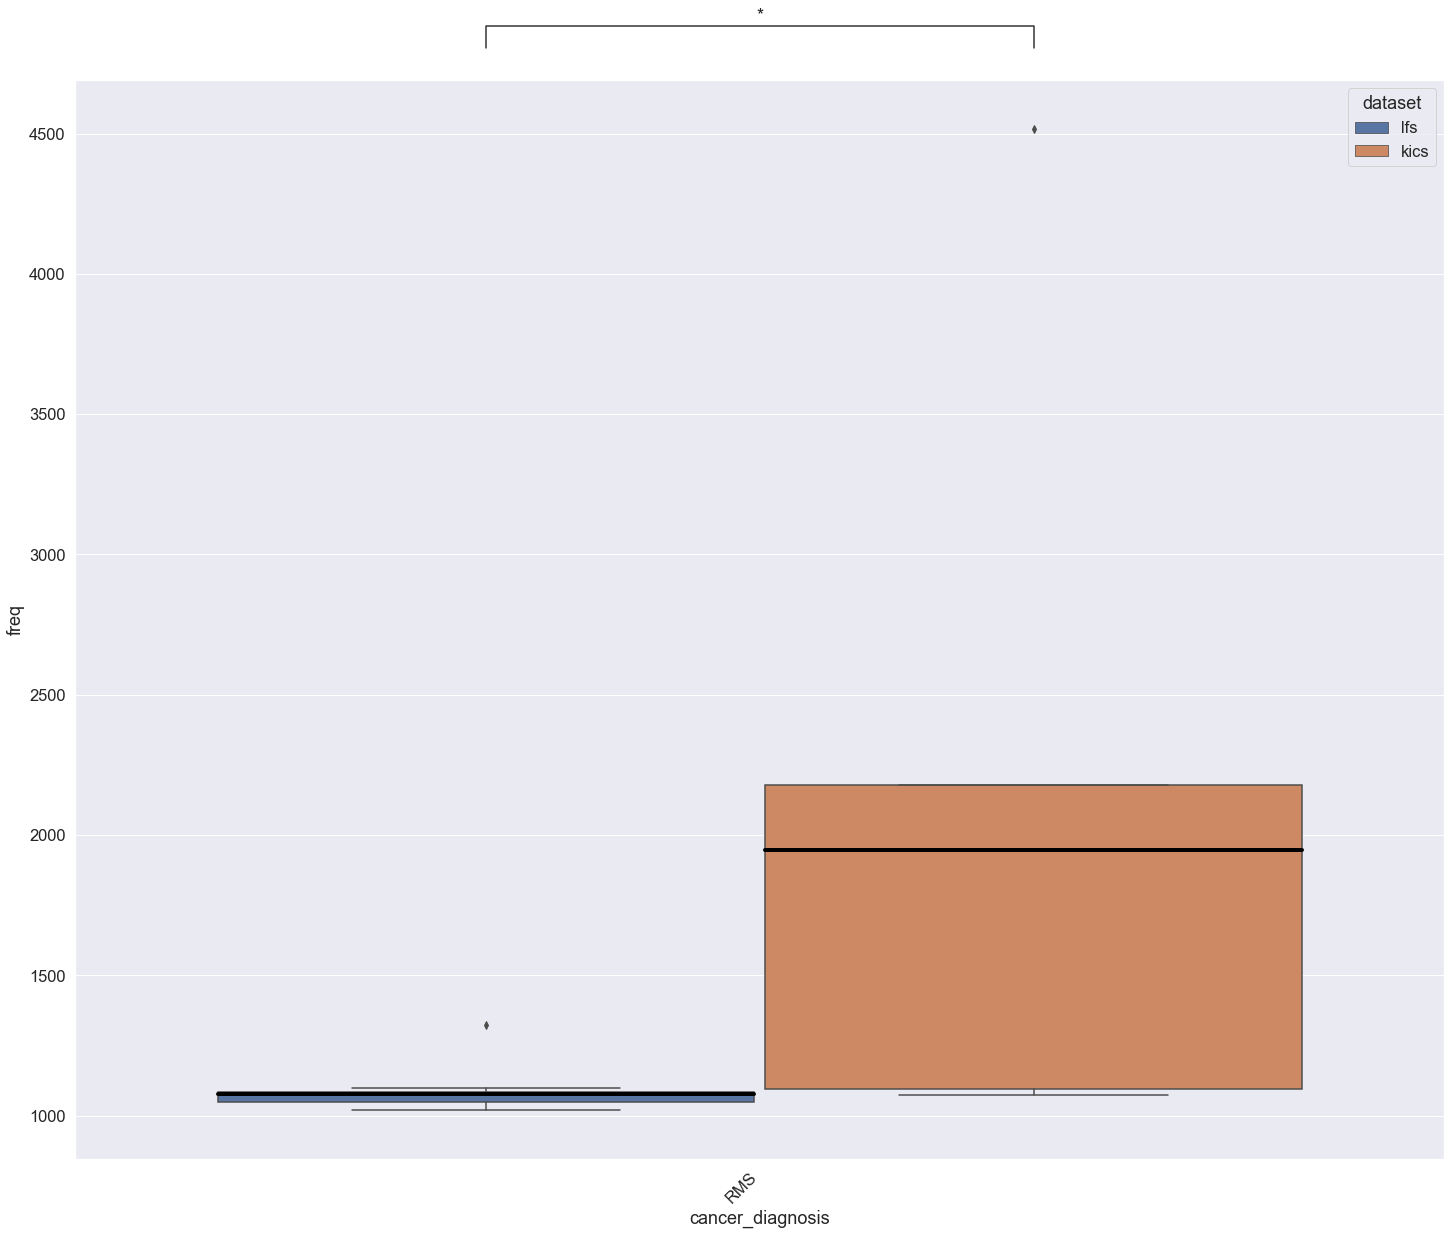

In [44]:
kicsTissue = bigKdf.drop(['SV_type','abbv_id','sample', 'tumour_class', 'cancer_diagnosis','ageofonset'], axis=1)
kicsDiag = bigKdf.drop(['SV_type','abbv_id','sample', 'tumour_class','ageofonset', 'tissue_type'], axis=1)

lfsTissue = bigLdf.drop(['cancer_diagnosis', 'sample','SV_type','ageofonset'],axis=1)
lfsDiag = bigLdf.drop(['tissue_type', 'sample','SV_type','ageofonset'],axis=1)

graphSVTissue(kicsDiag, lfsDiag, False)

LFS
  Samples_ID  tissue_type  freq dataset
8       2262  Soft Tissue  1325     lfs
the outliers for Soft Tissue are:
['2262']

   Samples_ID tissue_type  freq dataset
27       3356         CNS  1347     lfs
the outliers for CNS are:
['3356']

KICS
   Samples_ID tissue_type  freq dataset
1      271116         CNS  3192    kics
8      286909         CNS  2184    kics
28     300683         CNS  2596    kics
the outliers for CNS are:
['271116', '286909', '300683']

  Samples_ID  tissue_type  freq dataset
6     284386  Soft Tissue  4516    kics
the outliers for Soft Tissue are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS_lfs vs. CNS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:8.613e-01 U_stat=3.500e+01
Soft Tissue_lfs vs. Soft Tissue_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:3.003e-02 U_stat=1.000e+01


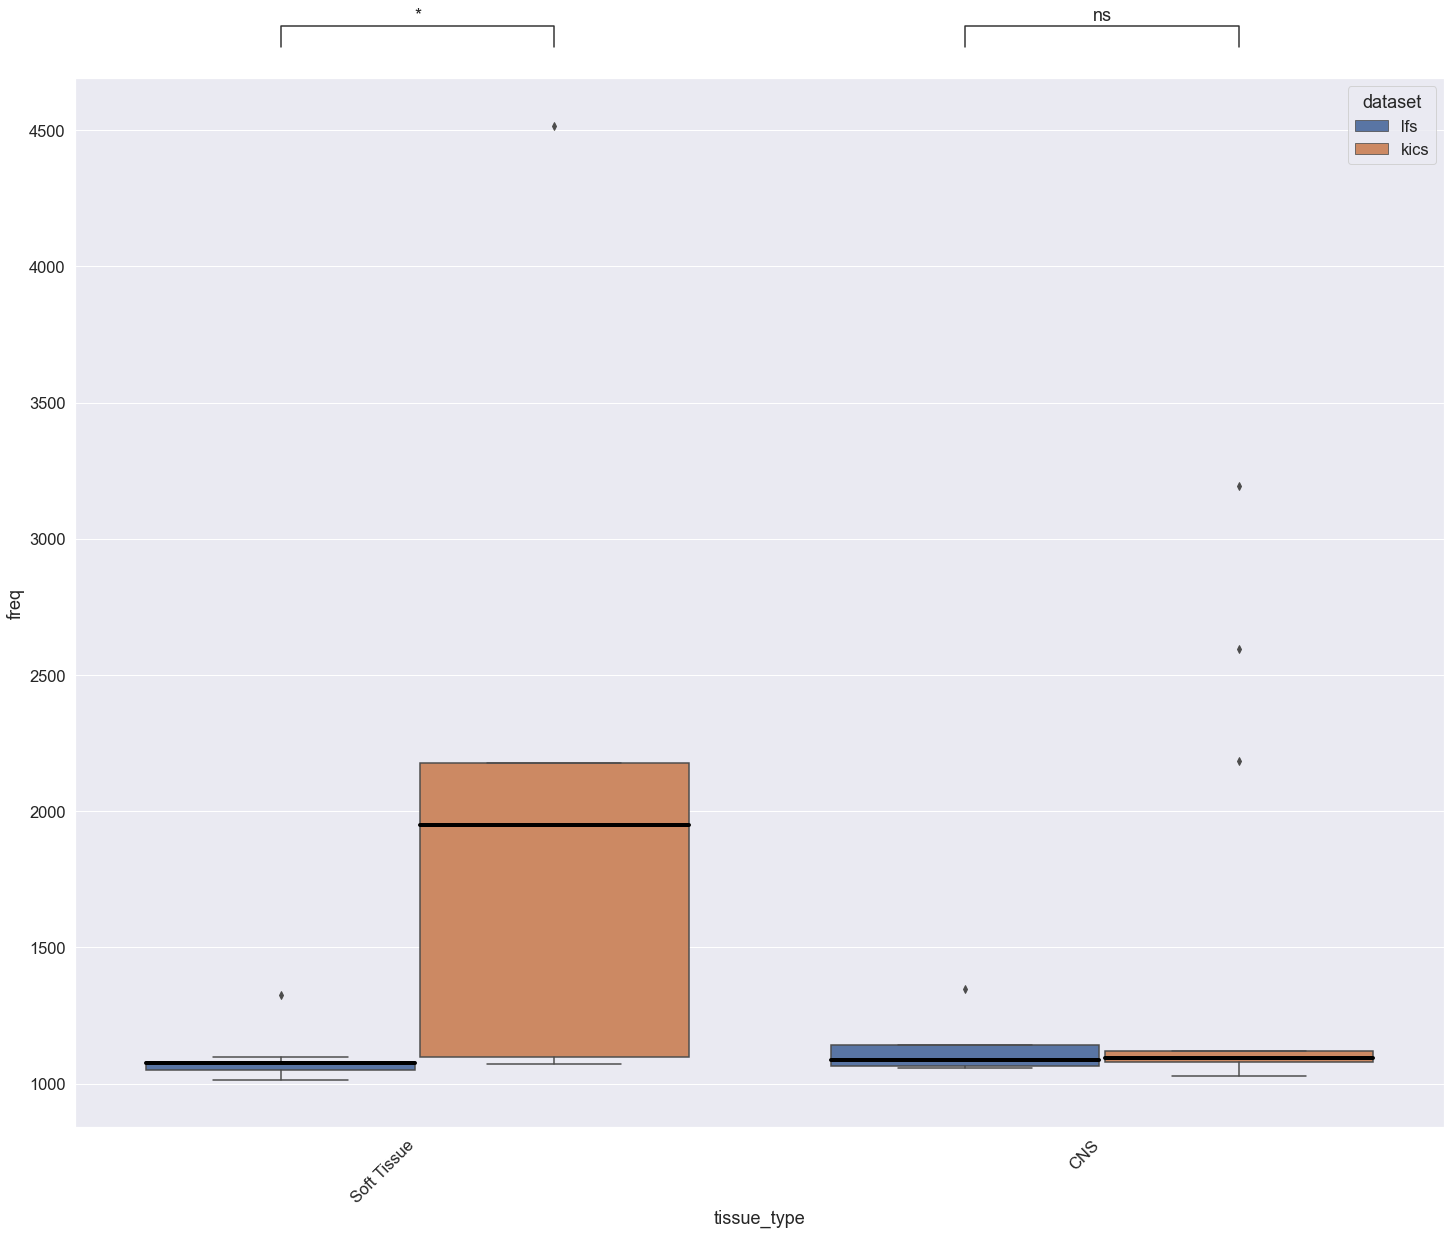

In [45]:
graphSVTissue(kicsTissue, lfsTissue, True)

In [46]:
"""
Creating dfs needed for lfs vs kics tissue and diag
"""
kDF = bigKdf.drop(['SV_type', 'abbv_id', 'sample', 'tumour_class','ageofonset'],axis=1)
lDF = bigLdf.drop(['SV_type','sample','ageofonset'],axis=1)

kAlu = kDF.loc[kDF['ALT'] == 'ALU']
kLine = kDF.loc[kDF['ALT'] == 'LINE1']
kSva = kDF.loc[kDF['ALT'] == 'SVA']

lAlu = lDF.loc[lDF['ALT'] == 'ALU']
lLine = lDF.loc[lDF['ALT'] == 'LINE1']
lSva = lDF.loc[lDF['ALT'] == 'SVA']

LFS
  Samples_ID  tissue_type  freq dataset
8       2262  Soft Tissue  1229     lfs
the outliers for Soft Tissue are:
['2262']

   Samples_ID tissue_type  freq dataset
27       3356         CNS  1237     lfs
the outliers for CNS are:
['3356']

KICS
   Samples_ID tissue_type  freq dataset
1      271116         CNS  2961    kics
8      286909         CNS  2044    kics
28     300683         CNS  2380    kics
the outliers for CNS are:
['271116', '286909', '300683']

  Samples_ID  tissue_type  freq dataset
6     284386  Soft Tissue  4184    kics
the outliers for Soft Tissue are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS_lfs vs. CNS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:8.001e-01 U_stat=3.400e+01
Soft Tissue_lfs vs. Soft Tissue_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:2.994e-02 U_stat=1.000e+01


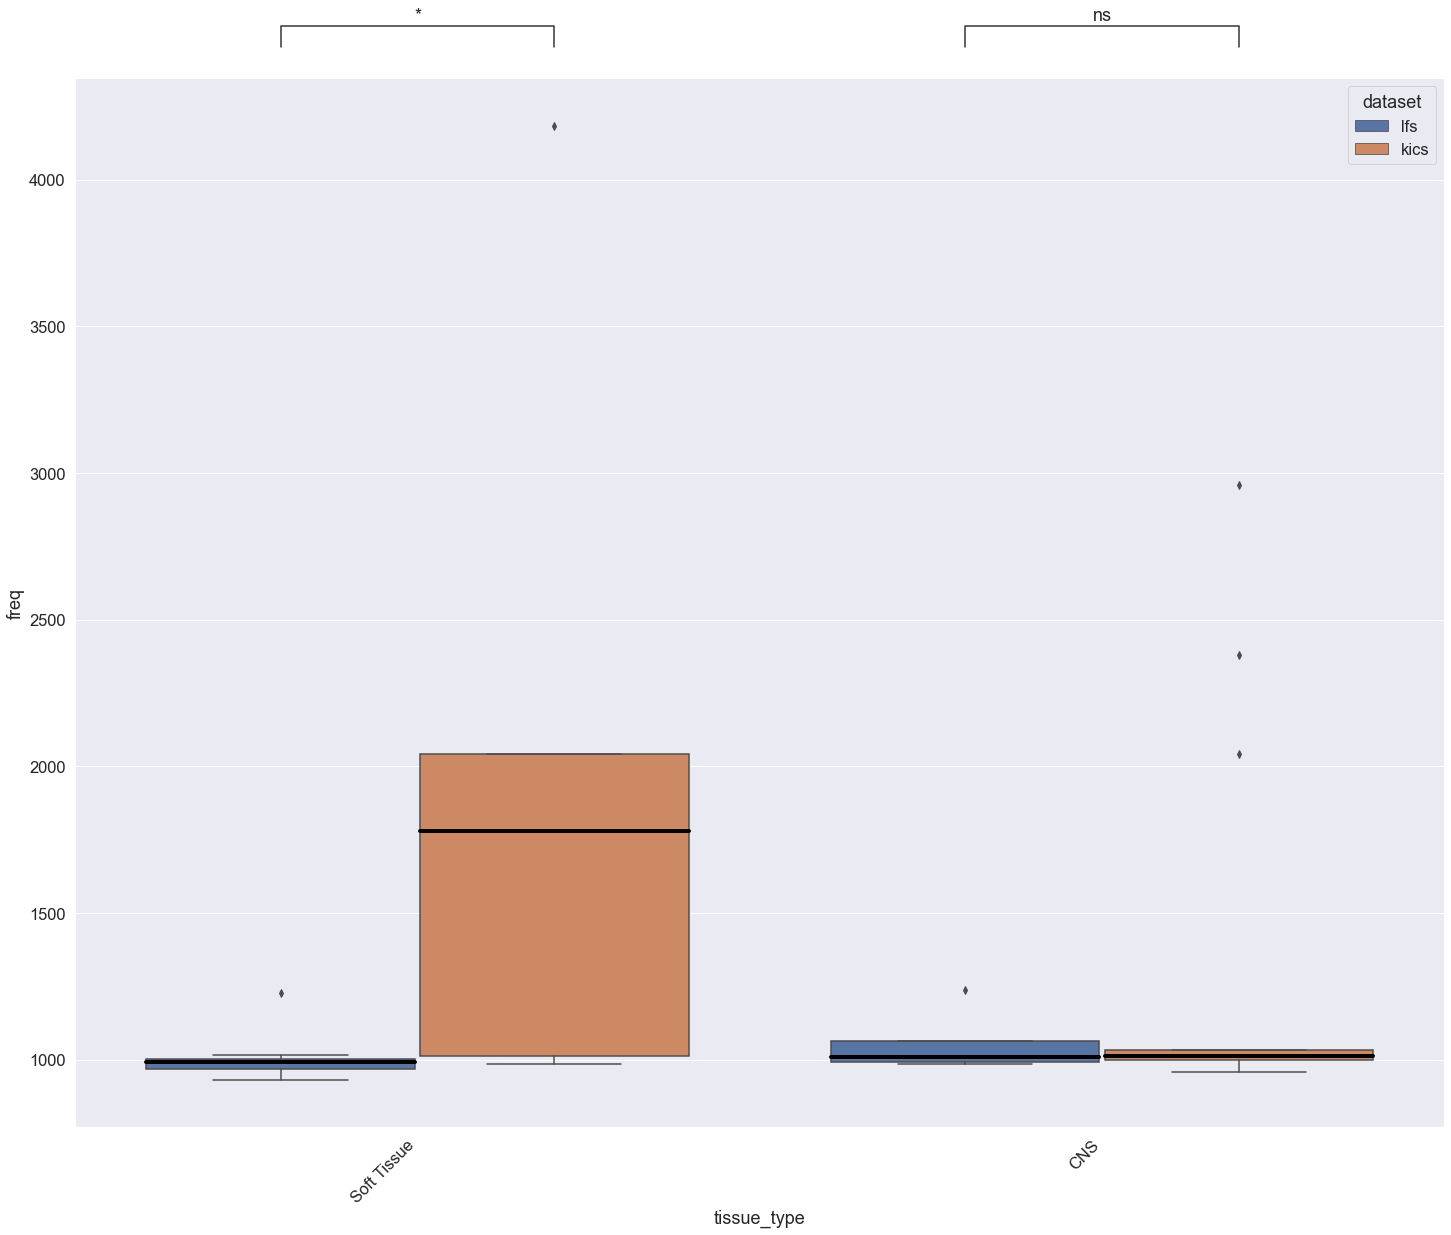

In [47]:
graphSVTissue(kAlu.drop(['cancer_diagnosis'],axis=1), lAlu.drop(['cancer_diagnosis'],axis=1), True)

LFS
  Samples_ID  tissue_type  freq dataset
8       2262  Soft Tissue    66     lfs
the outliers for Soft Tissue are:
['2262']

   Samples_ID tissue_type  freq dataset
27       3356         CNS    73     lfs
the outliers for CNS are:
['3356']

KICS
   Samples_ID tissue_type  freq dataset
1      271116         CNS   150    kics
8      286909         CNS   104    kics
28     300683         CNS   132    kics
the outliers for CNS are:
['271116', '286909', '300683']

  Samples_ID  tissue_type  freq dataset
6     284386  Soft Tissue   212    kics
the outliers for Soft Tissue are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS_lfs vs. CNS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:5.117e-01 U_stat=2.950e+01
Soft Tissue_lfs vs. Soft Tissue_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.344e-02 U_stat=7.000e+00


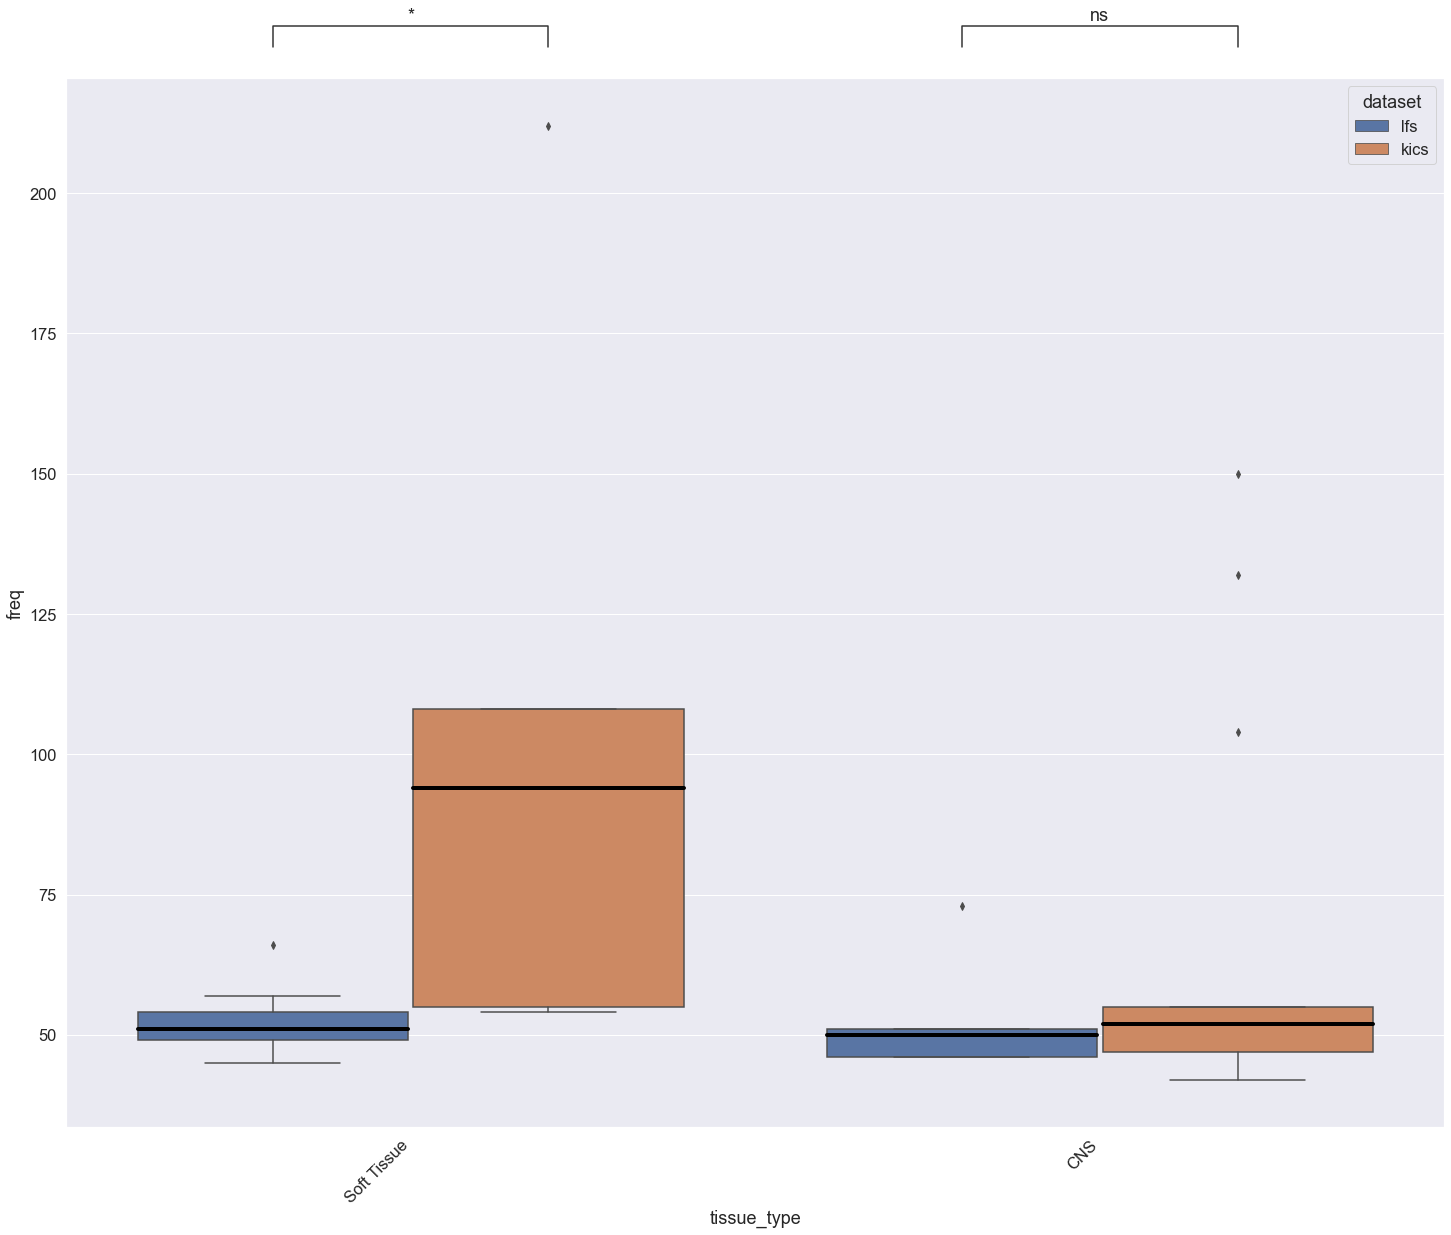

In [48]:
graphSVTissue(kLine.drop(['cancer_diagnosis'],axis=1), lLine.drop(['cancer_diagnosis'],axis=1), True)

LFS
   Samples_ID  tissue_type  freq dataset
1        1092  Soft Tissue    28     lfs
6        1843  Soft Tissue    28     lfs
9        2349  Soft Tissue    33     lfs
47       4227  Soft Tissue    35     lfs
49       4329  Soft Tissue    26     lfs
the outliers for Soft Tissue are:
['1092', '1843', '2349', '4227', '4329']

   Samples_ID tissue_type  freq dataset
27       3356         CNS    37     lfs
the outliers for CNS are:
['3356']

KICS
   Samples_ID tissue_type  freq dataset
1      271116         CNS    81    kics
28     300683         CNS    84    kics
the outliers for CNS are:
['271116', '300683']

  Samples_ID  tissue_type  freq dataset
6     284386  Soft Tissue   120    kics
the outliers for Soft Tissue are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS_lfs vs. CNS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.059e-01 U_

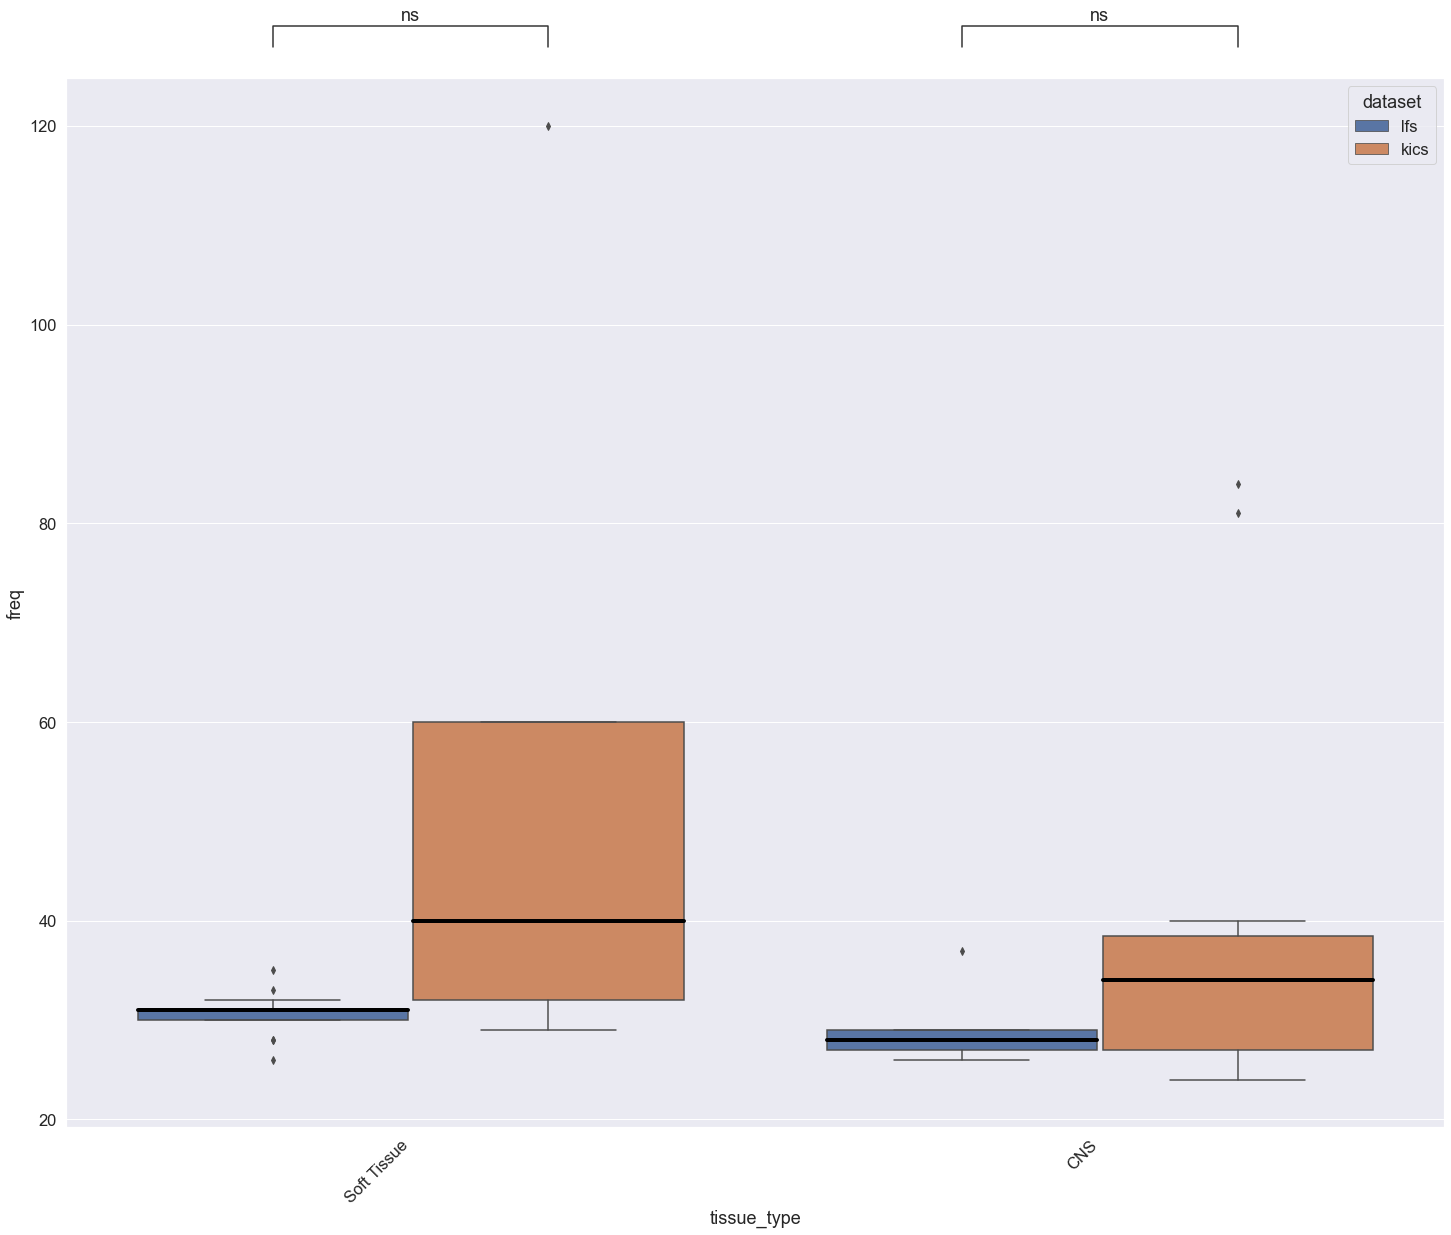

In [49]:
graphSVTissue(kSva.drop(['cancer_diagnosis'],axis=1), lSva.drop(['cancer_diagnosis'],axis=1), True)

LFS
  Samples_ID cancer_diagnosis  freq dataset
8       2262              RMS  1229     lfs
the outliers for RMS are:
['2262']

KICS
  Samples_ID cancer_diagnosis  freq dataset
6     284386              RMS  4184    kics
the outliers for RMS are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.503e-02 U_stat=7.000e+00


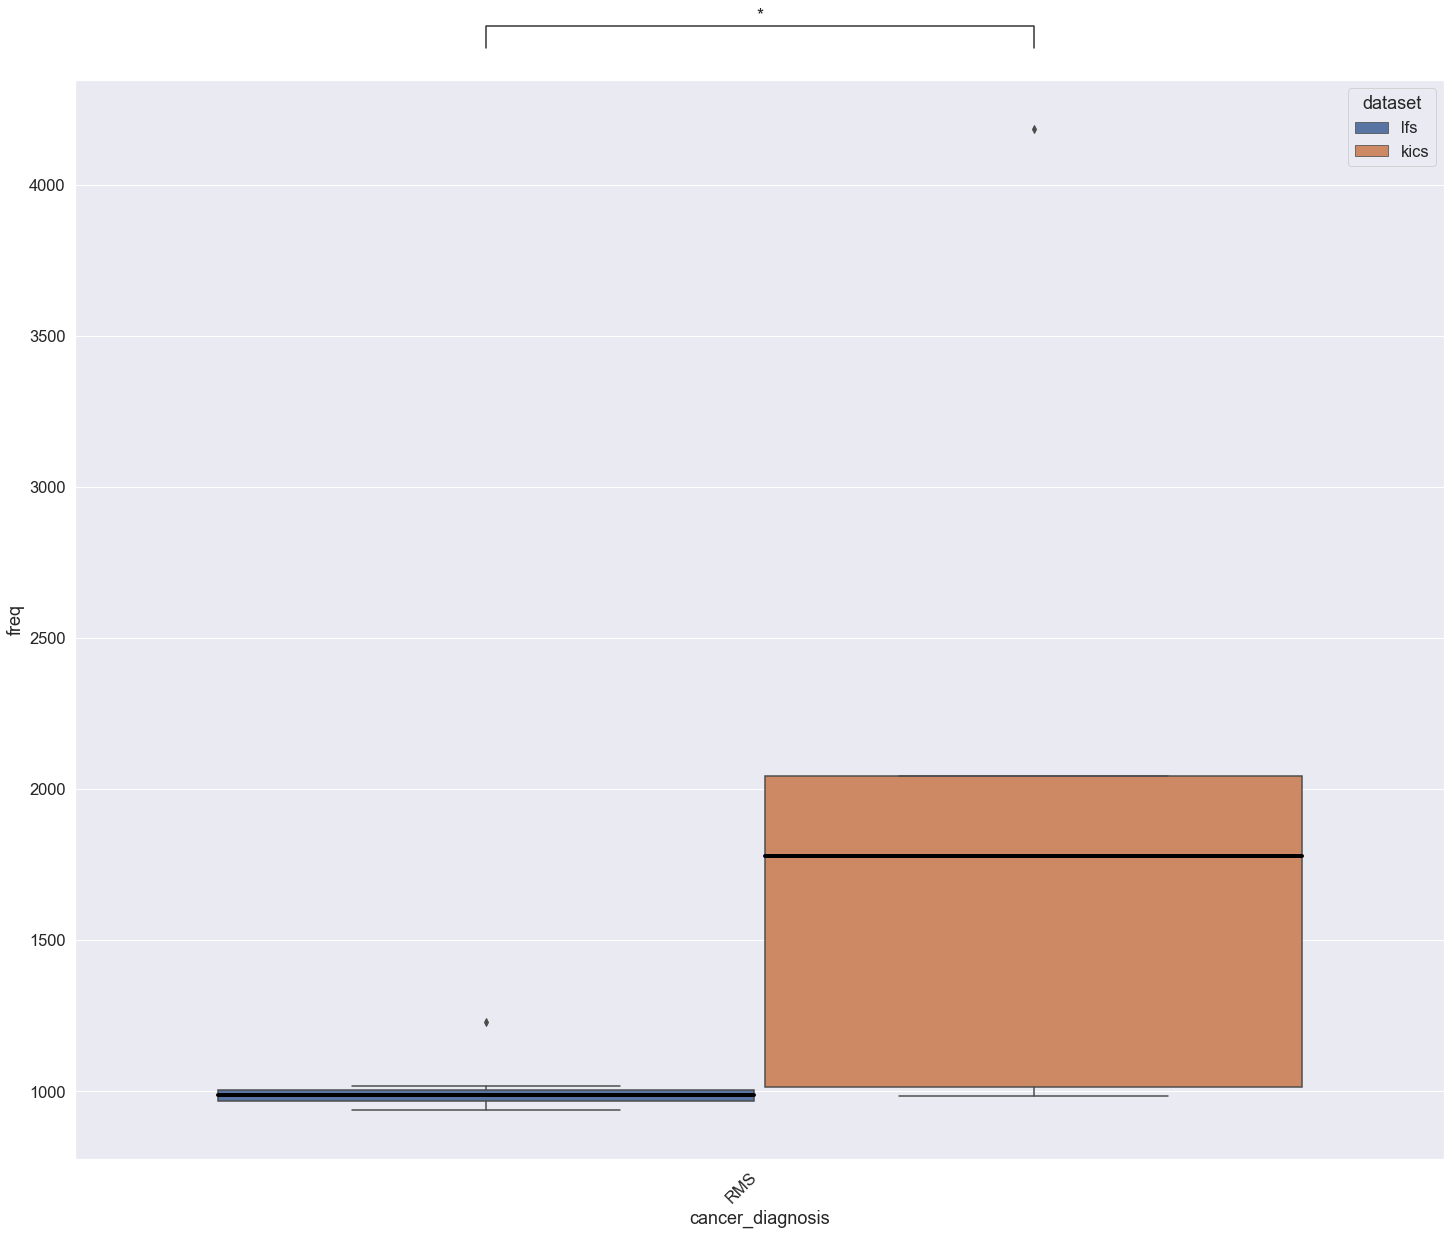

In [50]:
#diagnosis
graphSVTissue(kAlu.drop(['tissue_type'],axis=1), lAlu.drop(['tissue_type'],axis=1), False)

LFS
  Samples_ID cancer_diagnosis  freq dataset
8       2262              RMS    66     lfs
the outliers for RMS are:
['2262']

KICS
  Samples_ID cancer_diagnosis  freq dataset
6     284386              RMS   212    kics
the outliers for RMS are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:2.280e-02 U_stat=5.000e+00


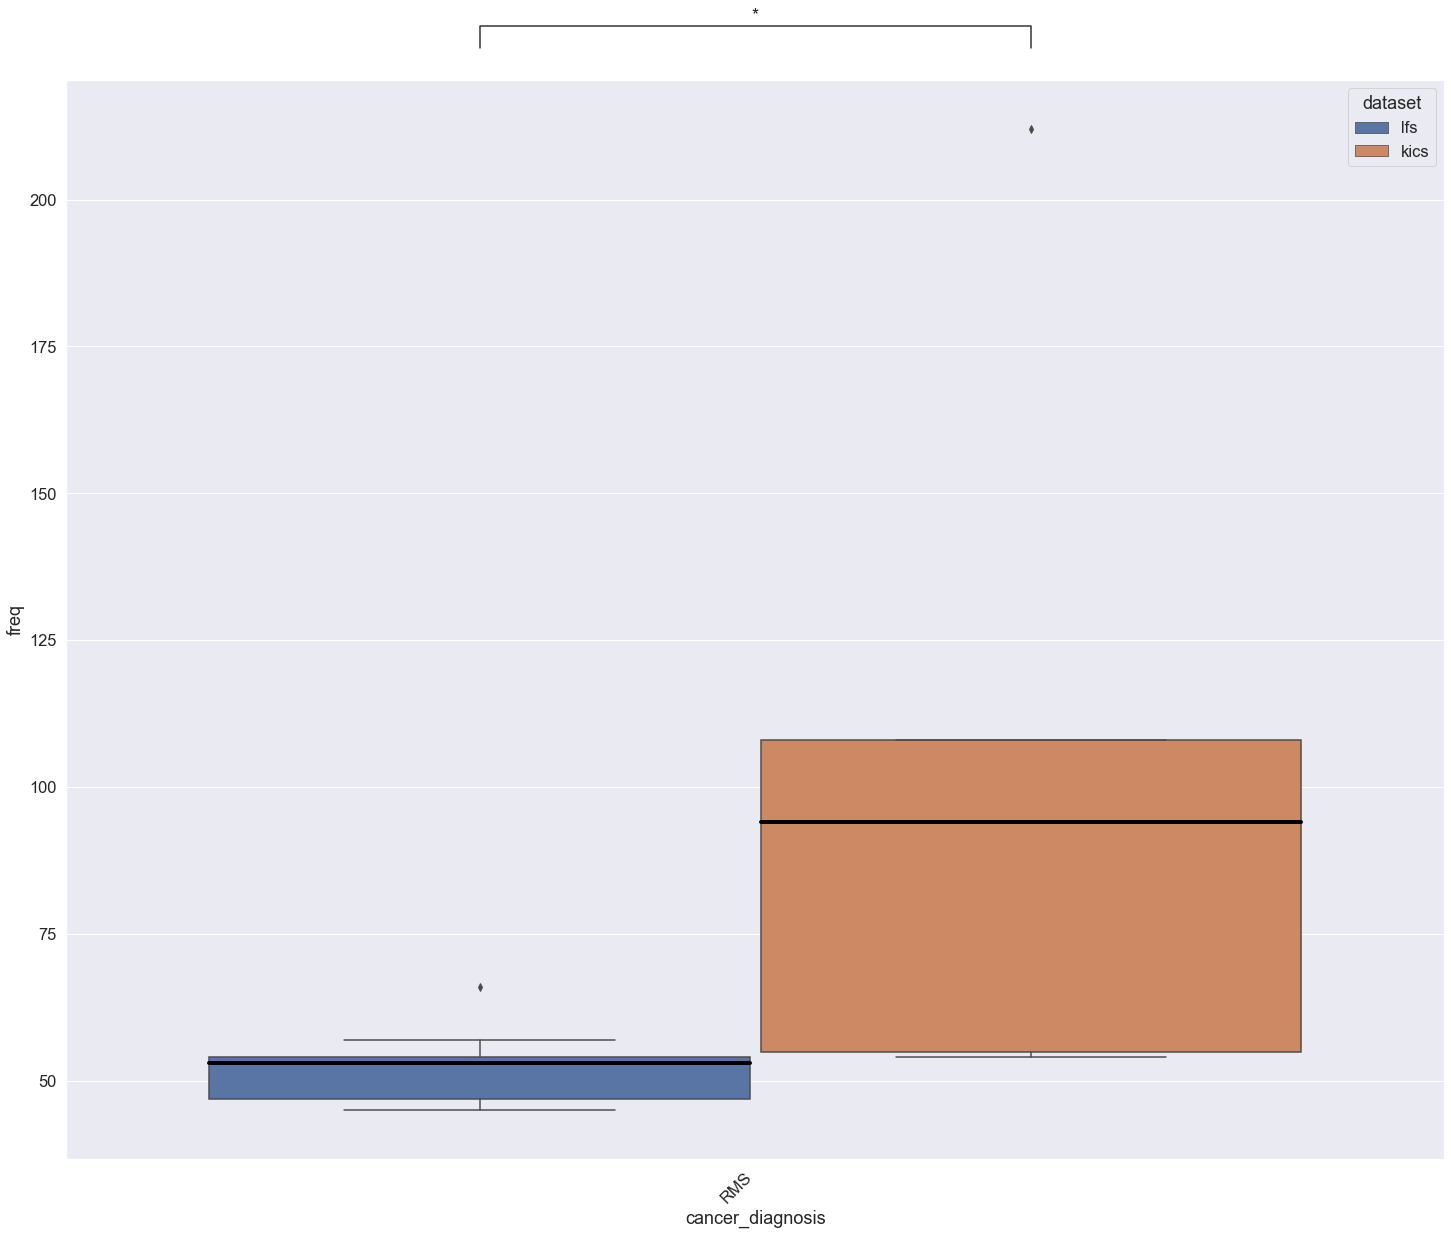

In [51]:
graphSVTissue(kLine.drop(['tissue_type'],axis=1), lLine.drop(['tissue_type'],axis=1), False)

LFS
   Samples_ID cancer_diagnosis  freq dataset
47       4227              RMS    35     lfs
49       4329              RMS    26     lfs
the outliers for RMS are:
['4227', '4329']

KICS
  Samples_ID cancer_diagnosis  freq dataset
6     284386              RMS   120    kics
the outliers for RMS are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.206e-01 U_stat=1.050e+01


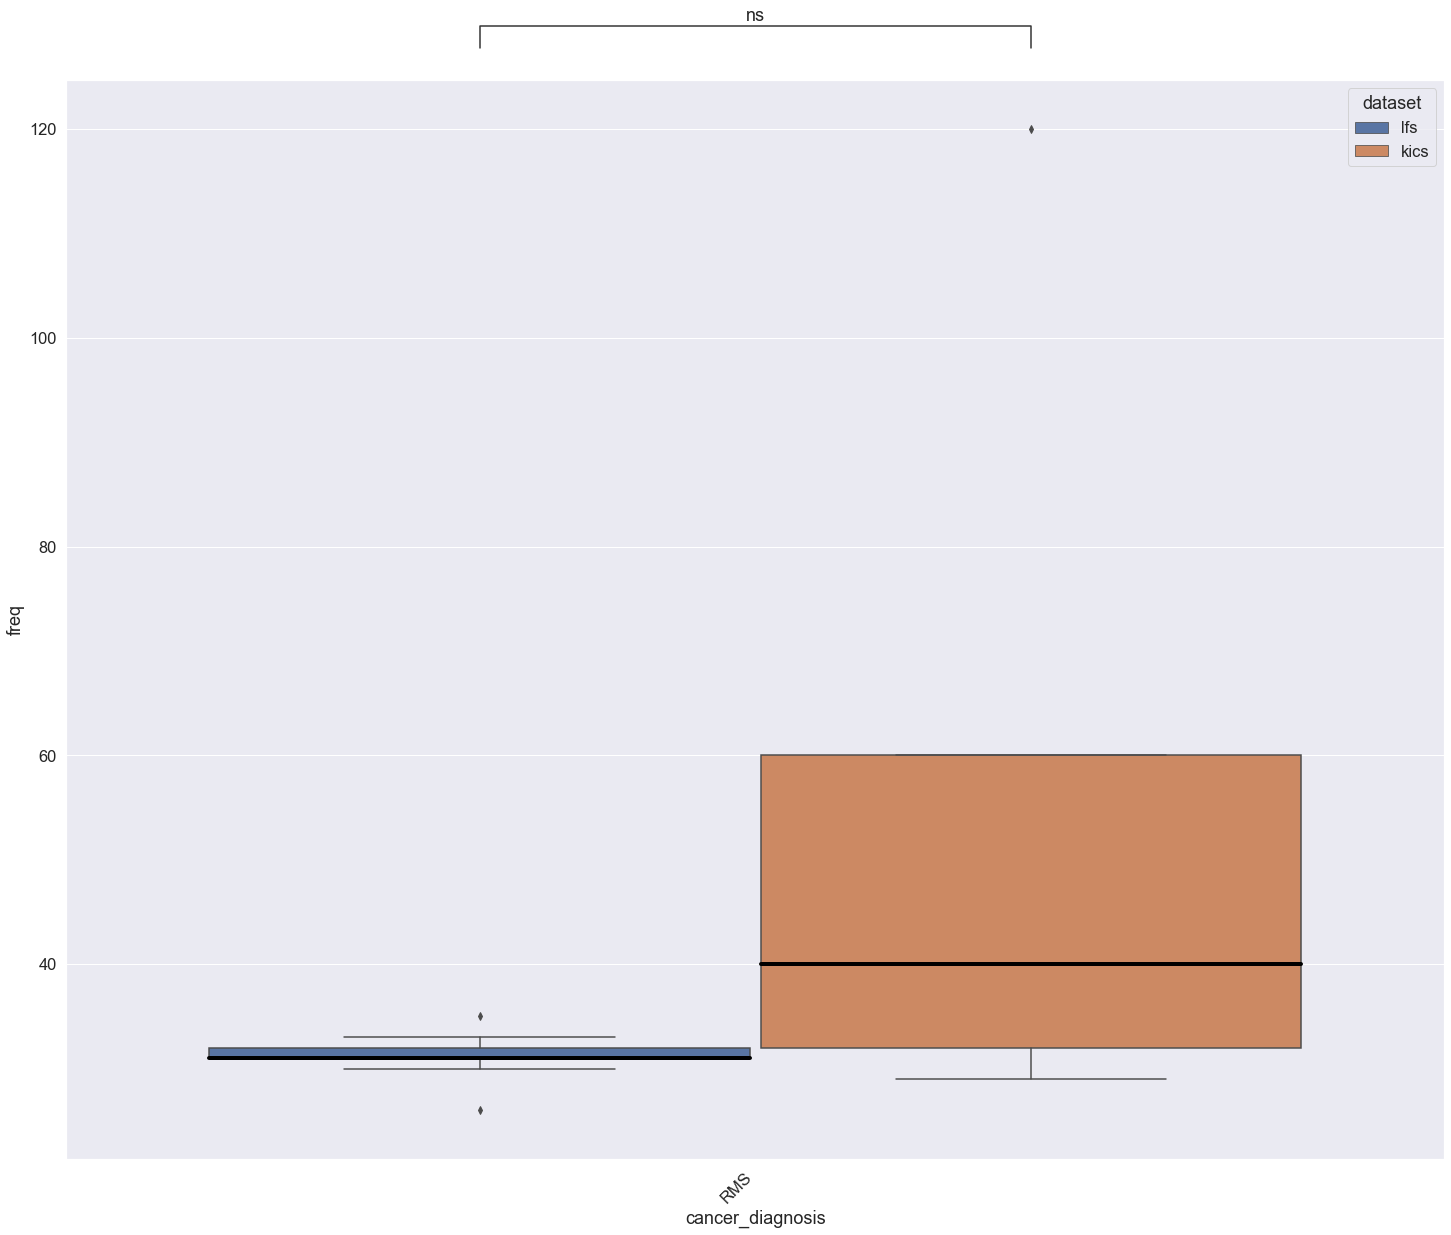

In [52]:
graphSVTissue(kSva.drop(['tissue_type'],axis=1), lSva.drop(['tissue_type'],axis=1), False)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MFH vs. RMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+00
RMS vs. High Grade Sarcoma: Mann-Whitney-Wilcoxon test two-sided, P_val:8.614e-01 U_stat=3.500e+00
High Grade Sarcoma vs. LMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
LMS vs. MFS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
MFH vs. High Grade Sarcoma: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=0.000e+00
RMS vs. LMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+00
High Grade Sarcoma vs. MFS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
MFH vs. LMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
RMS vs. MFS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.000e-01 U_stat=9.000e+00
MFH

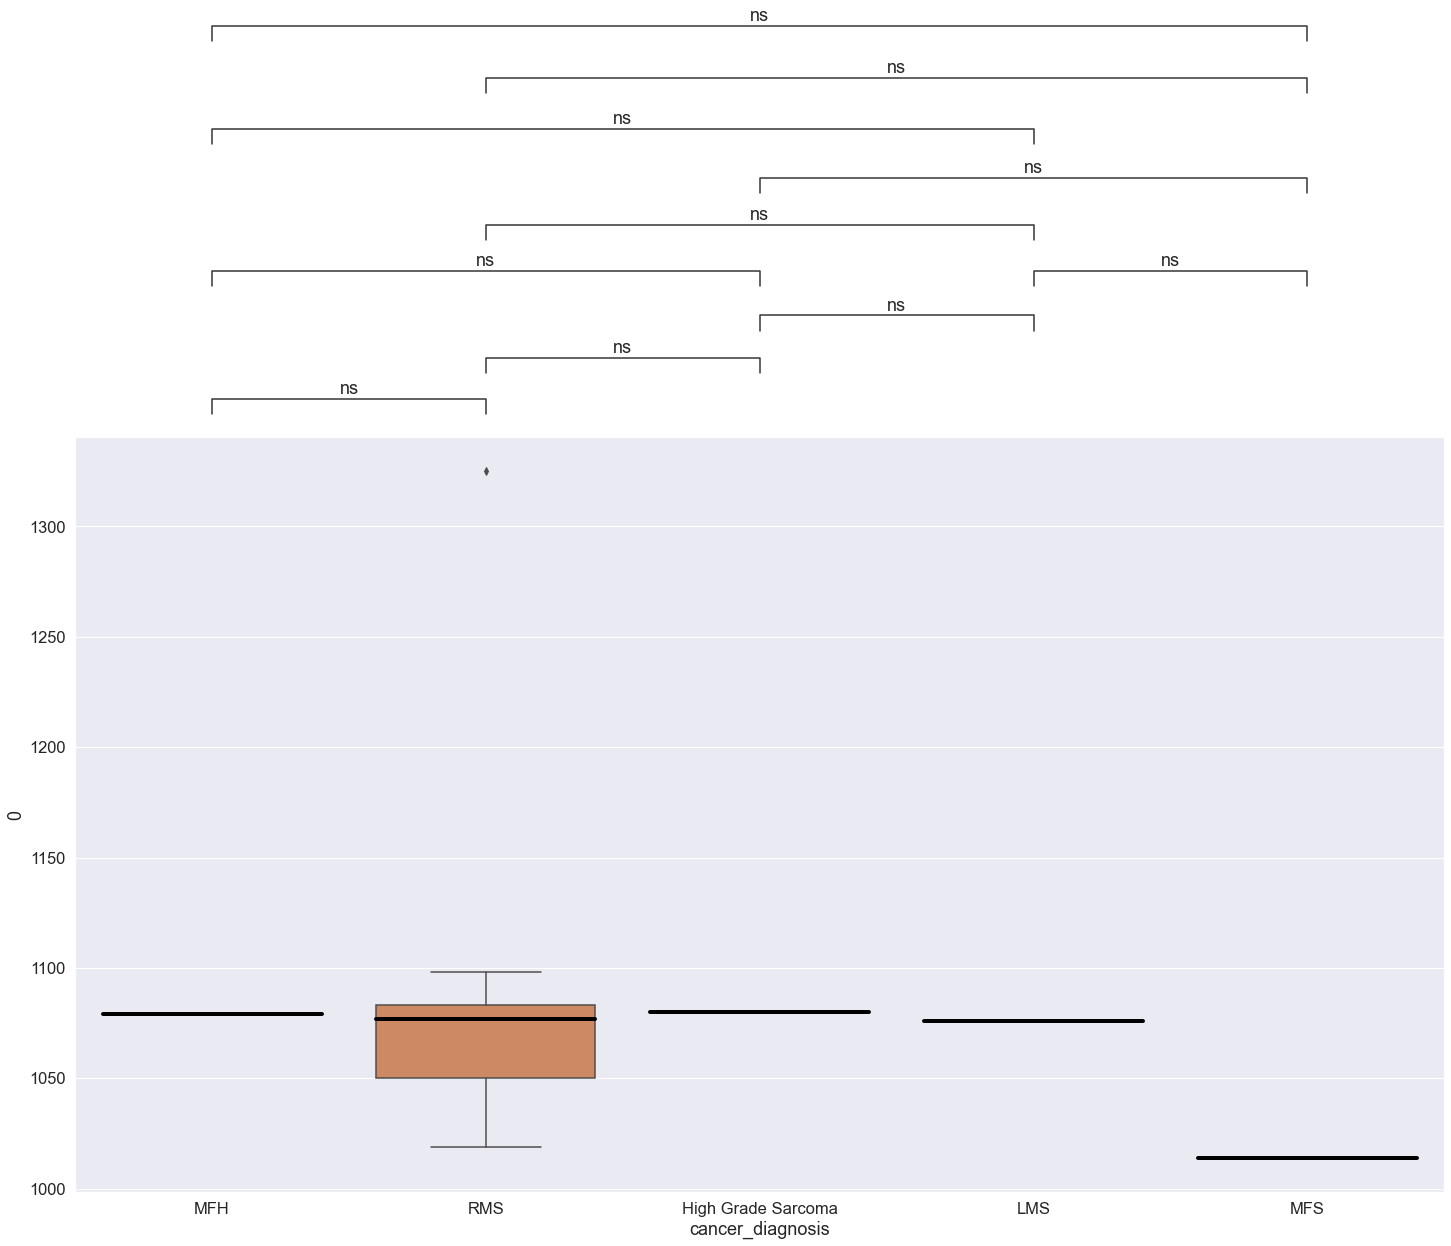

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ERMS_kics vs. ERMS_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:2.571e-01 U_stat=1.800e+01
ARMS_kics vs. ARMS_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
ARMS_lfs vs. ERMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.000e-01 U_stat=0.000e+00
ARMS_kics vs. ERMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=2.000e+00
ARMS_kics vs. ERMS_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:2.857e-01 U_stat=6.000e+00


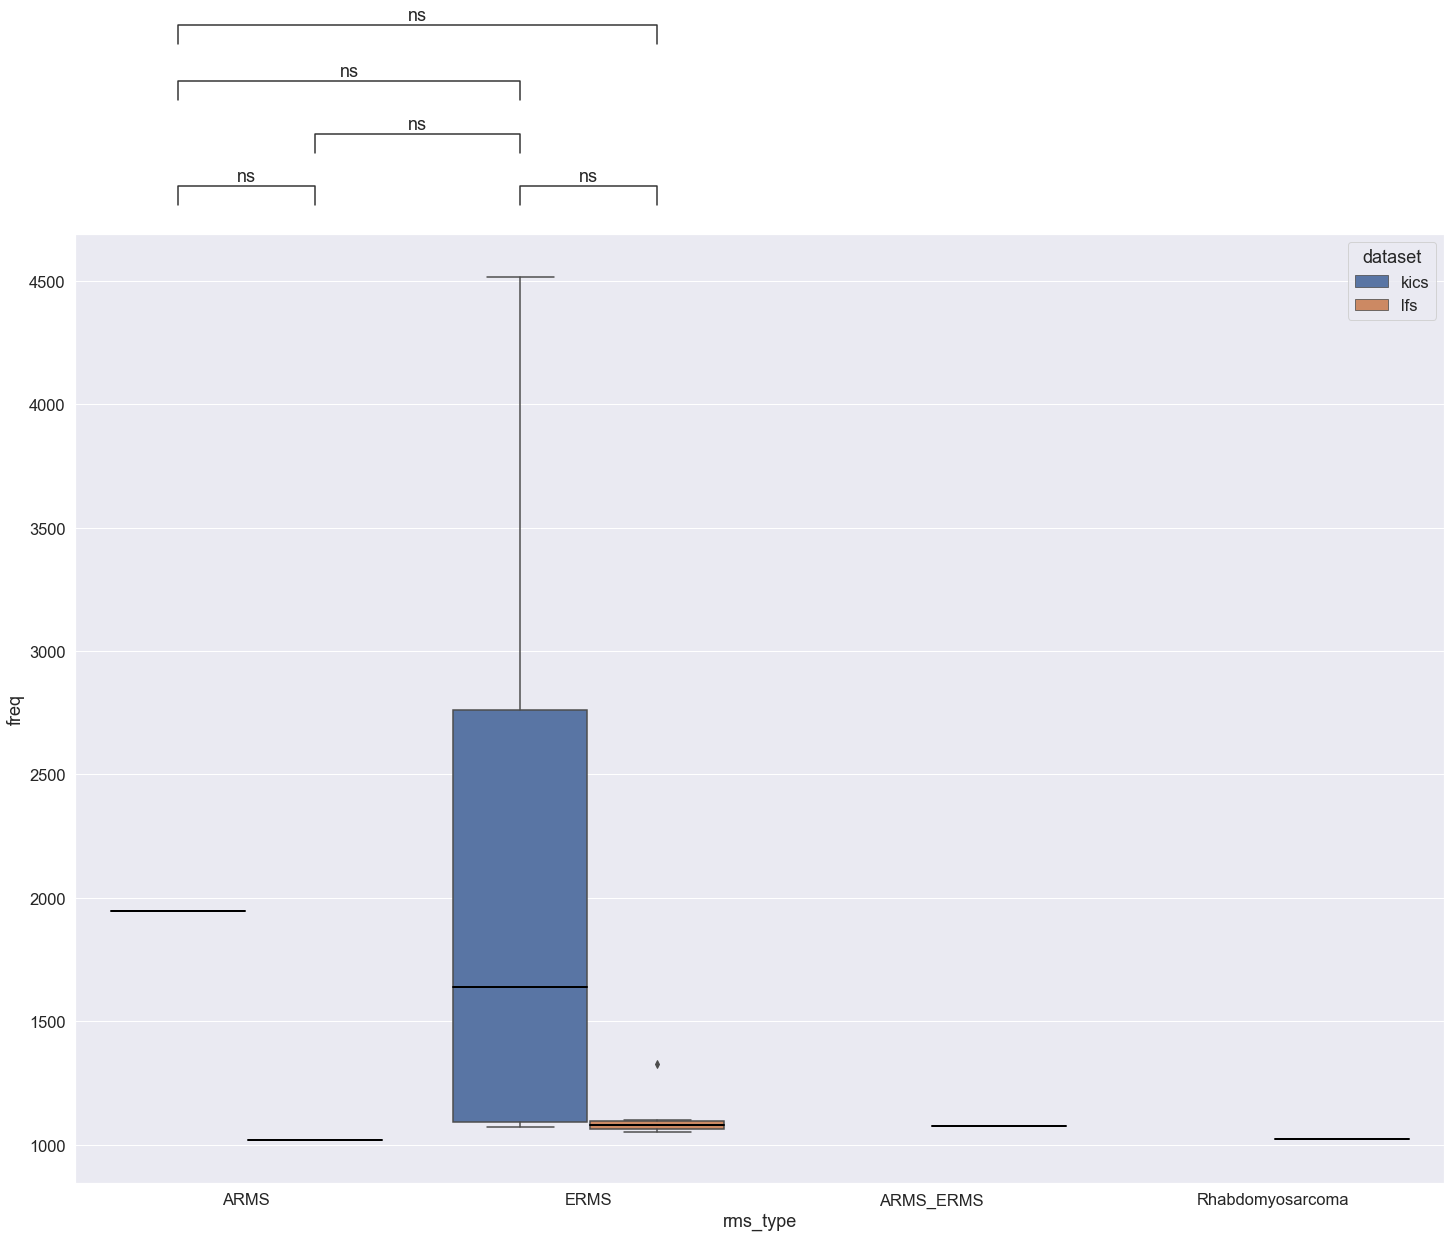

In [53]:
"""
Create graph for RMS subtypes
"""
rmsKDf = UberbigKdf[['Samples_ID','ICDO-diagnosis','tissue_type','lfs_cancer_type_diagnosis']]
rmsLDf = UberbigLdf[['Samples_ID','cancer1','tissue_type','cancer_diagnosis']]
rmsKDf = rmsKDf.loc[rmsKDf['lfs_cancer_type_diagnosis']=='RMS']

#rms (cancer type) and soft tissue (tissue type) in kics has the same samples
rmsKDf = rmsKDf.drop(['tissue_type','lfs_cancer_type_diagnosis'], axis=1).groupby(['Samples_ID']).value_counts().to_frame().reset_index()
rmsKDf['dataset']='kics'

#rms and soft tissue in lfs do not have the same samples
stLDf = rmsLDf.loc[rmsLDf['tissue_type']=='Soft Tissue']
stLDf = stLDf.drop(['tissue_type'],axis=1).groupby(['Samples_ID','cancer_diagnosis']).value_counts().to_frame().reset_index()

# graphing soft tissue mappings to cancer diagnosis column (lfs)
ax = sns.boxplot(data=stLDf, x='cancer_diagnosis', y=0, medianprops={"linewidth": 4, 'color':'black'})
    
uniqueList = list(stLDf['cancer_diagnosis'].unique())
listPairing = [(a,b) for x, a in enumerate(uniqueList) for b in uniqueList[x+1:]]
        
annot = Annotator(ax, listPairing, data=stLDf, x='cancer_diagnosis', y=0)
annot.configure(test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2)
annot.apply_and_annotate()
plt.show()

rmsLDf = rmsLDf.loc[rmsLDf['cancer_diagnosis']=='RMS']
rmsLDf = rmsLDf.drop(['tissue_type','cancer_diagnosis'], axis=1).groupby(['Samples_ID']).value_counts().to_frame().reset_index()
rmsLDf['dataset']='lfs'

rmsLDf = rmsLDf.rename(columns={'cancer1': 'type',0:'freq'})
rmsKDf = rmsKDf.rename(columns={'ICDO-diagnosis':'type', 0:'freq'})

rmsLDf['rms_type'] = rmsLDf.apply(lambda row: rmsType(row), axis=1)
rmsKDf['rms_type'] = rmsKDf.apply(lambda row: rmsType(row), axis=1)

mergedRMS = pd.concat([rmsKDf,rmsLDf])

#kics vs lfs, graphing RMS subtypes 
bx = sns.boxplot(data=mergedRMS, x='rms_type', y='freq',hue = 'dataset', medianprops={"linewidth": 2, 'color':'black'})

listPairing = [(('ERMS','kics'),('ERMS','lfs')), (('ERMS','kics'),('ARMS','lfs')),
               (('ARMS','kics'),('ERMS','lfs')), (('ARMS','kics'),('ARMS','lfs')),
               (('ARMS','kics'),('ERMS','kics'))]

annot = Annotator(bx, listPairing, data=mergedRMS, x='rms_type', y='freq',hue = 'dataset')
annot.configure(test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2)
annot.apply_and_annotate()
plt.show()